# PREPARE UMAP EMBEDDER

In [1]:
import torch #should be installed by default in any colab notebook
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import pandas as pd
from time import time
import plotly.express as px
import pickle
from umap import UMAP

2022-01-28 21:01:18.488023: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
from torch.utils.data import Dataset
from torchvision.io import read_image
from torch.utils.data import DataLoader

class ImageDataset(Dataset):
    def __init__(self, GT_file_path, images_dir_path):
        self.df_GTs = pd.DataFrame.from_dict(json.load(open(GT_file_path)))
        self.images_dir_path = images_dir_path
        self.len_data = len(self.df_GTs)

    def __len__(self):
        return self.len_data

    def __getitem__(self, idx):
        img_path = f"{self.images_dir_path}/IM_{self.df_GTs.iloc[idx,0]}_phiCR_{self.df_GTs.iloc[idx,1]}.png"
        image = read_image(img_path) #[1, 2X+1, 2X+1] torch tensor
        label = torch.Tensor([float(self.df_GTs.iloc[idx, 1])]).type(torch.float32) #[1] torch tensor of float32
        return image, label

In [3]:
GT_file_path_train = f"/home/oiangu/Desktop/Conical_Refraction_Polarimeter/OUTPUT/NOISY/TRAIN/GROUND_TRUTHS.json"
images_dir_path_train =f"/home/oiangu/Desktop/Conical_Refraction_Polarimeter/OUTPUT/NOISY/TRAIN/" 

num_images=5000
umap_dims=10
min_dist=0.5
n_neighbours=400
metric='hamming'

training_data = ImageDataset(GT_file_path_train, images_dir_path_train)

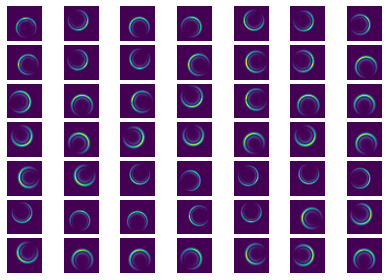

In [4]:
fig, ax_array = plt.subplots(7, 7)
axes = ax_array.flatten()
for i, ax in enumerate(axes):
    im, lab = training_data[i]
    ax.imshow(im[0])
plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0.4, w_pad=0.0001)

In [5]:
seed=666
np.random.seed(seed)
random_indices = np.random.choice(range(len(training_data)), num_images, replace=False)
#random_indices = np.random.choice(range(2850), num_images, replace=False)
X21 = training_data[0][0].shape[1]
x = np.zeros( (num_images, X21**2), dtype=np.float32)
y = np.zeros((num_images), dtype=np.float64)

for j,idx in enumerate(random_indices):
    im, lab = training_data[idx]
    x[j, :] = im[0].flatten()
    y[j] = lab   

df = pd.DataFrame({'y':y})
df['phiCR'] = df["y"].astype(str)

In [6]:
umap_embedder = UMAP(n_components=umap_dims, min_dist=min_dist, n_neighbors=n_neighbours, metric=metric) #euclidean, canberra, cosine, manhattan, braycurtis, mahalanobis, hamming
decimals=3
save_stuff_path = f"/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/LIBRARIES_OF_THEORETICAL_D/Basler_like_R0_300x_w0_300x_Z_50x_64bit/SIMULATIONS/UMAP_Regressor/"
f_name = f'SECOND_UMAP_EMBEDDER_num_images_{num_images}_umap_dims_{umap_dims}_min_dist_{min_dist}_n_neighbours_{n_neighbours}_metric_{metric}_decimals_{decimals}_seed_{seed}.sav'

In [5]:
import numpy as np
0.1*180/np.pi

5.729577951308232

Fit the embedder.

In [ ]:
umap_embedder = umap_embedder.fit(x, y=(np.around(y+np.pi, decimals)*10**decimals).astype(int))

/home/oiangu/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(


Save the fitted embedder.

In [ ]:
pickle.dump(umap_embedder, open(save_stuff_path+f_name, 'wb'))

Load fitted embedder.

In [7]:
umap_embedder = pickle.load((open(save_stuff_path+f_name, 'rb')))

We can visualize the quality of the embedding with a PCA to 2 and 3 dims.

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

principalComponents = pca.fit_transform(umap_embedder.embedding_)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
df['principal component 1'] = principalDf['principal component 1']
df['principal component 2'] = principalDf['principal component 2']

In [ ]:
from io import BytesIO
from PIL import Image
import base64
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, LinearColorMapper
from bokeh.palettes import Spectral10

output_notebook()

def embeddable_image(data):
    img_data = data.values.reshape(X21,X21).astype(np.uint8)
    image = Image.fromarray(img_data, mode='L').resize((64, 64), Image.BICUBIC)
    buffer = BytesIO()
    image.save(buffer, format='png')
    for_encoding = buffer.getvalue()
    return 'data:image/png;base64,' + base64.b64encode(for_encoding).decode()

df['image'] = pd.DataFrame(data=x, columns=list(range(x.shape[1]))).apply(embeddable_image, axis=1)

datasource = ColumnDataSource(df)
color_mapping = LinearColorMapper(
    palette='Magma256',
    low=y.min(),
    high=y.max()
)

plot_figure = figure(
    title='PCA projection of the CR dataset',
    plot_width=800,
    plot_height=800,
    tools=('pan, wheel_zoom, reset')
)

plot_figure.add_tools(HoverTool(tooltips="""
<div>
    <div>
        <img src='@image' style='float: left; margin: 5px 5px 5px 5px'/>
    </div>
    <div>
        <span style='font-size: 16px; color: #224499'>phiCR:</span>
        <span style='font-size: 18px'>@phiCR</span>
    </div>
</div>
"""))

plot_figure.circle(
    'principal component 1',
    'principal component 2',
    source=datasource,
    color=dict(field='phiCR', transform=color_mapping),
    line_alpha=0.6,
    fill_alpha=0.6,
    size=7
)
show(plot_figure)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)

principalComponents = pca.fit_transform(umap_embedder.embedding_)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2', 'principal component 3'])
df['principal component 1'] = principalDf['principal component 1']
df['principal component 2'] = principalDf['principal component 2']
df['principal component 3'] = principalDf['principal component 3']

In [ ]:
fig=px.scatter_3d(df, x="principal component 1", y="principal component 2", z="principal component 3", color="y")
fig.update_traces(marker={"size":3})
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.show()

# TRAIN FULLY CONNECTED FROM EMBEDDING TO ANGLE

In [1]:
import torch #should be installed by default in any colab notebook
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import json
import os
import pandas as pd
import h5py
from time import time
from datetime import datetime
from IPython import display as display_IPython
import pickle
#from umap import UMAP

assert torch.cuda.is_available(), "GPU is not enabled"

# use gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Define the Model

In [2]:
class Embedding_to_Angle(nn.Module):
    def __init__(self, embedding_dims, X=302, 
                 out_fc_1=20, out_fc_2=10, out_fc_3=10, out_fc_4=5,
                 dropout_p1=0.4, dropout_p2=0.2
                ): 
        super(Embedding_to_Angle, self).__init__()
        self.embedding_dims = embedding_dims
        self.in_fc = embedding_dims
        
        self.fc1 = nn.Linear(in_features=self.in_fc, out_features=out_fc_1, bias=True)
        self.fc2 = nn.Linear(in_features=out_fc_1, out_features=out_fc_2, bias=True)
        self.fc3 = nn.Linear(in_features=out_fc_2, out_features=out_fc_3, bias=True)
        self.fc4 = nn.Linear(in_features=out_fc_3, out_features=out_fc_4, bias=True)
        self.fc5 = nn.Linear(in_features=out_fc_4, out_features=1, bias=True)

        self.dropout1 = nn.Dropout(p=dropout_p1, inplace=False)
        self.dropout2 = nn.Dropout(p=dropout_p2, inplace=False)
        self.relu = torch.nn.functional.relu

        #self.batchNorm2 = nn.BatchNorm2d(num_features=feats_2)
        #self.batchNorm4 = nn.BatchNorm2d(num_features=feats_4)

    def forward(self, x): # [batch_size, 2X+1, 2X+1] or [batch_size, 1, 2X+1, 2X+1]
        x = x.view(x.shape[0], self.embedding_dims).float() # [batch_size, embedding_dims]
        x = self.dropout2( self.relu( self.fc1( x ) ) ) # [batch_size, out_fc_1]
        x = self.dropout1( self.relu( self.fc2( x ) ) ) # [batch_size, out_fc_2]
        x = self.dropout2( self.relu( self.fc3( x ) ) ) # [batch_size, out_fc_3]
        x = self.dropout1( self.relu( self.fc4( x ) ) ) # [batch_size, out_fc_4]
        x = self.fc5( x )                                 # [batch_size, 1]        
        return x   

In [3]:
# subroutine to count number of parameters in the model
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.numel()
    return np

## Routines to validate and train

In [4]:
@torch.no_grad()  # prevent this function from computing gradients 
def validate_epoch(criterion, model, dataloader, per_epoch_use_max_batches=None): #show_confusion_matrix = False):
    if per_epoch_use_max_batches is None:
        per_epoch_use_max_batches = len(dataloader)
    val_loss = 0
    max_abs_error = torch.Tensor([0]).to(device)
    mean_abs_error = 0
    preds = torch.Tensor().to(device)
    targets = torch.Tensor().to(device)

    model.eval() # disable the dropout, among others

    for batch_id in range(len(dataloader)):  
        data, target = dataloader[batch_id] # dataloader sends them to device already   
        prediction = model(data)
        target = target.view(prediction.shape)
        loss = criterion(prediction, target)
        val_loss += loss.item()             
        max_abs_error = torch.maximum(torch.max(torch.abs(prediction-target), 0).values, max_abs_error)
        mean_abs_error += torch.mean(torch.abs(prediction-target), 0)
        if batch_id % per_epoch_use_max_batches == per_epoch_use_max_batches-1:
            break
    val_loss /= min(len(dataloader), per_epoch_use_max_batches)
    mean_abs_error /= min(len(dataloader), per_epoch_use_max_batches)
    #accuracy = 100. * correct / len(loader.dataset)
    print(f'\nValidation set: Average loss: {val_loss:.4f}, Average Abs Error: {np.array(mean_abs_error.cpu())}, Maximum Abs Error: {np.array(max_abs_error.cpu())} \n')

    #if show_confusion_matrix:
    #    visualize_confusion_matrix(preds.to(torch.device('cpu')), targets.to(torch.device('cpu')))

    return val_loss


def train_epoch(epoch, criterion, model, optimizer, dataloader, print_loss_every_batches=20,
                optimizer_step_every_batches=1, per_epoch_use_max_batches=None):
    if per_epoch_use_max_batches is None:
        per_epoch_use_max_batches = len(dataloader)
        
    total_loss = 0.0

    model.train()

    optimizer.zero_grad()
    #t = time()
    random_indices = np.random.choice(range(len(dataloader)), len(dataloader), replace=False)
    for batch_id, idx in enumerate(random_indices):  
        data, target = dataloader[idx] # dataloader sends them to device already
        #data, target = data.to(device), target.to(device)
        prediction = model(data) # data is [batch_size, embedding_dim]
        loss = criterion(prediction, target)
        loss.backward()
        
        if batch_id % optimizer_step_every_batches==optimizer_step_every_batches-1:
            optimizer.step()
            optimizer.zero_grad()
        # print loss every N batches
        if batch_id % print_loss_every_batches == print_loss_every_batches-1:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (batch_id+1) * len(data), len(dataloader)*dataloader.batch_size,
                100*(batch_id+1)*len(data) / (len(dataloader)*dataloader.batch_size), loss.item()))

        #if batch_id % per_epoch_use_max_batches == per_epoch_use_max_batches-1:
        #    break


        total_loss += loss.item()  #.item() is very important here
        # In order to avoid having total_loss as a tensor in the gpu
        #t = time()

    return total_loss / min(len(dataloader), per_epoch_use_max_batches)

## The full training loop

In [5]:
def full_training_loop(model, criterion, optimizer, train_loader, test_loader, epochs=10,
                       print_loss_every_batches=20, validate_every_epochs=2, optimizer_step_every_batches=1,
                      per_epoch_use_max_train_batches=None, per_epoch_use_max_test_batches=None,
                      image_path=None, save_model_every_epochs=1, model_path=None, best_model_path=None):
    losses = {"train": [], "val": []}
    %matplotlib inline
    for epoch in range(epochs):

        train_loss = train_epoch(epoch, criterion, model, optimizer, train_loader,
                                 print_loss_every_batches=print_loss_every_batches,
                                optimizer_step_every_batches=optimizer_step_every_batches,
                                per_epoch_use_max_batches=per_epoch_use_max_train_batches)
        if epoch%validate_every_epochs==0 and epoch!=0:
            val_loss = validate_epoch(criterion, model, test_loader, per_epoch_use_max_test_batches)
        else:
            try:
                val_loss = losses["val"][-1]
            except:
                val_loss = train_loss
        if epoch and train_loss<=min(losses["train"]) and best_model_path:
            torch.save({
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            }, best_model_path)
        
        losses["train"].append(train_loss)
        losses["val"].append(val_loss)        
        plt.plot(losses["train"], label="training loss")
        plt.plot(losses["val"], label="validation loss")
        #plt.yscale('log')
        plt.legend()
        if image_path is not None:
            plt.savefig(image_path)
            plt.clf()
        else:
            display_IPython.clear_output(wait=True)
            plt.pause(0.001)
            plt.show()
        if epoch % save_model_every_epochs==save_model_every_epochs-1 and model_path:
            torch.save({
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            }, model_path)

    return losses

## The Dataset class and Data Sampler

In [6]:
from torch.utils.data import Dataset
from torchvision.io import read_image
from torch.utils.data import DataLoader

class EmbeddingImageDataset(Dataset):
    def __init__(self, GT_file_path, images_dir_path, embedder):
        self.df_GTs = pd.DataFrame.from_dict(json.load(open(GT_file_path)))
        self.images_dir_path = images_dir_path
        self.len_data = len(self.df_GTs)
        self.embedder = embedder
        #self.embdding_dims = embedder.embedding_.shape[-1]

    def __len__(self):
        return self.len_data

    def __getitem__(self, idx):
        img_path = f"{self.images_dir_path}/IM_{self.df_GTs.iloc[idx,0]}_phiCR_{self.df_GTs.iloc[idx,1]}.png"
        image = read_image(img_path) #[1, 2X+1, 2X+1] torch tensor
        #embedding=image
        embedding = torch.Tensor(self.embedder.transform(image.flatten().unsqueeze(0))) # [1, embedding_dims]
        label = torch.Tensor([float(self.df_GTs.iloc[idx, 1])]).type(torch.float32) #[1] torch tensor of float32
        return embedding, label
    
class EmbeddingDataset(Dataset):
    def __init__(self, h5f_full_path):
        self.h5f = h5py.File(f"{h5f_full_path}", 'r')
        self.num_batches = len(self.h5f)
        self.batch_size = self.h5f['0'].shape[0]
        self.feature_num = self.h5f['0'].shape[1]-1
        print(f"There are {self.batch_size} images per batch\nwith {self.feature_num} features per data\nand {self.num_batches} batches in total")
        print(f"A total of {self.batch_size*self.num_batches} samples.")

    def __len__(self):
        return self.num_batches

    def __getitem__(self, idx):
        data_and_label = torch.tensor(np.array(self.h5f[str(idx)]), device=device)
        return data_and_label[:,:-1], data_and_label[:,-1].unsqueeze(1)

## Initialize the dataset and sampler (choose the number of batches per epoch, and their length) and fix the artificial noise hyperparameters

In [7]:
#GT_file_path_train = f"/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/LIBRARIES_OF_THEORETICAL_D/Basler_like_R0_300x_w0_300x_Z_50x_64bit/IMAGE_LIBRARY/NON_NOISY/TRAIN/GROUND_TRUTHS.json"
#images_dir_path_train =f"/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/LIBRARIES_OF_THEORETICAL_D/Basler_like_R0_300x_w0_300x_Z_50x_64bit/IMAGE_LIBRARY/NON_NOISY/TRAIN/" 
#GT_file_path_test = f"/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/LIBRARIES_OF_THEORETICAL_D/Basler_like_R0_300x_w0_300x_Z_50x_64bit/IMAGE_LIBRARY/NON_NOISY/TEST/GROUND_TRUTHS.json"
#images_dir_path_test = f"/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/LIBRARIES_OF_THEORETICAL_D/Basler_like_R0_300x_w0_300x_Z_50x_64bit/IMAGE_LIBRARY/NON_NOISY/TEST/"

save_stuff_path = f"/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/LIBRARIES_OF_THEORETICAL_D/Basler_like_R0_300x_w0_300x_Z_50x_64bit/SIMULATIONS/UMAP_Regressor/"

# Image directories
#GT_file_path_train = f"/home/oiangu/Desktop/Conical_Refraction_Polarimeter/OUTPUT/NOISY/TRAIN/GROUND_TRUTHS.json"
#images_dir_path_train =f"/home/oiangu/Desktop/Conical_Refraction_Polarimeter/OUTPUT/NOISY/TRAIN/" 
#GT_file_path_test = f"/home/oiangu/Desktop/Conical_Refraction_Polarimeter/OUTPUT/NOISY/TEST/GROUND_TRUTHS.json"
#images_dir_path_test =f"/home/oiangu/Desktop/Conical_Refraction_Polarimeter/OUTPUT/NOISY/TEST/" 

# Embedding h5f file
full_path_h5f = f"{save_stuff_path}/Dataset_Embedding.h5"
training_data = EmbeddingDataset(full_path_h5f)

# Embedder parameters
num_images=3200
umap_dims=10
min_dist=0.1
n_neighbours=700
metric='hamming'
embedder_path = save_stuff_path + \
        f'UMAP_EMBEDDER_num_images_{num_images}_umap_dims_{umap_dims}_min_dist_{min_dist}_n_neighbours_{n_neighbours}_metric_{metric}.sav'


# Training parameters
total_epochs = 1000000
#batch_size = 2 #20
validate_every_epochs = 100
optimizer_step_every_batches = 12
per_epoch_use_max_train_batches= len(training_data)+1 #12
per_epoch_use_max_test_batches=len(training_data)+1 
save_model_every_epochs = 100

# Dataloader parameters
worker_num=2

There are 40 images per batch
with 10 features per data
and 2103 batches in total
A total of 84120 samples.


In [9]:
#umap_embedder = UMAP(n_components=umap_dims, min_dist=min_dist, n_neighbors=n_neighbours, metric=metric) #euclidean, canberra, cosine, manhattan, braycurtis, mahalanobis, hamming
#umap_embedder = pickle.load((open(embedder_path, 'rb')))

In [10]:
#torch.manual_seed(678)
#training_data = EmbeddingImageDataset(GT_file_path_train, images_dir_path_train, umap_embedder)
#test_data = EmbeddingImageDataset(GT_file_path_test, images_dir_path_test, umap_embedder)

In [9]:
#train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=worker_num,
#                              pin_memory=True, drop_last=False, persistent_workers=False)
#test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=worker_num, 
#                             pin_memory=True, drop_last=False, persistent_workers=False)


#assert(len(train_dataloader)%batch_size==0 or per_epoch_use_max_train_batches%batch_size==0 ) # make batch_size an integer proportion of data files
#batch_number_per_epoch = min(len(train_dataloader)/batch_size, per_epoch_use_max_train_batches)
#assert(batch_number_per_epoch%optimizer_step_every_batches==0) # make optimizer steps every divisble number of its

## Fix hyperparameters and initialize the model and optimizer

In [8]:
embedding_dims = training_data.feature_num
#embedding_dims=umap_embedder.embedding_.shape[-1]
X=302
out_fc_1=20
out_fc_2=20
out_fc_3=20
out_fc_4=20
dropout_p1=0.4
dropout_p2=0.2

In [12]:
model = Embedding_to_Angle(embedding_dims, X=X, 
                 out_fc_1=out_fc_1, out_fc_2=out_fc_2, out_fc_3=out_fc_3, out_fc_4=out_fc_4,
                 dropout_p1=dropout_p1, dropout_p2=dropout_p2
                )

print(f"Number of parameters {get_n_params(model)}")

# In case we wish to transfer the learned parameters of another run
check_file="BEST_Noisy_Model_and_Optimizer_2022-01-27 21:10:54.355981.pt"
checkpoint = torch.load(save_stuff_path+f"/{check_file}")

# move model to gpu if available
model.to(device)

model.load_state_dict(checkpoint['model'])


# Initialize the weights of the model! Default initialization might already be fine!

# we can use a MSE loss for the regression task we have in hands
criterion = nn.MSELoss()

# we will choose as optimizer the 
#optimizer = torch.optim.Adagrad(model.parameters(), lr=0.1, lr_decay=0.01, weight_decay=0.3,
#                                initial_accumulator_value=0, eps=1e-10)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0000001, betas=(0.99, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
#optimizer.load_state_dict(checkpoint['optimizer'])

Number of parameters 1501


## Run the Training

In [10]:
%%time
losses = full_training_loop(model, criterion, optimizer, training_data, training_data, 
                    epochs=total_epochs, print_loss_every_batches=2100,
                            validate_every_epochs=validate_every_epochs,
                           optimizer_step_every_batches=optimizer_step_every_batches,
                           per_epoch_use_max_train_batches=per_epoch_use_max_train_batches, 
                            per_epoch_use_max_test_batches=per_epoch_use_max_test_batches,
                           image_path=save_stuff_path+ f"/Noisy_Training_{datetime.now()}.png",
                           save_model_every_epochs=save_model_every_epochs, 
                            model_path=save_stuff_path+f"/Noisy_Model_and_Optimizer_{datetime.now()}.pt",
                            best_model_path=save_stuff_path+f"/BEST_Noisy_Model_and_Optimizer_{datetime.now()}.pt"
                           )
# Execute the training and validation

Train Epoch: 0 [84000/84120 (100%)]	Loss: 2.572293
Train Epoch: 1 [84000/84120 (100%)]	Loss: 3.322192
Train Epoch: 2 [84000/84120 (100%)]	Loss: 2.962897
Train Epoch: 3 [84000/84120 (100%)]	Loss: 3.648107
Train Epoch: 4 [84000/84120 (100%)]	Loss: 3.365303
Train Epoch: 5 [84000/84120 (100%)]	Loss: 3.376095
Train Epoch: 6 [84000/84120 (100%)]	Loss: 3.580819
Train Epoch: 7 [84000/84120 (100%)]	Loss: 2.616408
Train Epoch: 8 [84000/84120 (100%)]	Loss: 3.467545
Train Epoch: 9 [84000/84120 (100%)]	Loss: 3.045719
Train Epoch: 10 [84000/84120 (100%)]	Loss: 2.728247
Train Epoch: 11 [84000/84120 (100%)]	Loss: 3.086998
Train Epoch: 12 [84000/84120 (100%)]	Loss: 2.566544
Train Epoch: 13 [84000/84120 (100%)]	Loss: 2.688686
Train Epoch: 14 [84000/84120 (100%)]	Loss: 2.644627
Train Epoch: 15 [84000/84120 (100%)]	Loss: 2.407366
Train Epoch: 16 [84000/84120 (100%)]	Loss: 2.945274
Train Epoch: 17 [84000/84120 (100%)]	Loss: 2.857264
Train Epoch: 18 [84000/84120 (100%)]	Loss: 3.225139
Train Epoch: 19 [84000

Train Epoch: 155 [84000/84120 (100%)]	Loss: 0.574490
Train Epoch: 156 [84000/84120 (100%)]	Loss: 1.632635
Train Epoch: 157 [84000/84120 (100%)]	Loss: 0.738281
Train Epoch: 158 [84000/84120 (100%)]	Loss: 0.461859
Train Epoch: 159 [84000/84120 (100%)]	Loss: 1.167579
Train Epoch: 160 [84000/84120 (100%)]	Loss: 1.115236
Train Epoch: 161 [84000/84120 (100%)]	Loss: 0.501404
Train Epoch: 162 [84000/84120 (100%)]	Loss: 1.040209
Train Epoch: 163 [84000/84120 (100%)]	Loss: 0.550219
Train Epoch: 164 [84000/84120 (100%)]	Loss: 1.450900
Train Epoch: 165 [84000/84120 (100%)]	Loss: 1.887013
Train Epoch: 166 [84000/84120 (100%)]	Loss: 0.992067
Train Epoch: 167 [84000/84120 (100%)]	Loss: 1.467934
Train Epoch: 168 [84000/84120 (100%)]	Loss: 1.269926
Train Epoch: 169 [84000/84120 (100%)]	Loss: 0.923068
Train Epoch: 170 [84000/84120 (100%)]	Loss: 1.220366
Train Epoch: 171 [84000/84120 (100%)]	Loss: 0.559845
Train Epoch: 172 [84000/84120 (100%)]	Loss: 0.934403
Train Epoch: 173 [84000/84120 (100%)]	Loss: 1.

Train Epoch: 306 [84000/84120 (100%)]	Loss: 0.776278
Train Epoch: 307 [84000/84120 (100%)]	Loss: 1.783572
Train Epoch: 308 [84000/84120 (100%)]	Loss: 0.469419
Train Epoch: 309 [84000/84120 (100%)]	Loss: 1.123426
Train Epoch: 310 [84000/84120 (100%)]	Loss: 0.456447
Train Epoch: 311 [84000/84120 (100%)]	Loss: 0.531186
Train Epoch: 312 [84000/84120 (100%)]	Loss: 0.570615
Train Epoch: 313 [84000/84120 (100%)]	Loss: 0.441769
Train Epoch: 314 [84000/84120 (100%)]	Loss: 1.278268
Train Epoch: 315 [84000/84120 (100%)]	Loss: 1.068501
Train Epoch: 316 [84000/84120 (100%)]	Loss: 0.593417
Train Epoch: 317 [84000/84120 (100%)]	Loss: 0.401470
Train Epoch: 318 [84000/84120 (100%)]	Loss: 0.841275
Train Epoch: 319 [84000/84120 (100%)]	Loss: 0.561158
Train Epoch: 320 [84000/84120 (100%)]	Loss: 0.541792
Train Epoch: 321 [84000/84120 (100%)]	Loss: 0.427675
Train Epoch: 322 [84000/84120 (100%)]	Loss: 0.554497
Train Epoch: 323 [84000/84120 (100%)]	Loss: 1.540214
Train Epoch: 324 [84000/84120 (100%)]	Loss: 0.

Train Epoch: 459 [84000/84120 (100%)]	Loss: 0.604411
Train Epoch: 460 [84000/84120 (100%)]	Loss: 0.345418
Train Epoch: 461 [84000/84120 (100%)]	Loss: 0.759586
Train Epoch: 462 [84000/84120 (100%)]	Loss: 0.324370
Train Epoch: 463 [84000/84120 (100%)]	Loss: 1.589501
Train Epoch: 464 [84000/84120 (100%)]	Loss: 0.612267
Train Epoch: 465 [84000/84120 (100%)]	Loss: 0.475004
Train Epoch: 466 [84000/84120 (100%)]	Loss: 1.381913
Train Epoch: 467 [84000/84120 (100%)]	Loss: 0.499103
Train Epoch: 468 [84000/84120 (100%)]	Loss: 1.765655
Train Epoch: 469 [84000/84120 (100%)]	Loss: 1.055359
Train Epoch: 470 [84000/84120 (100%)]	Loss: 0.540079
Train Epoch: 471 [84000/84120 (100%)]	Loss: 0.718885
Train Epoch: 472 [84000/84120 (100%)]	Loss: 0.783491
Train Epoch: 473 [84000/84120 (100%)]	Loss: 0.483762
Train Epoch: 474 [84000/84120 (100%)]	Loss: 0.402467
Train Epoch: 475 [84000/84120 (100%)]	Loss: 0.392416
Train Epoch: 476 [84000/84120 (100%)]	Loss: 0.267998
Train Epoch: 477 [84000/84120 (100%)]	Loss: 0.

Train Epoch: 610 [84000/84120 (100%)]	Loss: 0.331568
Train Epoch: 611 [84000/84120 (100%)]	Loss: 0.575611
Train Epoch: 612 [84000/84120 (100%)]	Loss: 0.488425
Train Epoch: 613 [84000/84120 (100%)]	Loss: 1.557612
Train Epoch: 614 [84000/84120 (100%)]	Loss: 1.206756
Train Epoch: 615 [84000/84120 (100%)]	Loss: 1.035124
Train Epoch: 616 [84000/84120 (100%)]	Loss: 0.690675
Train Epoch: 617 [84000/84120 (100%)]	Loss: 0.931931
Train Epoch: 618 [84000/84120 (100%)]	Loss: 0.602400
Train Epoch: 619 [84000/84120 (100%)]	Loss: 0.934648
Train Epoch: 620 [84000/84120 (100%)]	Loss: 0.695180
Train Epoch: 621 [84000/84120 (100%)]	Loss: 0.347351
Train Epoch: 622 [84000/84120 (100%)]	Loss: 0.304459
Train Epoch: 623 [84000/84120 (100%)]	Loss: 0.805044
Train Epoch: 624 [84000/84120 (100%)]	Loss: 0.373283
Train Epoch: 625 [84000/84120 (100%)]	Loss: 0.756528
Train Epoch: 626 [84000/84120 (100%)]	Loss: 0.322453
Train Epoch: 627 [84000/84120 (100%)]	Loss: 0.270738
Train Epoch: 628 [84000/84120 (100%)]	Loss: 0.

Train Epoch: 763 [84000/84120 (100%)]	Loss: 0.844512
Train Epoch: 764 [84000/84120 (100%)]	Loss: 0.867067
Train Epoch: 765 [84000/84120 (100%)]	Loss: 0.319274
Train Epoch: 766 [84000/84120 (100%)]	Loss: 0.274703
Train Epoch: 767 [84000/84120 (100%)]	Loss: 0.917939
Train Epoch: 768 [84000/84120 (100%)]	Loss: 0.841392
Train Epoch: 769 [84000/84120 (100%)]	Loss: 0.248454
Train Epoch: 770 [84000/84120 (100%)]	Loss: 0.341386
Train Epoch: 771 [84000/84120 (100%)]	Loss: 0.384210
Train Epoch: 772 [84000/84120 (100%)]	Loss: 0.692591
Train Epoch: 773 [84000/84120 (100%)]	Loss: 1.512426
Train Epoch: 774 [84000/84120 (100%)]	Loss: 0.246030
Train Epoch: 775 [84000/84120 (100%)]	Loss: 0.250203
Train Epoch: 776 [84000/84120 (100%)]	Loss: 0.843165
Train Epoch: 777 [84000/84120 (100%)]	Loss: 0.821526
Train Epoch: 778 [84000/84120 (100%)]	Loss: 1.148474
Train Epoch: 779 [84000/84120 (100%)]	Loss: 0.440644
Train Epoch: 780 [84000/84120 (100%)]	Loss: 0.531551
Train Epoch: 781 [84000/84120 (100%)]	Loss: 0.

Train Epoch: 914 [84000/84120 (100%)]	Loss: 0.331108
Train Epoch: 915 [84000/84120 (100%)]	Loss: 1.357035
Train Epoch: 916 [84000/84120 (100%)]	Loss: 0.319159
Train Epoch: 917 [84000/84120 (100%)]	Loss: 0.433231
Train Epoch: 918 [84000/84120 (100%)]	Loss: 0.681281
Train Epoch: 919 [84000/84120 (100%)]	Loss: 0.289232
Train Epoch: 920 [84000/84120 (100%)]	Loss: 2.050629
Train Epoch: 921 [84000/84120 (100%)]	Loss: 0.562433
Train Epoch: 922 [84000/84120 (100%)]	Loss: 1.071114
Train Epoch: 923 [84000/84120 (100%)]	Loss: 0.513671
Train Epoch: 924 [84000/84120 (100%)]	Loss: 0.323187
Train Epoch: 925 [84000/84120 (100%)]	Loss: 1.129202
Train Epoch: 926 [84000/84120 (100%)]	Loss: 0.259264
Train Epoch: 927 [84000/84120 (100%)]	Loss: 0.371333
Train Epoch: 928 [84000/84120 (100%)]	Loss: 1.130807
Train Epoch: 929 [84000/84120 (100%)]	Loss: 0.328924
Train Epoch: 930 [84000/84120 (100%)]	Loss: 1.721884
Train Epoch: 931 [84000/84120 (100%)]	Loss: 1.181799
Train Epoch: 932 [84000/84120 (100%)]	Loss: 0.

Train Epoch: 1066 [84000/84120 (100%)]	Loss: 1.344829
Train Epoch: 1067 [84000/84120 (100%)]	Loss: 0.963302
Train Epoch: 1068 [84000/84120 (100%)]	Loss: 1.381956
Train Epoch: 1069 [84000/84120 (100%)]	Loss: 0.396471
Train Epoch: 1070 [84000/84120 (100%)]	Loss: 0.693439
Train Epoch: 1071 [84000/84120 (100%)]	Loss: 0.435592
Train Epoch: 1072 [84000/84120 (100%)]	Loss: 0.846604
Train Epoch: 1073 [84000/84120 (100%)]	Loss: 0.564868
Train Epoch: 1074 [84000/84120 (100%)]	Loss: 0.781621
Train Epoch: 1075 [84000/84120 (100%)]	Loss: 0.581827
Train Epoch: 1076 [84000/84120 (100%)]	Loss: 1.168834
Train Epoch: 1077 [84000/84120 (100%)]	Loss: 1.859636
Train Epoch: 1078 [84000/84120 (100%)]	Loss: 0.278957
Train Epoch: 1079 [84000/84120 (100%)]	Loss: 0.306802
Train Epoch: 1080 [84000/84120 (100%)]	Loss: 0.622958
Train Epoch: 1081 [84000/84120 (100%)]	Loss: 0.431777
Train Epoch: 1082 [84000/84120 (100%)]	Loss: 1.219665
Train Epoch: 1083 [84000/84120 (100%)]	Loss: 0.353474
Train Epoch: 1084 [84000/841

Train Epoch: 1214 [84000/84120 (100%)]	Loss: 0.226239
Train Epoch: 1215 [84000/84120 (100%)]	Loss: 0.341627
Train Epoch: 1216 [84000/84120 (100%)]	Loss: 0.857216
Train Epoch: 1217 [84000/84120 (100%)]	Loss: 0.685169
Train Epoch: 1218 [84000/84120 (100%)]	Loss: 0.230096
Train Epoch: 1219 [84000/84120 (100%)]	Loss: 0.220430
Train Epoch: 1220 [84000/84120 (100%)]	Loss: 0.292899
Train Epoch: 1221 [84000/84120 (100%)]	Loss: 0.461006
Train Epoch: 1222 [84000/84120 (100%)]	Loss: 0.301996
Train Epoch: 1223 [84000/84120 (100%)]	Loss: 0.989788
Train Epoch: 1224 [84000/84120 (100%)]	Loss: 1.430654
Train Epoch: 1225 [84000/84120 (100%)]	Loss: 0.367439
Train Epoch: 1226 [84000/84120 (100%)]	Loss: 2.241747
Train Epoch: 1227 [84000/84120 (100%)]	Loss: 0.359580
Train Epoch: 1228 [84000/84120 (100%)]	Loss: 0.315319
Train Epoch: 1229 [84000/84120 (100%)]	Loss: 0.527087
Train Epoch: 1230 [84000/84120 (100%)]	Loss: 0.959911
Train Epoch: 1231 [84000/84120 (100%)]	Loss: 0.777606
Train Epoch: 1232 [84000/841

Train Epoch: 1364 [84000/84120 (100%)]	Loss: 0.401216
Train Epoch: 1365 [84000/84120 (100%)]	Loss: 0.435581
Train Epoch: 1366 [84000/84120 (100%)]	Loss: 0.355594
Train Epoch: 1367 [84000/84120 (100%)]	Loss: 0.280854
Train Epoch: 1368 [84000/84120 (100%)]	Loss: 0.163254
Train Epoch: 1369 [84000/84120 (100%)]	Loss: 1.550276
Train Epoch: 1370 [84000/84120 (100%)]	Loss: 0.581928
Train Epoch: 1371 [84000/84120 (100%)]	Loss: 1.053974
Train Epoch: 1372 [84000/84120 (100%)]	Loss: 0.915438
Train Epoch: 1373 [84000/84120 (100%)]	Loss: 0.503266
Train Epoch: 1374 [84000/84120 (100%)]	Loss: 0.858050
Train Epoch: 1375 [84000/84120 (100%)]	Loss: 0.458326
Train Epoch: 1376 [84000/84120 (100%)]	Loss: 0.317710
Train Epoch: 1377 [84000/84120 (100%)]	Loss: 0.258037
Train Epoch: 1378 [84000/84120 (100%)]	Loss: 0.534572
Train Epoch: 1379 [84000/84120 (100%)]	Loss: 0.307217
Train Epoch: 1380 [84000/84120 (100%)]	Loss: 0.455075
Train Epoch: 1381 [84000/84120 (100%)]	Loss: 0.436957
Train Epoch: 1382 [84000/841

Train Epoch: 1512 [84000/84120 (100%)]	Loss: 1.265596
Train Epoch: 1513 [84000/84120 (100%)]	Loss: 1.571573
Train Epoch: 1514 [84000/84120 (100%)]	Loss: 0.401633
Train Epoch: 1515 [84000/84120 (100%)]	Loss: 0.259200
Train Epoch: 1516 [84000/84120 (100%)]	Loss: 0.446293
Train Epoch: 1517 [84000/84120 (100%)]	Loss: 0.309402
Train Epoch: 1518 [84000/84120 (100%)]	Loss: 0.395340
Train Epoch: 1519 [84000/84120 (100%)]	Loss: 0.216283
Train Epoch: 1520 [84000/84120 (100%)]	Loss: 0.296450
Train Epoch: 1521 [84000/84120 (100%)]	Loss: 0.943206
Train Epoch: 1522 [84000/84120 (100%)]	Loss: 0.777328
Train Epoch: 1523 [84000/84120 (100%)]	Loss: 0.209070
Train Epoch: 1524 [84000/84120 (100%)]	Loss: 0.257070
Train Epoch: 1525 [84000/84120 (100%)]	Loss: 1.551644
Train Epoch: 1526 [84000/84120 (100%)]	Loss: 0.993707
Train Epoch: 1527 [84000/84120 (100%)]	Loss: 0.245128
Train Epoch: 1528 [84000/84120 (100%)]	Loss: 1.091572
Train Epoch: 1529 [84000/84120 (100%)]	Loss: 0.240692
Train Epoch: 1530 [84000/841

Train Epoch: 1662 [84000/84120 (100%)]	Loss: 1.574197
Train Epoch: 1663 [84000/84120 (100%)]	Loss: 0.580753
Train Epoch: 1664 [84000/84120 (100%)]	Loss: 1.337005
Train Epoch: 1665 [84000/84120 (100%)]	Loss: 0.293612
Train Epoch: 1666 [84000/84120 (100%)]	Loss: 1.013441
Train Epoch: 1667 [84000/84120 (100%)]	Loss: 0.634492
Train Epoch: 1668 [84000/84120 (100%)]	Loss: 1.095997
Train Epoch: 1669 [84000/84120 (100%)]	Loss: 0.394828
Train Epoch: 1670 [84000/84120 (100%)]	Loss: 0.658727
Train Epoch: 1671 [84000/84120 (100%)]	Loss: 0.487888
Train Epoch: 1672 [84000/84120 (100%)]	Loss: 0.240931
Train Epoch: 1673 [84000/84120 (100%)]	Loss: 0.637088
Train Epoch: 1674 [84000/84120 (100%)]	Loss: 0.800014
Train Epoch: 1675 [84000/84120 (100%)]	Loss: 0.372562
Train Epoch: 1676 [84000/84120 (100%)]	Loss: 1.189878
Train Epoch: 1677 [84000/84120 (100%)]	Loss: 1.035423
Train Epoch: 1678 [84000/84120 (100%)]	Loss: 0.528301
Train Epoch: 1679 [84000/84120 (100%)]	Loss: 0.256760
Train Epoch: 1680 [84000/841

Train Epoch: 1810 [84000/84120 (100%)]	Loss: 0.292772
Train Epoch: 1811 [84000/84120 (100%)]	Loss: 0.732911
Train Epoch: 1812 [84000/84120 (100%)]	Loss: 1.549947
Train Epoch: 1813 [84000/84120 (100%)]	Loss: 0.339925
Train Epoch: 1814 [84000/84120 (100%)]	Loss: 1.685180
Train Epoch: 1815 [84000/84120 (100%)]	Loss: 0.455470
Train Epoch: 1816 [84000/84120 (100%)]	Loss: 1.422224
Train Epoch: 1817 [84000/84120 (100%)]	Loss: 0.761041
Train Epoch: 1818 [84000/84120 (100%)]	Loss: 1.077003
Train Epoch: 1819 [84000/84120 (100%)]	Loss: 0.250861
Train Epoch: 1820 [84000/84120 (100%)]	Loss: 0.326445
Train Epoch: 1821 [84000/84120 (100%)]	Loss: 0.333142
Train Epoch: 1822 [84000/84120 (100%)]	Loss: 0.579721
Train Epoch: 1823 [84000/84120 (100%)]	Loss: 0.630179
Train Epoch: 1824 [84000/84120 (100%)]	Loss: 0.701725
Train Epoch: 1825 [84000/84120 (100%)]	Loss: 0.512503
Train Epoch: 1826 [84000/84120 (100%)]	Loss: 0.482431
Train Epoch: 1827 [84000/84120 (100%)]	Loss: 0.514132
Train Epoch: 1828 [84000/841

Train Epoch: 1960 [84000/84120 (100%)]	Loss: 0.307488
Train Epoch: 1961 [84000/84120 (100%)]	Loss: 0.716535
Train Epoch: 1962 [84000/84120 (100%)]	Loss: 0.391605
Train Epoch: 1963 [84000/84120 (100%)]	Loss: 0.325688
Train Epoch: 1964 [84000/84120 (100%)]	Loss: 0.299888
Train Epoch: 1965 [84000/84120 (100%)]	Loss: 0.132679
Train Epoch: 1966 [84000/84120 (100%)]	Loss: 0.370164
Train Epoch: 1967 [84000/84120 (100%)]	Loss: 0.219561
Train Epoch: 1968 [84000/84120 (100%)]	Loss: 0.249161
Train Epoch: 1969 [84000/84120 (100%)]	Loss: 2.226577
Train Epoch: 1970 [84000/84120 (100%)]	Loss: 0.472404
Train Epoch: 1971 [84000/84120 (100%)]	Loss: 0.404913
Train Epoch: 1972 [84000/84120 (100%)]	Loss: 0.340045
Train Epoch: 1973 [84000/84120 (100%)]	Loss: 0.398493
Train Epoch: 1974 [84000/84120 (100%)]	Loss: 0.686697
Train Epoch: 1975 [84000/84120 (100%)]	Loss: 0.304724
Train Epoch: 1976 [84000/84120 (100%)]	Loss: 1.373255
Train Epoch: 1977 [84000/84120 (100%)]	Loss: 0.475393
Train Epoch: 1978 [84000/841

Train Epoch: 2108 [84000/84120 (100%)]	Loss: 0.391035
Train Epoch: 2109 [84000/84120 (100%)]	Loss: 0.406064
Train Epoch: 2110 [84000/84120 (100%)]	Loss: 0.699778
Train Epoch: 2111 [84000/84120 (100%)]	Loss: 0.819819
Train Epoch: 2112 [84000/84120 (100%)]	Loss: 0.308727
Train Epoch: 2113 [84000/84120 (100%)]	Loss: 0.493156
Train Epoch: 2114 [84000/84120 (100%)]	Loss: 0.177620
Train Epoch: 2115 [84000/84120 (100%)]	Loss: 0.293261
Train Epoch: 2116 [84000/84120 (100%)]	Loss: 0.224437
Train Epoch: 2117 [84000/84120 (100%)]	Loss: 0.424912
Train Epoch: 2118 [84000/84120 (100%)]	Loss: 0.348906
Train Epoch: 2119 [84000/84120 (100%)]	Loss: 0.475843
Train Epoch: 2120 [84000/84120 (100%)]	Loss: 0.305983
Train Epoch: 2121 [84000/84120 (100%)]	Loss: 0.508087
Train Epoch: 2122 [84000/84120 (100%)]	Loss: 0.321659
Train Epoch: 2123 [84000/84120 (100%)]	Loss: 0.336125
Train Epoch: 2124 [84000/84120 (100%)]	Loss: 0.481332
Train Epoch: 2125 [84000/84120 (100%)]	Loss: 0.942340
Train Epoch: 2126 [84000/841

Train Epoch: 2258 [84000/84120 (100%)]	Loss: 0.275155
Train Epoch: 2259 [84000/84120 (100%)]	Loss: 1.376457
Train Epoch: 2260 [84000/84120 (100%)]	Loss: 0.247761
Train Epoch: 2261 [84000/84120 (100%)]	Loss: 0.405957
Train Epoch: 2262 [84000/84120 (100%)]	Loss: 0.262741
Train Epoch: 2263 [84000/84120 (100%)]	Loss: 0.933012
Train Epoch: 2264 [84000/84120 (100%)]	Loss: 0.698402
Train Epoch: 2265 [84000/84120 (100%)]	Loss: 0.324086
Train Epoch: 2266 [84000/84120 (100%)]	Loss: 0.903019
Train Epoch: 2267 [84000/84120 (100%)]	Loss: 0.502536
Train Epoch: 2268 [84000/84120 (100%)]	Loss: 1.069957
Train Epoch: 2269 [84000/84120 (100%)]	Loss: 1.087631
Train Epoch: 2270 [84000/84120 (100%)]	Loss: 0.374590
Train Epoch: 2271 [84000/84120 (100%)]	Loss: 0.344530
Train Epoch: 2272 [84000/84120 (100%)]	Loss: 2.063761
Train Epoch: 2273 [84000/84120 (100%)]	Loss: 0.305636
Train Epoch: 2274 [84000/84120 (100%)]	Loss: 0.998290
Train Epoch: 2275 [84000/84120 (100%)]	Loss: 1.201166
Train Epoch: 2276 [84000/841

Train Epoch: 2406 [84000/84120 (100%)]	Loss: 0.431501
Train Epoch: 2407 [84000/84120 (100%)]	Loss: 0.487492
Train Epoch: 2408 [84000/84120 (100%)]	Loss: 1.063585
Train Epoch: 2409 [84000/84120 (100%)]	Loss: 0.352542
Train Epoch: 2410 [84000/84120 (100%)]	Loss: 0.332595
Train Epoch: 2411 [84000/84120 (100%)]	Loss: 0.745769
Train Epoch: 2412 [84000/84120 (100%)]	Loss: 1.003349
Train Epoch: 2413 [84000/84120 (100%)]	Loss: 0.231413
Train Epoch: 2414 [84000/84120 (100%)]	Loss: 0.373522
Train Epoch: 2415 [84000/84120 (100%)]	Loss: 1.337262
Train Epoch: 2416 [84000/84120 (100%)]	Loss: 0.327038
Train Epoch: 2417 [84000/84120 (100%)]	Loss: 1.056703
Train Epoch: 2418 [84000/84120 (100%)]	Loss: 0.419366
Train Epoch: 2419 [84000/84120 (100%)]	Loss: 0.837145
Train Epoch: 2420 [84000/84120 (100%)]	Loss: 0.766764
Train Epoch: 2421 [84000/84120 (100%)]	Loss: 0.441663
Train Epoch: 2422 [84000/84120 (100%)]	Loss: 1.037280
Train Epoch: 2423 [84000/84120 (100%)]	Loss: 0.358277
Train Epoch: 2424 [84000/841

Train Epoch: 2556 [84000/84120 (100%)]	Loss: 0.938435
Train Epoch: 2557 [84000/84120 (100%)]	Loss: 0.468986
Train Epoch: 2558 [84000/84120 (100%)]	Loss: 0.553476
Train Epoch: 2559 [84000/84120 (100%)]	Loss: 1.944227
Train Epoch: 2560 [84000/84120 (100%)]	Loss: 0.325569
Train Epoch: 2561 [84000/84120 (100%)]	Loss: 0.855858
Train Epoch: 2562 [84000/84120 (100%)]	Loss: 0.886701
Train Epoch: 2563 [84000/84120 (100%)]	Loss: 0.760178
Train Epoch: 2564 [84000/84120 (100%)]	Loss: 0.999041
Train Epoch: 2565 [84000/84120 (100%)]	Loss: 0.388734
Train Epoch: 2566 [84000/84120 (100%)]	Loss: 0.299086
Train Epoch: 2567 [84000/84120 (100%)]	Loss: 1.701571
Train Epoch: 2568 [84000/84120 (100%)]	Loss: 0.357366
Train Epoch: 2569 [84000/84120 (100%)]	Loss: 0.234804
Train Epoch: 2570 [84000/84120 (100%)]	Loss: 0.300818
Train Epoch: 2571 [84000/84120 (100%)]	Loss: 0.316589
Train Epoch: 2572 [84000/84120 (100%)]	Loss: 0.388451
Train Epoch: 2573 [84000/84120 (100%)]	Loss: 0.687044
Train Epoch: 2574 [84000/841

Train Epoch: 2704 [84000/84120 (100%)]	Loss: 0.315812
Train Epoch: 2705 [84000/84120 (100%)]	Loss: 0.495747
Train Epoch: 2706 [84000/84120 (100%)]	Loss: 0.375414
Train Epoch: 2707 [84000/84120 (100%)]	Loss: 1.118299
Train Epoch: 2708 [84000/84120 (100%)]	Loss: 0.503428
Train Epoch: 2709 [84000/84120 (100%)]	Loss: 0.427784
Train Epoch: 2710 [84000/84120 (100%)]	Loss: 1.364131
Train Epoch: 2711 [84000/84120 (100%)]	Loss: 0.260720
Train Epoch: 2712 [84000/84120 (100%)]	Loss: 0.258861
Train Epoch: 2713 [84000/84120 (100%)]	Loss: 0.565565
Train Epoch: 2714 [84000/84120 (100%)]	Loss: 0.536371
Train Epoch: 2715 [84000/84120 (100%)]	Loss: 0.329419
Train Epoch: 2716 [84000/84120 (100%)]	Loss: 0.475213
Train Epoch: 2717 [84000/84120 (100%)]	Loss: 0.335720
Train Epoch: 2718 [84000/84120 (100%)]	Loss: 0.275303
Train Epoch: 2719 [84000/84120 (100%)]	Loss: 0.288617
Train Epoch: 2720 [84000/84120 (100%)]	Loss: 0.506034
Train Epoch: 2721 [84000/84120 (100%)]	Loss: 0.494458
Train Epoch: 2722 [84000/841

Train Epoch: 2854 [84000/84120 (100%)]	Loss: 0.366550
Train Epoch: 2855 [84000/84120 (100%)]	Loss: 0.247405
Train Epoch: 2856 [84000/84120 (100%)]	Loss: 0.225349
Train Epoch: 2857 [84000/84120 (100%)]	Loss: 0.935219
Train Epoch: 2858 [84000/84120 (100%)]	Loss: 0.665171
Train Epoch: 2859 [84000/84120 (100%)]	Loss: 0.345368
Train Epoch: 2860 [84000/84120 (100%)]	Loss: 0.312379
Train Epoch: 2861 [84000/84120 (100%)]	Loss: 0.321770
Train Epoch: 2862 [84000/84120 (100%)]	Loss: 0.557592
Train Epoch: 2863 [84000/84120 (100%)]	Loss: 0.922274
Train Epoch: 2864 [84000/84120 (100%)]	Loss: 1.006370
Train Epoch: 2865 [84000/84120 (100%)]	Loss: 0.335658
Train Epoch: 2866 [84000/84120 (100%)]	Loss: 0.754663
Train Epoch: 2867 [84000/84120 (100%)]	Loss: 1.873292
Train Epoch: 2868 [84000/84120 (100%)]	Loss: 1.019996
Train Epoch: 2869 [84000/84120 (100%)]	Loss: 1.299897
Train Epoch: 2870 [84000/84120 (100%)]	Loss: 0.436353
Train Epoch: 2871 [84000/84120 (100%)]	Loss: 0.359457
Train Epoch: 2872 [84000/841

Train Epoch: 3002 [84000/84120 (100%)]	Loss: 0.348917
Train Epoch: 3003 [84000/84120 (100%)]	Loss: 0.407767
Train Epoch: 3004 [84000/84120 (100%)]	Loss: 0.210586
Train Epoch: 3005 [84000/84120 (100%)]	Loss: 0.272941
Train Epoch: 3006 [84000/84120 (100%)]	Loss: 0.284646
Train Epoch: 3007 [84000/84120 (100%)]	Loss: 1.436010
Train Epoch: 3008 [84000/84120 (100%)]	Loss: 0.728804
Train Epoch: 3009 [84000/84120 (100%)]	Loss: 0.871088
Train Epoch: 3010 [84000/84120 (100%)]	Loss: 0.590936
Train Epoch: 3011 [84000/84120 (100%)]	Loss: 0.823137
Train Epoch: 3012 [84000/84120 (100%)]	Loss: 0.310158
Train Epoch: 3013 [84000/84120 (100%)]	Loss: 0.341243
Train Epoch: 3014 [84000/84120 (100%)]	Loss: 0.416467
Train Epoch: 3015 [84000/84120 (100%)]	Loss: 0.970169
Train Epoch: 3016 [84000/84120 (100%)]	Loss: 0.851687
Train Epoch: 3017 [84000/84120 (100%)]	Loss: 0.371352
Train Epoch: 3018 [84000/84120 (100%)]	Loss: 0.807260
Train Epoch: 3019 [84000/84120 (100%)]	Loss: 1.342979
Train Epoch: 3020 [84000/841

Train Epoch: 3152 [84000/84120 (100%)]	Loss: 0.291571
Train Epoch: 3153 [84000/84120 (100%)]	Loss: 0.493977
Train Epoch: 3154 [84000/84120 (100%)]	Loss: 0.725972
Train Epoch: 3155 [84000/84120 (100%)]	Loss: 0.486293
Train Epoch: 3156 [84000/84120 (100%)]	Loss: 0.390831
Train Epoch: 3157 [84000/84120 (100%)]	Loss: 0.623912
Train Epoch: 3158 [84000/84120 (100%)]	Loss: 0.420631
Train Epoch: 3159 [84000/84120 (100%)]	Loss: 0.252269
Train Epoch: 3160 [84000/84120 (100%)]	Loss: 0.684437
Train Epoch: 3161 [84000/84120 (100%)]	Loss: 0.451894
Train Epoch: 3162 [84000/84120 (100%)]	Loss: 0.379473
Train Epoch: 3163 [84000/84120 (100%)]	Loss: 0.313023
Train Epoch: 3164 [84000/84120 (100%)]	Loss: 0.597214
Train Epoch: 3165 [84000/84120 (100%)]	Loss: 0.245037
Train Epoch: 3166 [84000/84120 (100%)]	Loss: 0.224269
Train Epoch: 3167 [84000/84120 (100%)]	Loss: 0.378201
Train Epoch: 3168 [84000/84120 (100%)]	Loss: 0.782379
Train Epoch: 3169 [84000/84120 (100%)]	Loss: 0.413307
Train Epoch: 3170 [84000/841

Train Epoch: 3301 [84000/84120 (100%)]	Loss: 1.103090
Train Epoch: 3302 [84000/84120 (100%)]	Loss: 0.626246
Train Epoch: 3303 [84000/84120 (100%)]	Loss: 0.417861
Train Epoch: 3304 [84000/84120 (100%)]	Loss: 0.428562
Train Epoch: 3305 [84000/84120 (100%)]	Loss: 1.165365
Train Epoch: 3306 [84000/84120 (100%)]	Loss: 1.351470
Train Epoch: 3307 [84000/84120 (100%)]	Loss: 0.548057
Train Epoch: 3308 [84000/84120 (100%)]	Loss: 0.271396
Train Epoch: 3309 [84000/84120 (100%)]	Loss: 0.578858
Train Epoch: 3310 [84000/84120 (100%)]	Loss: 0.955836
Train Epoch: 3311 [84000/84120 (100%)]	Loss: 0.298129
Train Epoch: 3312 [84000/84120 (100%)]	Loss: 0.235397
Train Epoch: 3313 [84000/84120 (100%)]	Loss: 0.242136
Train Epoch: 3314 [84000/84120 (100%)]	Loss: 1.407453
Train Epoch: 3315 [84000/84120 (100%)]	Loss: 0.300246
Train Epoch: 3316 [84000/84120 (100%)]	Loss: 0.461477
Train Epoch: 3317 [84000/84120 (100%)]	Loss: 0.558142
Train Epoch: 3318 [84000/84120 (100%)]	Loss: 1.303910
Train Epoch: 3319 [84000/841

Train Epoch: 3451 [84000/84120 (100%)]	Loss: 0.802356
Train Epoch: 3452 [84000/84120 (100%)]	Loss: 0.271352
Train Epoch: 3453 [84000/84120 (100%)]	Loss: 0.350348
Train Epoch: 3454 [84000/84120 (100%)]	Loss: 0.886830
Train Epoch: 3455 [84000/84120 (100%)]	Loss: 0.764709
Train Epoch: 3456 [84000/84120 (100%)]	Loss: 0.521196
Train Epoch: 3457 [84000/84120 (100%)]	Loss: 0.169330
Train Epoch: 3458 [84000/84120 (100%)]	Loss: 1.658956
Train Epoch: 3459 [84000/84120 (100%)]	Loss: 0.573346
Train Epoch: 3460 [84000/84120 (100%)]	Loss: 1.487980
Train Epoch: 3461 [84000/84120 (100%)]	Loss: 0.349636
Train Epoch: 3462 [84000/84120 (100%)]	Loss: 0.436887
Train Epoch: 3463 [84000/84120 (100%)]	Loss: 1.547442
Train Epoch: 3464 [84000/84120 (100%)]	Loss: 0.717305
Train Epoch: 3465 [84000/84120 (100%)]	Loss: 0.536362
Train Epoch: 3466 [84000/84120 (100%)]	Loss: 0.480541
Train Epoch: 3467 [84000/84120 (100%)]	Loss: 0.365554
Train Epoch: 3468 [84000/84120 (100%)]	Loss: 0.287558
Train Epoch: 3469 [84000/841


Validation set: Average loss: 0.4542, Average Abs Error: [0.34496188], Maximum Abs Error: [5.390651] 

Train Epoch: 3601 [84000/84120 (100%)]	Loss: 0.254486
Train Epoch: 3602 [84000/84120 (100%)]	Loss: 1.146379
Train Epoch: 3603 [84000/84120 (100%)]	Loss: 1.181953
Train Epoch: 3604 [84000/84120 (100%)]	Loss: 0.196911
Train Epoch: 3605 [84000/84120 (100%)]	Loss: 0.419483
Train Epoch: 3606 [84000/84120 (100%)]	Loss: 1.694395
Train Epoch: 3607 [84000/84120 (100%)]	Loss: 0.483396
Train Epoch: 3608 [84000/84120 (100%)]	Loss: 0.283885
Train Epoch: 3609 [84000/84120 (100%)]	Loss: 0.322366
Train Epoch: 3610 [84000/84120 (100%)]	Loss: 0.208006
Train Epoch: 3611 [84000/84120 (100%)]	Loss: 0.422455
Train Epoch: 3612 [84000/84120 (100%)]	Loss: 1.627168
Train Epoch: 3613 [84000/84120 (100%)]	Loss: 0.263249
Train Epoch: 3614 [84000/84120 (100%)]	Loss: 1.090544
Train Epoch: 3615 [84000/84120 (100%)]	Loss: 1.192933
Train Epoch: 3616 [84000/84120 (100%)]	Loss: 0.484867
Train Epoch: 3617 [84000/84120 (

Train Epoch: 3749 [84000/84120 (100%)]	Loss: 0.705285
Train Epoch: 3750 [84000/84120 (100%)]	Loss: 0.821581
Train Epoch: 3751 [84000/84120 (100%)]	Loss: 0.255585
Train Epoch: 3752 [84000/84120 (100%)]	Loss: 0.255977
Train Epoch: 3753 [84000/84120 (100%)]	Loss: 0.409295
Train Epoch: 3754 [84000/84120 (100%)]	Loss: 0.585802
Train Epoch: 3755 [84000/84120 (100%)]	Loss: 0.784144
Train Epoch: 3756 [84000/84120 (100%)]	Loss: 0.690949
Train Epoch: 3757 [84000/84120 (100%)]	Loss: 1.585045
Train Epoch: 3758 [84000/84120 (100%)]	Loss: 0.327734
Train Epoch: 3759 [84000/84120 (100%)]	Loss: 0.179705
Train Epoch: 3760 [84000/84120 (100%)]	Loss: 0.803267
Train Epoch: 3761 [84000/84120 (100%)]	Loss: 0.595427
Train Epoch: 3762 [84000/84120 (100%)]	Loss: 0.396953
Train Epoch: 3763 [84000/84120 (100%)]	Loss: 0.479224
Train Epoch: 3764 [84000/84120 (100%)]	Loss: 1.153250
Train Epoch: 3765 [84000/84120 (100%)]	Loss: 1.135597
Train Epoch: 3766 [84000/84120 (100%)]	Loss: 0.414067
Train Epoch: 3767 [84000/841

Train Epoch: 3899 [84000/84120 (100%)]	Loss: 0.705525
Train Epoch: 3900 [84000/84120 (100%)]	Loss: 0.244037

Validation set: Average loss: 0.4548, Average Abs Error: [0.3458035], Maximum Abs Error: [5.3881273] 

Train Epoch: 3901 [84000/84120 (100%)]	Loss: 0.337601
Train Epoch: 3902 [84000/84120 (100%)]	Loss: 0.489429
Train Epoch: 3903 [84000/84120 (100%)]	Loss: 1.202937
Train Epoch: 3904 [84000/84120 (100%)]	Loss: 0.256164
Train Epoch: 3905 [84000/84120 (100%)]	Loss: 0.321780
Train Epoch: 3906 [84000/84120 (100%)]	Loss: 1.603768
Train Epoch: 3907 [84000/84120 (100%)]	Loss: 0.225546
Train Epoch: 3908 [84000/84120 (100%)]	Loss: 0.157132
Train Epoch: 3909 [84000/84120 (100%)]	Loss: 0.385706
Train Epoch: 3910 [84000/84120 (100%)]	Loss: 0.185333
Train Epoch: 3911 [84000/84120 (100%)]	Loss: 0.979696
Train Epoch: 3912 [84000/84120 (100%)]	Loss: 0.460772
Train Epoch: 3913 [84000/84120 (100%)]	Loss: 0.776176
Train Epoch: 3914 [84000/84120 (100%)]	Loss: 0.385963
Train Epoch: 3915 [84000/84120 (

Train Epoch: 4047 [84000/84120 (100%)]	Loss: 0.134645
Train Epoch: 4048 [84000/84120 (100%)]	Loss: 0.730689
Train Epoch: 4049 [84000/84120 (100%)]	Loss: 0.754825
Train Epoch: 4050 [84000/84120 (100%)]	Loss: 1.130383
Train Epoch: 4051 [84000/84120 (100%)]	Loss: 0.310188
Train Epoch: 4052 [84000/84120 (100%)]	Loss: 0.679326
Train Epoch: 4053 [84000/84120 (100%)]	Loss: 0.686107
Train Epoch: 4054 [84000/84120 (100%)]	Loss: 0.268102
Train Epoch: 4055 [84000/84120 (100%)]	Loss: 0.455397
Train Epoch: 4056 [84000/84120 (100%)]	Loss: 0.528108
Train Epoch: 4057 [84000/84120 (100%)]	Loss: 0.229911
Train Epoch: 4058 [84000/84120 (100%)]	Loss: 0.456612
Train Epoch: 4059 [84000/84120 (100%)]	Loss: 0.457270
Train Epoch: 4060 [84000/84120 (100%)]	Loss: 0.803677
Train Epoch: 4061 [84000/84120 (100%)]	Loss: 0.333874
Train Epoch: 4062 [84000/84120 (100%)]	Loss: 0.328556
Train Epoch: 4063 [84000/84120 (100%)]	Loss: 0.250398
Train Epoch: 4064 [84000/84120 (100%)]	Loss: 0.240198
Train Epoch: 4065 [84000/841

Train Epoch: 4197 [84000/84120 (100%)]	Loss: 0.271507
Train Epoch: 4198 [84000/84120 (100%)]	Loss: 0.308886
Train Epoch: 4199 [84000/84120 (100%)]	Loss: 0.677196
Train Epoch: 4200 [84000/84120 (100%)]	Loss: 0.315653

Validation set: Average loss: 0.4567, Average Abs Error: [0.34705624], Maximum Abs Error: [5.3842525] 

Train Epoch: 4201 [84000/84120 (100%)]	Loss: 0.662000
Train Epoch: 4202 [84000/84120 (100%)]	Loss: 0.790045
Train Epoch: 4203 [84000/84120 (100%)]	Loss: 0.313927
Train Epoch: 4204 [84000/84120 (100%)]	Loss: 0.654245
Train Epoch: 4205 [84000/84120 (100%)]	Loss: 0.202058
Train Epoch: 4206 [84000/84120 (100%)]	Loss: 0.481743
Train Epoch: 4207 [84000/84120 (100%)]	Loss: 0.466637
Train Epoch: 4208 [84000/84120 (100%)]	Loss: 0.333665
Train Epoch: 4209 [84000/84120 (100%)]	Loss: 0.837955
Train Epoch: 4210 [84000/84120 (100%)]	Loss: 1.118785
Train Epoch: 4211 [84000/84120 (100%)]	Loss: 0.543317
Train Epoch: 4212 [84000/84120 (100%)]	Loss: 0.441361
Train Epoch: 4213 [84000/84120 

Train Epoch: 4345 [84000/84120 (100%)]	Loss: 0.589861
Train Epoch: 4346 [84000/84120 (100%)]	Loss: 1.101359
Train Epoch: 4347 [84000/84120 (100%)]	Loss: 0.499869
Train Epoch: 4348 [84000/84120 (100%)]	Loss: 0.261141
Train Epoch: 4349 [84000/84120 (100%)]	Loss: 0.312846
Train Epoch: 4350 [84000/84120 (100%)]	Loss: 1.502857
Train Epoch: 4351 [84000/84120 (100%)]	Loss: 0.320373
Train Epoch: 4352 [84000/84120 (100%)]	Loss: 0.264990
Train Epoch: 4353 [84000/84120 (100%)]	Loss: 1.007501
Train Epoch: 4354 [84000/84120 (100%)]	Loss: 0.344620
Train Epoch: 4355 [84000/84120 (100%)]	Loss: 0.531964
Train Epoch: 4356 [84000/84120 (100%)]	Loss: 0.308820
Train Epoch: 4357 [84000/84120 (100%)]	Loss: 0.600366
Train Epoch: 4358 [84000/84120 (100%)]	Loss: 0.512337
Train Epoch: 4359 [84000/84120 (100%)]	Loss: 0.244932
Train Epoch: 4360 [84000/84120 (100%)]	Loss: 0.228334
Train Epoch: 4361 [84000/84120 (100%)]	Loss: 0.768267
Train Epoch: 4362 [84000/84120 (100%)]	Loss: 1.076054
Train Epoch: 4363 [84000/841

Train Epoch: 4495 [84000/84120 (100%)]	Loss: 0.560637
Train Epoch: 4496 [84000/84120 (100%)]	Loss: 1.349333
Train Epoch: 4497 [84000/84120 (100%)]	Loss: 0.321906
Train Epoch: 4498 [84000/84120 (100%)]	Loss: 1.351563
Train Epoch: 4499 [84000/84120 (100%)]	Loss: 0.454336
Train Epoch: 4500 [84000/84120 (100%)]	Loss: 0.511719

Validation set: Average loss: 0.4577, Average Abs Error: [0.34930962], Maximum Abs Error: [5.3827295] 

Train Epoch: 4501 [84000/84120 (100%)]	Loss: 1.105104
Train Epoch: 4502 [84000/84120 (100%)]	Loss: 0.510322
Train Epoch: 4503 [84000/84120 (100%)]	Loss: 0.569841
Train Epoch: 4504 [84000/84120 (100%)]	Loss: 0.694532
Train Epoch: 4505 [84000/84120 (100%)]	Loss: 1.043874
Train Epoch: 4506 [84000/84120 (100%)]	Loss: 0.606008
Train Epoch: 4507 [84000/84120 (100%)]	Loss: 0.263966
Train Epoch: 4508 [84000/84120 (100%)]	Loss: 1.400496
Train Epoch: 4509 [84000/84120 (100%)]	Loss: 1.030293
Train Epoch: 4510 [84000/84120 (100%)]	Loss: 0.373040
Train Epoch: 4511 [84000/84120 

Train Epoch: 4643 [84000/84120 (100%)]	Loss: 0.289804
Train Epoch: 4644 [84000/84120 (100%)]	Loss: 0.514231
Train Epoch: 4645 [84000/84120 (100%)]	Loss: 0.532298
Train Epoch: 4646 [84000/84120 (100%)]	Loss: 0.797552
Train Epoch: 4647 [84000/84120 (100%)]	Loss: 0.306708
Train Epoch: 4648 [84000/84120 (100%)]	Loss: 0.809621
Train Epoch: 4649 [84000/84120 (100%)]	Loss: 0.241952
Train Epoch: 4650 [84000/84120 (100%)]	Loss: 0.647354
Train Epoch: 4651 [84000/84120 (100%)]	Loss: 0.269277
Train Epoch: 4652 [84000/84120 (100%)]	Loss: 1.021582
Train Epoch: 4653 [84000/84120 (100%)]	Loss: 0.318259
Train Epoch: 4654 [84000/84120 (100%)]	Loss: 0.433558
Train Epoch: 4655 [84000/84120 (100%)]	Loss: 1.007130
Train Epoch: 4656 [84000/84120 (100%)]	Loss: 1.096771
Train Epoch: 4657 [84000/84120 (100%)]	Loss: 1.424629
Train Epoch: 4658 [84000/84120 (100%)]	Loss: 0.452510
Train Epoch: 4659 [84000/84120 (100%)]	Loss: 0.408067
Train Epoch: 4660 [84000/84120 (100%)]	Loss: 0.406803
Train Epoch: 4661 [84000/841

Train Epoch: 4793 [84000/84120 (100%)]	Loss: 1.365179
Train Epoch: 4794 [84000/84120 (100%)]	Loss: 0.166331
Train Epoch: 4795 [84000/84120 (100%)]	Loss: 0.354381
Train Epoch: 4796 [84000/84120 (100%)]	Loss: 0.514989
Train Epoch: 4797 [84000/84120 (100%)]	Loss: 0.296932
Train Epoch: 4798 [84000/84120 (100%)]	Loss: 0.220142
Train Epoch: 4799 [84000/84120 (100%)]	Loss: 1.201772
Train Epoch: 4800 [84000/84120 (100%)]	Loss: 0.881413

Validation set: Average loss: 0.4566, Average Abs Error: [0.34766036], Maximum Abs Error: [5.389755] 

Train Epoch: 4801 [84000/84120 (100%)]	Loss: 1.180533
Train Epoch: 4802 [84000/84120 (100%)]	Loss: 1.259076
Train Epoch: 4803 [84000/84120 (100%)]	Loss: 0.653883
Train Epoch: 4804 [84000/84120 (100%)]	Loss: 0.463985
Train Epoch: 4805 [84000/84120 (100%)]	Loss: 0.897418
Train Epoch: 4806 [84000/84120 (100%)]	Loss: 0.186031
Train Epoch: 4807 [84000/84120 (100%)]	Loss: 0.319820
Train Epoch: 4808 [84000/84120 (100%)]	Loss: 0.173884
Train Epoch: 4809 [84000/84120 (

Train Epoch: 4941 [84000/84120 (100%)]	Loss: 0.558539
Train Epoch: 4942 [84000/84120 (100%)]	Loss: 0.266188
Train Epoch: 4943 [84000/84120 (100%)]	Loss: 0.474401
Train Epoch: 4944 [84000/84120 (100%)]	Loss: 0.424850
Train Epoch: 4945 [84000/84120 (100%)]	Loss: 0.306401
Train Epoch: 4946 [84000/84120 (100%)]	Loss: 0.831862
Train Epoch: 4947 [84000/84120 (100%)]	Loss: 0.241905
Train Epoch: 4948 [84000/84120 (100%)]	Loss: 2.049307
Train Epoch: 4949 [84000/84120 (100%)]	Loss: 0.594490
Train Epoch: 4950 [84000/84120 (100%)]	Loss: 0.232727
Train Epoch: 4951 [84000/84120 (100%)]	Loss: 0.586354
Train Epoch: 4952 [84000/84120 (100%)]	Loss: 0.442272
Train Epoch: 4953 [84000/84120 (100%)]	Loss: 0.390468
Train Epoch: 4954 [84000/84120 (100%)]	Loss: 0.442519
Train Epoch: 4955 [84000/84120 (100%)]	Loss: 0.319054
Train Epoch: 4956 [84000/84120 (100%)]	Loss: 0.243906
Train Epoch: 4957 [84000/84120 (100%)]	Loss: 0.373146
Train Epoch: 4958 [84000/84120 (100%)]	Loss: 0.794324
Train Epoch: 4959 [84000/841

Train Epoch: 5091 [84000/84120 (100%)]	Loss: 0.261649
Train Epoch: 5092 [84000/84120 (100%)]	Loss: 0.402321
Train Epoch: 5093 [84000/84120 (100%)]	Loss: 0.224017
Train Epoch: 5094 [84000/84120 (100%)]	Loss: 0.592375
Train Epoch: 5095 [84000/84120 (100%)]	Loss: 1.118472
Train Epoch: 5096 [84000/84120 (100%)]	Loss: 0.340187
Train Epoch: 5097 [84000/84120 (100%)]	Loss: 0.664207
Train Epoch: 5098 [84000/84120 (100%)]	Loss: 0.533044
Train Epoch: 5099 [84000/84120 (100%)]	Loss: 1.035769
Train Epoch: 5100 [84000/84120 (100%)]	Loss: 0.284923

Validation set: Average loss: 0.4580, Average Abs Error: [0.34880018], Maximum Abs Error: [5.3742037] 

Train Epoch: 5101 [84000/84120 (100%)]	Loss: 0.315780
Train Epoch: 5102 [84000/84120 (100%)]	Loss: 0.272334
Train Epoch: 5103 [84000/84120 (100%)]	Loss: 0.273729
Train Epoch: 5104 [84000/84120 (100%)]	Loss: 0.228329
Train Epoch: 5105 [84000/84120 (100%)]	Loss: 1.013057
Train Epoch: 5106 [84000/84120 (100%)]	Loss: 0.268337
Train Epoch: 5107 [84000/84120 

Train Epoch: 5239 [84000/84120 (100%)]	Loss: 0.315266
Train Epoch: 5240 [84000/84120 (100%)]	Loss: 0.331612
Train Epoch: 5241 [84000/84120 (100%)]	Loss: 0.654279
Train Epoch: 5242 [84000/84120 (100%)]	Loss: 0.341343
Train Epoch: 5243 [84000/84120 (100%)]	Loss: 0.318603
Train Epoch: 5244 [84000/84120 (100%)]	Loss: 0.453203
Train Epoch: 5245 [84000/84120 (100%)]	Loss: 0.360582
Train Epoch: 5246 [84000/84120 (100%)]	Loss: 0.262768
Train Epoch: 5247 [84000/84120 (100%)]	Loss: 0.727967
Train Epoch: 5248 [84000/84120 (100%)]	Loss: 1.698485
Train Epoch: 5249 [84000/84120 (100%)]	Loss: 0.242627
Train Epoch: 5250 [84000/84120 (100%)]	Loss: 0.532672
Train Epoch: 5251 [84000/84120 (100%)]	Loss: 0.315001
Train Epoch: 5252 [84000/84120 (100%)]	Loss: 0.289878
Train Epoch: 5253 [84000/84120 (100%)]	Loss: 0.251231
Train Epoch: 5254 [84000/84120 (100%)]	Loss: 0.516063
Train Epoch: 5255 [84000/84120 (100%)]	Loss: 0.608525
Train Epoch: 5256 [84000/84120 (100%)]	Loss: 0.369411
Train Epoch: 5257 [84000/841

Train Epoch: 5389 [84000/84120 (100%)]	Loss: 0.444038
Train Epoch: 5390 [84000/84120 (100%)]	Loss: 0.856771
Train Epoch: 5391 [84000/84120 (100%)]	Loss: 0.645894
Train Epoch: 5392 [84000/84120 (100%)]	Loss: 0.274841
Train Epoch: 5393 [84000/84120 (100%)]	Loss: 0.305752
Train Epoch: 5394 [84000/84120 (100%)]	Loss: 0.317901
Train Epoch: 5395 [84000/84120 (100%)]	Loss: 0.411586
Train Epoch: 5396 [84000/84120 (100%)]	Loss: 0.698233
Train Epoch: 5397 [84000/84120 (100%)]	Loss: 0.207094
Train Epoch: 5398 [84000/84120 (100%)]	Loss: 0.233926
Train Epoch: 5399 [84000/84120 (100%)]	Loss: 0.366799
Train Epoch: 5400 [84000/84120 (100%)]	Loss: 0.447982

Validation set: Average loss: 0.4586, Average Abs Error: [0.35008967], Maximum Abs Error: [5.3861523] 

Train Epoch: 5401 [84000/84120 (100%)]	Loss: 0.417220
Train Epoch: 5402 [84000/84120 (100%)]	Loss: 0.683187
Train Epoch: 5403 [84000/84120 (100%)]	Loss: 0.304521
Train Epoch: 5404 [84000/84120 (100%)]	Loss: 0.366325
Train Epoch: 5405 [84000/84120 

Train Epoch: 5537 [84000/84120 (100%)]	Loss: 0.524816
Train Epoch: 5538 [84000/84120 (100%)]	Loss: 0.326366
Train Epoch: 5539 [84000/84120 (100%)]	Loss: 0.325247
Train Epoch: 5540 [84000/84120 (100%)]	Loss: 1.037472
Train Epoch: 5541 [84000/84120 (100%)]	Loss: 0.956043
Train Epoch: 5542 [84000/84120 (100%)]	Loss: 0.346666
Train Epoch: 5543 [84000/84120 (100%)]	Loss: 0.355824
Train Epoch: 5544 [84000/84120 (100%)]	Loss: 1.299481
Train Epoch: 5545 [84000/84120 (100%)]	Loss: 0.523465
Train Epoch: 5546 [84000/84120 (100%)]	Loss: 0.305444
Train Epoch: 5547 [84000/84120 (100%)]	Loss: 0.953280
Train Epoch: 5548 [84000/84120 (100%)]	Loss: 0.457985
Train Epoch: 5549 [84000/84120 (100%)]	Loss: 0.179096
Train Epoch: 5550 [84000/84120 (100%)]	Loss: 1.114281
Train Epoch: 5551 [84000/84120 (100%)]	Loss: 1.263218
Train Epoch: 5552 [84000/84120 (100%)]	Loss: 0.400977
Train Epoch: 5553 [84000/84120 (100%)]	Loss: 0.536346
Train Epoch: 5554 [84000/84120 (100%)]	Loss: 0.375254
Train Epoch: 5555 [84000/841

Train Epoch: 5687 [84000/84120 (100%)]	Loss: 0.406610
Train Epoch: 5688 [84000/84120 (100%)]	Loss: 0.374572
Train Epoch: 5689 [84000/84120 (100%)]	Loss: 0.210931
Train Epoch: 5690 [84000/84120 (100%)]	Loss: 0.257977
Train Epoch: 5691 [84000/84120 (100%)]	Loss: 0.422411
Train Epoch: 5692 [84000/84120 (100%)]	Loss: 0.307269
Train Epoch: 5693 [84000/84120 (100%)]	Loss: 0.554950
Train Epoch: 5694 [84000/84120 (100%)]	Loss: 0.282028
Train Epoch: 5695 [84000/84120 (100%)]	Loss: 0.230918
Train Epoch: 5696 [84000/84120 (100%)]	Loss: 0.455254
Train Epoch: 5697 [84000/84120 (100%)]	Loss: 0.270090
Train Epoch: 5698 [84000/84120 (100%)]	Loss: 0.758110
Train Epoch: 5699 [84000/84120 (100%)]	Loss: 0.892856
Train Epoch: 5700 [84000/84120 (100%)]	Loss: 0.880423

Validation set: Average loss: 0.4543, Average Abs Error: [0.3453752], Maximum Abs Error: [5.39874] 

Train Epoch: 5701 [84000/84120 (100%)]	Loss: 0.862911
Train Epoch: 5702 [84000/84120 (100%)]	Loss: 0.645637
Train Epoch: 5703 [84000/84120 (10

Train Epoch: 5835 [84000/84120 (100%)]	Loss: 0.737474
Train Epoch: 5836 [84000/84120 (100%)]	Loss: 0.829601
Train Epoch: 5837 [84000/84120 (100%)]	Loss: 0.406154
Train Epoch: 5838 [84000/84120 (100%)]	Loss: 0.613558
Train Epoch: 5839 [84000/84120 (100%)]	Loss: 0.788850
Train Epoch: 5840 [84000/84120 (100%)]	Loss: 0.417418
Train Epoch: 5841 [84000/84120 (100%)]	Loss: 1.371539
Train Epoch: 5842 [84000/84120 (100%)]	Loss: 0.743591
Train Epoch: 5843 [84000/84120 (100%)]	Loss: 0.223699
Train Epoch: 5844 [84000/84120 (100%)]	Loss: 0.239374
Train Epoch: 5845 [84000/84120 (100%)]	Loss: 0.946794
Train Epoch: 5846 [84000/84120 (100%)]	Loss: 1.126403
Train Epoch: 5847 [84000/84120 (100%)]	Loss: 0.604180
Train Epoch: 5848 [84000/84120 (100%)]	Loss: 0.729023
Train Epoch: 5849 [84000/84120 (100%)]	Loss: 0.323096
Train Epoch: 5850 [84000/84120 (100%)]	Loss: 1.608434
Train Epoch: 5851 [84000/84120 (100%)]	Loss: 0.609524
Train Epoch: 5852 [84000/84120 (100%)]	Loss: 0.501960
Train Epoch: 5853 [84000/841

Train Epoch: 5985 [84000/84120 (100%)]	Loss: 0.300869
Train Epoch: 5986 [84000/84120 (100%)]	Loss: 0.437068
Train Epoch: 5987 [84000/84120 (100%)]	Loss: 0.546098
Train Epoch: 5988 [84000/84120 (100%)]	Loss: 0.186658
Train Epoch: 5989 [84000/84120 (100%)]	Loss: 0.975266
Train Epoch: 5990 [84000/84120 (100%)]	Loss: 0.935751
Train Epoch: 5991 [84000/84120 (100%)]	Loss: 0.590817
Train Epoch: 5992 [84000/84120 (100%)]	Loss: 0.337928
Train Epoch: 5993 [84000/84120 (100%)]	Loss: 0.627748
Train Epoch: 5994 [84000/84120 (100%)]	Loss: 0.761513
Train Epoch: 5995 [84000/84120 (100%)]	Loss: 0.382671
Train Epoch: 5996 [84000/84120 (100%)]	Loss: 0.451131
Train Epoch: 5997 [84000/84120 (100%)]	Loss: 0.395484
Train Epoch: 5998 [84000/84120 (100%)]	Loss: 0.361700
Train Epoch: 5999 [84000/84120 (100%)]	Loss: 0.211145
Train Epoch: 6000 [84000/84120 (100%)]	Loss: 0.471865

Validation set: Average loss: 0.4569, Average Abs Error: [0.34670675], Maximum Abs Error: [5.383115] 

Train Epoch: 6001 [84000/84120 (

Train Epoch: 6133 [84000/84120 (100%)]	Loss: 0.214273
Train Epoch: 6134 [84000/84120 (100%)]	Loss: 1.003028
Train Epoch: 6135 [84000/84120 (100%)]	Loss: 0.142221
Train Epoch: 6136 [84000/84120 (100%)]	Loss: 0.426930
Train Epoch: 6137 [84000/84120 (100%)]	Loss: 1.597633
Train Epoch: 6138 [84000/84120 (100%)]	Loss: 0.661624
Train Epoch: 6139 [84000/84120 (100%)]	Loss: 0.210965
Train Epoch: 6140 [84000/84120 (100%)]	Loss: 0.966506
Train Epoch: 6141 [84000/84120 (100%)]	Loss: 0.553420
Train Epoch: 6142 [84000/84120 (100%)]	Loss: 1.054107
Train Epoch: 6143 [84000/84120 (100%)]	Loss: 0.318445
Train Epoch: 6144 [84000/84120 (100%)]	Loss: 0.436643
Train Epoch: 6145 [84000/84120 (100%)]	Loss: 1.108770
Train Epoch: 6146 [84000/84120 (100%)]	Loss: 0.889023
Train Epoch: 6147 [84000/84120 (100%)]	Loss: 0.544453
Train Epoch: 6148 [84000/84120 (100%)]	Loss: 1.003138
Train Epoch: 6149 [84000/84120 (100%)]	Loss: 0.325311
Train Epoch: 6150 [84000/84120 (100%)]	Loss: 0.459726
Train Epoch: 6151 [84000/841

Train Epoch: 6283 [84000/84120 (100%)]	Loss: 0.733101
Train Epoch: 6284 [84000/84120 (100%)]	Loss: 0.228150
Train Epoch: 6285 [84000/84120 (100%)]	Loss: 1.797100
Train Epoch: 6286 [84000/84120 (100%)]	Loss: 0.336464
Train Epoch: 6287 [84000/84120 (100%)]	Loss: 0.527839
Train Epoch: 6288 [84000/84120 (100%)]	Loss: 0.382841
Train Epoch: 6289 [84000/84120 (100%)]	Loss: 0.286881
Train Epoch: 6290 [84000/84120 (100%)]	Loss: 0.480587
Train Epoch: 6291 [84000/84120 (100%)]	Loss: 0.250733
Train Epoch: 6292 [84000/84120 (100%)]	Loss: 0.658091
Train Epoch: 6293 [84000/84120 (100%)]	Loss: 0.245256
Train Epoch: 6294 [84000/84120 (100%)]	Loss: 1.305601
Train Epoch: 6295 [84000/84120 (100%)]	Loss: 1.138202
Train Epoch: 6296 [84000/84120 (100%)]	Loss: 1.886905
Train Epoch: 6297 [84000/84120 (100%)]	Loss: 0.151257
Train Epoch: 6298 [84000/84120 (100%)]	Loss: 0.232215
Train Epoch: 6299 [84000/84120 (100%)]	Loss: 0.516842
Train Epoch: 6300 [84000/84120 (100%)]	Loss: 0.265332

Validation set: Average los

Train Epoch: 6431 [84000/84120 (100%)]	Loss: 0.290734
Train Epoch: 6432 [84000/84120 (100%)]	Loss: 0.452574
Train Epoch: 6433 [84000/84120 (100%)]	Loss: 0.246385
Train Epoch: 6434 [84000/84120 (100%)]	Loss: 1.016321
Train Epoch: 6435 [84000/84120 (100%)]	Loss: 0.304162
Train Epoch: 6436 [84000/84120 (100%)]	Loss: 0.357467
Train Epoch: 6437 [84000/84120 (100%)]	Loss: 0.493209
Train Epoch: 6438 [84000/84120 (100%)]	Loss: 1.010357
Train Epoch: 6439 [84000/84120 (100%)]	Loss: 1.544982
Train Epoch: 6440 [84000/84120 (100%)]	Loss: 0.257418
Train Epoch: 6441 [84000/84120 (100%)]	Loss: 0.454574
Train Epoch: 6442 [84000/84120 (100%)]	Loss: 0.200133
Train Epoch: 6443 [84000/84120 (100%)]	Loss: 0.682599
Train Epoch: 6444 [84000/84120 (100%)]	Loss: 0.251651
Train Epoch: 6445 [84000/84120 (100%)]	Loss: 0.483059
Train Epoch: 6446 [84000/84120 (100%)]	Loss: 1.129939
Train Epoch: 6447 [84000/84120 (100%)]	Loss: 0.307265
Train Epoch: 6448 [84000/84120 (100%)]	Loss: 0.361887
Train Epoch: 6449 [84000/841

Train Epoch: 6581 [84000/84120 (100%)]	Loss: 0.427779
Train Epoch: 6582 [84000/84120 (100%)]	Loss: 0.894646
Train Epoch: 6583 [84000/84120 (100%)]	Loss: 0.296453
Train Epoch: 6584 [84000/84120 (100%)]	Loss: 0.966863
Train Epoch: 6585 [84000/84120 (100%)]	Loss: 0.369607
Train Epoch: 6586 [84000/84120 (100%)]	Loss: 1.026261
Train Epoch: 6587 [84000/84120 (100%)]	Loss: 1.380091
Train Epoch: 6588 [84000/84120 (100%)]	Loss: 0.865542
Train Epoch: 6589 [84000/84120 (100%)]	Loss: 0.386018
Train Epoch: 6590 [84000/84120 (100%)]	Loss: 0.198167
Train Epoch: 6591 [84000/84120 (100%)]	Loss: 0.473497
Train Epoch: 6592 [84000/84120 (100%)]	Loss: 0.774775
Train Epoch: 6593 [84000/84120 (100%)]	Loss: 1.264792
Train Epoch: 6594 [84000/84120 (100%)]	Loss: 0.185832
Train Epoch: 6595 [84000/84120 (100%)]	Loss: 0.279773
Train Epoch: 6596 [84000/84120 (100%)]	Loss: 0.310505
Train Epoch: 6597 [84000/84120 (100%)]	Loss: 0.336687
Train Epoch: 6598 [84000/84120 (100%)]	Loss: 0.635610
Train Epoch: 6599 [84000/841

Train Epoch: 6729 [84000/84120 (100%)]	Loss: 0.306020
Train Epoch: 6730 [84000/84120 (100%)]	Loss: 0.889879
Train Epoch: 6731 [84000/84120 (100%)]	Loss: 0.359128
Train Epoch: 6732 [84000/84120 (100%)]	Loss: 0.613460
Train Epoch: 6733 [84000/84120 (100%)]	Loss: 1.169353
Train Epoch: 6734 [84000/84120 (100%)]	Loss: 0.834525
Train Epoch: 6735 [84000/84120 (100%)]	Loss: 0.820207
Train Epoch: 6736 [84000/84120 (100%)]	Loss: 0.182590
Train Epoch: 6737 [84000/84120 (100%)]	Loss: 1.203852
Train Epoch: 6738 [84000/84120 (100%)]	Loss: 0.273555
Train Epoch: 6739 [84000/84120 (100%)]	Loss: 0.269594
Train Epoch: 6740 [84000/84120 (100%)]	Loss: 0.284561
Train Epoch: 6741 [84000/84120 (100%)]	Loss: 0.320248
Train Epoch: 6742 [84000/84120 (100%)]	Loss: 1.570152
Train Epoch: 6743 [84000/84120 (100%)]	Loss: 0.264247
Train Epoch: 6744 [84000/84120 (100%)]	Loss: 0.269752
Train Epoch: 6745 [84000/84120 (100%)]	Loss: 1.002662
Train Epoch: 6746 [84000/84120 (100%)]	Loss: 1.334043
Train Epoch: 6747 [84000/841

Train Epoch: 6879 [84000/84120 (100%)]	Loss: 0.327650
Train Epoch: 6880 [84000/84120 (100%)]	Loss: 1.907842
Train Epoch: 6881 [84000/84120 (100%)]	Loss: 0.169038
Train Epoch: 6882 [84000/84120 (100%)]	Loss: 0.266933
Train Epoch: 6883 [84000/84120 (100%)]	Loss: 0.286053
Train Epoch: 6884 [84000/84120 (100%)]	Loss: 0.452355
Train Epoch: 6885 [84000/84120 (100%)]	Loss: 0.905007
Train Epoch: 6886 [84000/84120 (100%)]	Loss: 0.319379
Train Epoch: 6887 [84000/84120 (100%)]	Loss: 0.243042
Train Epoch: 6888 [84000/84120 (100%)]	Loss: 0.255955
Train Epoch: 6889 [84000/84120 (100%)]	Loss: 0.465674
Train Epoch: 6890 [84000/84120 (100%)]	Loss: 0.306485
Train Epoch: 6891 [84000/84120 (100%)]	Loss: 1.168564
Train Epoch: 6892 [84000/84120 (100%)]	Loss: 1.059399
Train Epoch: 6893 [84000/84120 (100%)]	Loss: 0.584193
Train Epoch: 6894 [84000/84120 (100%)]	Loss: 0.559383
Train Epoch: 6895 [84000/84120 (100%)]	Loss: 1.089613
Train Epoch: 6896 [84000/84120 (100%)]	Loss: 1.096259
Train Epoch: 6897 [84000/841

Train Epoch: 7027 [84000/84120 (100%)]	Loss: 0.154145
Train Epoch: 7028 [84000/84120 (100%)]	Loss: 0.489414
Train Epoch: 7029 [84000/84120 (100%)]	Loss: 0.969220
Train Epoch: 7030 [84000/84120 (100%)]	Loss: 0.173711
Train Epoch: 7031 [84000/84120 (100%)]	Loss: 1.283492
Train Epoch: 7032 [84000/84120 (100%)]	Loss: 0.628492
Train Epoch: 7033 [84000/84120 (100%)]	Loss: 0.303206
Train Epoch: 7034 [84000/84120 (100%)]	Loss: 0.316665
Train Epoch: 7035 [84000/84120 (100%)]	Loss: 0.307315
Train Epoch: 7036 [84000/84120 (100%)]	Loss: 0.391746
Train Epoch: 7037 [84000/84120 (100%)]	Loss: 0.276469
Train Epoch: 7038 [84000/84120 (100%)]	Loss: 1.584883
Train Epoch: 7039 [84000/84120 (100%)]	Loss: 0.237169
Train Epoch: 7040 [84000/84120 (100%)]	Loss: 0.763126
Train Epoch: 7041 [84000/84120 (100%)]	Loss: 0.947687
Train Epoch: 7042 [84000/84120 (100%)]	Loss: 1.171350
Train Epoch: 7043 [84000/84120 (100%)]	Loss: 0.213502
Train Epoch: 7044 [84000/84120 (100%)]	Loss: 0.492596
Train Epoch: 7045 [84000/841

Train Epoch: 7177 [84000/84120 (100%)]	Loss: 1.091256
Train Epoch: 7178 [84000/84120 (100%)]	Loss: 0.421863
Train Epoch: 7179 [84000/84120 (100%)]	Loss: 0.349916
Train Epoch: 7180 [84000/84120 (100%)]	Loss: 0.467110
Train Epoch: 7181 [84000/84120 (100%)]	Loss: 0.455748
Train Epoch: 7182 [84000/84120 (100%)]	Loss: 0.545340
Train Epoch: 7183 [84000/84120 (100%)]	Loss: 0.258419
Train Epoch: 7184 [84000/84120 (100%)]	Loss: 0.727416
Train Epoch: 7185 [84000/84120 (100%)]	Loss: 1.067477
Train Epoch: 7186 [84000/84120 (100%)]	Loss: 1.397237
Train Epoch: 7187 [84000/84120 (100%)]	Loss: 0.355176
Train Epoch: 7188 [84000/84120 (100%)]	Loss: 1.140420
Train Epoch: 7189 [84000/84120 (100%)]	Loss: 0.382444
Train Epoch: 7190 [84000/84120 (100%)]	Loss: 0.685217
Train Epoch: 7191 [84000/84120 (100%)]	Loss: 1.506866
Train Epoch: 7192 [84000/84120 (100%)]	Loss: 0.335605
Train Epoch: 7193 [84000/84120 (100%)]	Loss: 0.923669
Train Epoch: 7194 [84000/84120 (100%)]	Loss: 0.859132
Train Epoch: 7195 [84000/841

Train Epoch: 7325 [84000/84120 (100%)]	Loss: 1.500309
Train Epoch: 7326 [84000/84120 (100%)]	Loss: 0.944645
Train Epoch: 7327 [84000/84120 (100%)]	Loss: 0.498784
Train Epoch: 7328 [84000/84120 (100%)]	Loss: 0.448418
Train Epoch: 7329 [84000/84120 (100%)]	Loss: 0.282441
Train Epoch: 7330 [84000/84120 (100%)]	Loss: 0.497243
Train Epoch: 7331 [84000/84120 (100%)]	Loss: 0.361522
Train Epoch: 7332 [84000/84120 (100%)]	Loss: 0.220794
Train Epoch: 7333 [84000/84120 (100%)]	Loss: 1.239419
Train Epoch: 7334 [84000/84120 (100%)]	Loss: 1.118749
Train Epoch: 7335 [84000/84120 (100%)]	Loss: 0.417389
Train Epoch: 7336 [84000/84120 (100%)]	Loss: 0.261210
Train Epoch: 7337 [84000/84120 (100%)]	Loss: 0.124481
Train Epoch: 7338 [84000/84120 (100%)]	Loss: 0.197443
Train Epoch: 7339 [84000/84120 (100%)]	Loss: 0.239916
Train Epoch: 7340 [84000/84120 (100%)]	Loss: 0.606247
Train Epoch: 7341 [84000/84120 (100%)]	Loss: 1.396692
Train Epoch: 7342 [84000/84120 (100%)]	Loss: 0.320500
Train Epoch: 7343 [84000/841

Train Epoch: 7475 [84000/84120 (100%)]	Loss: 0.157305
Train Epoch: 7476 [84000/84120 (100%)]	Loss: 0.638785
Train Epoch: 7477 [84000/84120 (100%)]	Loss: 1.068980
Train Epoch: 7478 [84000/84120 (100%)]	Loss: 0.300099
Train Epoch: 7479 [84000/84120 (100%)]	Loss: 0.308717
Train Epoch: 7480 [84000/84120 (100%)]	Loss: 0.308987
Train Epoch: 7481 [84000/84120 (100%)]	Loss: 1.071673
Train Epoch: 7482 [84000/84120 (100%)]	Loss: 0.579730
Train Epoch: 7483 [84000/84120 (100%)]	Loss: 0.312419
Train Epoch: 7484 [84000/84120 (100%)]	Loss: 0.336615
Train Epoch: 7485 [84000/84120 (100%)]	Loss: 0.897299
Train Epoch: 7486 [84000/84120 (100%)]	Loss: 0.300553
Train Epoch: 7487 [84000/84120 (100%)]	Loss: 0.382462
Train Epoch: 7488 [84000/84120 (100%)]	Loss: 1.054933
Train Epoch: 7489 [84000/84120 (100%)]	Loss: 0.537657
Train Epoch: 7490 [84000/84120 (100%)]	Loss: 0.382577
Train Epoch: 7491 [84000/84120 (100%)]	Loss: 1.112710
Train Epoch: 7492 [84000/84120 (100%)]	Loss: 0.589039
Train Epoch: 7493 [84000/841

Train Epoch: 7623 [84000/84120 (100%)]	Loss: 0.328652
Train Epoch: 7624 [84000/84120 (100%)]	Loss: 0.507025
Train Epoch: 7625 [84000/84120 (100%)]	Loss: 0.362336
Train Epoch: 7626 [84000/84120 (100%)]	Loss: 0.686363
Train Epoch: 7627 [84000/84120 (100%)]	Loss: 1.220010
Train Epoch: 7628 [84000/84120 (100%)]	Loss: 0.255608
Train Epoch: 7629 [84000/84120 (100%)]	Loss: 1.090474
Train Epoch: 7630 [84000/84120 (100%)]	Loss: 1.862744
Train Epoch: 7631 [84000/84120 (100%)]	Loss: 0.307813
Train Epoch: 7632 [84000/84120 (100%)]	Loss: 0.820071
Train Epoch: 7633 [84000/84120 (100%)]	Loss: 0.917467
Train Epoch: 7634 [84000/84120 (100%)]	Loss: 1.004156
Train Epoch: 7635 [84000/84120 (100%)]	Loss: 0.744481
Train Epoch: 7636 [84000/84120 (100%)]	Loss: 0.788156
Train Epoch: 7637 [84000/84120 (100%)]	Loss: 0.363478
Train Epoch: 7638 [84000/84120 (100%)]	Loss: 1.196290
Train Epoch: 7639 [84000/84120 (100%)]	Loss: 1.070492
Train Epoch: 7640 [84000/84120 (100%)]	Loss: 0.218322
Train Epoch: 7641 [84000/841

Train Epoch: 7773 [84000/84120 (100%)]	Loss: 1.224342
Train Epoch: 7774 [84000/84120 (100%)]	Loss: 0.427409
Train Epoch: 7775 [84000/84120 (100%)]	Loss: 0.345475
Train Epoch: 7776 [84000/84120 (100%)]	Loss: 0.170672
Train Epoch: 7777 [84000/84120 (100%)]	Loss: 0.536835
Train Epoch: 7778 [84000/84120 (100%)]	Loss: 0.648327
Train Epoch: 7779 [84000/84120 (100%)]	Loss: 0.366701
Train Epoch: 7780 [84000/84120 (100%)]	Loss: 0.194966
Train Epoch: 7781 [84000/84120 (100%)]	Loss: 1.024160
Train Epoch: 7782 [84000/84120 (100%)]	Loss: 0.217425
Train Epoch: 7783 [84000/84120 (100%)]	Loss: 1.465512
Train Epoch: 7784 [84000/84120 (100%)]	Loss: 0.308876
Train Epoch: 7785 [84000/84120 (100%)]	Loss: 0.424031
Train Epoch: 7786 [84000/84120 (100%)]	Loss: 0.658303
Train Epoch: 7787 [84000/84120 (100%)]	Loss: 1.189798
Train Epoch: 7788 [84000/84120 (100%)]	Loss: 0.529838
Train Epoch: 7789 [84000/84120 (100%)]	Loss: 0.268875
Train Epoch: 7790 [84000/84120 (100%)]	Loss: 0.778838
Train Epoch: 7791 [84000/841

Train Epoch: 7921 [84000/84120 (100%)]	Loss: 0.744540
Train Epoch: 7922 [84000/84120 (100%)]	Loss: 0.591823
Train Epoch: 7923 [84000/84120 (100%)]	Loss: 0.790706
Train Epoch: 7924 [84000/84120 (100%)]	Loss: 0.191850
Train Epoch: 7925 [84000/84120 (100%)]	Loss: 0.210913
Train Epoch: 7926 [84000/84120 (100%)]	Loss: 0.212340
Train Epoch: 7927 [84000/84120 (100%)]	Loss: 0.508637
Train Epoch: 7928 [84000/84120 (100%)]	Loss: 1.263759
Train Epoch: 7929 [84000/84120 (100%)]	Loss: 0.578425
Train Epoch: 7930 [84000/84120 (100%)]	Loss: 1.074914
Train Epoch: 7931 [84000/84120 (100%)]	Loss: 0.993318
Train Epoch: 7932 [84000/84120 (100%)]	Loss: 0.868731
Train Epoch: 7933 [84000/84120 (100%)]	Loss: 0.593548
Train Epoch: 7934 [84000/84120 (100%)]	Loss: 0.248825
Train Epoch: 7935 [84000/84120 (100%)]	Loss: 0.232178
Train Epoch: 7936 [84000/84120 (100%)]	Loss: 0.296712
Train Epoch: 7937 [84000/84120 (100%)]	Loss: 1.462736
Train Epoch: 7938 [84000/84120 (100%)]	Loss: 0.194973
Train Epoch: 7939 [84000/841

Train Epoch: 8071 [84000/84120 (100%)]	Loss: 1.534197
Train Epoch: 8072 [84000/84120 (100%)]	Loss: 0.794899
Train Epoch: 8073 [84000/84120 (100%)]	Loss: 0.683949
Train Epoch: 8074 [84000/84120 (100%)]	Loss: 0.382622
Train Epoch: 8075 [84000/84120 (100%)]	Loss: 1.066242
Train Epoch: 8076 [84000/84120 (100%)]	Loss: 0.982141
Train Epoch: 8077 [84000/84120 (100%)]	Loss: 0.441125
Train Epoch: 8078 [84000/84120 (100%)]	Loss: 1.232170
Train Epoch: 8079 [84000/84120 (100%)]	Loss: 1.453340
Train Epoch: 8080 [84000/84120 (100%)]	Loss: 0.773454
Train Epoch: 8081 [84000/84120 (100%)]	Loss: 0.261745
Train Epoch: 8082 [84000/84120 (100%)]	Loss: 0.887086
Train Epoch: 8083 [84000/84120 (100%)]	Loss: 0.490311
Train Epoch: 8084 [84000/84120 (100%)]	Loss: 0.397891
Train Epoch: 8085 [84000/84120 (100%)]	Loss: 0.336686
Train Epoch: 8086 [84000/84120 (100%)]	Loss: 0.510041
Train Epoch: 8087 [84000/84120 (100%)]	Loss: 0.737472
Train Epoch: 8088 [84000/84120 (100%)]	Loss: 0.330124
Train Epoch: 8089 [84000/841

Train Epoch: 8219 [84000/84120 (100%)]	Loss: 0.280705
Train Epoch: 8220 [84000/84120 (100%)]	Loss: 1.760929
Train Epoch: 8221 [84000/84120 (100%)]	Loss: 0.505150
Train Epoch: 8222 [84000/84120 (100%)]	Loss: 1.009999
Train Epoch: 8223 [84000/84120 (100%)]	Loss: 0.565354
Train Epoch: 8224 [84000/84120 (100%)]	Loss: 0.339081
Train Epoch: 8225 [84000/84120 (100%)]	Loss: 0.376574
Train Epoch: 8226 [84000/84120 (100%)]	Loss: 0.143269
Train Epoch: 8227 [84000/84120 (100%)]	Loss: 0.638799
Train Epoch: 8228 [84000/84120 (100%)]	Loss: 0.628521
Train Epoch: 8229 [84000/84120 (100%)]	Loss: 1.060916
Train Epoch: 8230 [84000/84120 (100%)]	Loss: 0.849216
Train Epoch: 8231 [84000/84120 (100%)]	Loss: 0.172163
Train Epoch: 8232 [84000/84120 (100%)]	Loss: 0.308003
Train Epoch: 8233 [84000/84120 (100%)]	Loss: 2.109139
Train Epoch: 8234 [84000/84120 (100%)]	Loss: 1.767467
Train Epoch: 8235 [84000/84120 (100%)]	Loss: 0.548100
Train Epoch: 8236 [84000/84120 (100%)]	Loss: 0.175532
Train Epoch: 8237 [84000/841

Train Epoch: 8369 [84000/84120 (100%)]	Loss: 0.228414
Train Epoch: 8370 [84000/84120 (100%)]	Loss: 0.473532
Train Epoch: 8371 [84000/84120 (100%)]	Loss: 0.326549
Train Epoch: 8372 [84000/84120 (100%)]	Loss: 0.328342
Train Epoch: 8373 [84000/84120 (100%)]	Loss: 1.077167
Train Epoch: 8374 [84000/84120 (100%)]	Loss: 2.183164
Train Epoch: 8375 [84000/84120 (100%)]	Loss: 0.423944
Train Epoch: 8376 [84000/84120 (100%)]	Loss: 0.302872
Train Epoch: 8377 [84000/84120 (100%)]	Loss: 0.219466
Train Epoch: 8378 [84000/84120 (100%)]	Loss: 0.185245
Train Epoch: 8379 [84000/84120 (100%)]	Loss: 0.711529
Train Epoch: 8380 [84000/84120 (100%)]	Loss: 0.329994
Train Epoch: 8381 [84000/84120 (100%)]	Loss: 1.758012
Train Epoch: 8382 [84000/84120 (100%)]	Loss: 0.309421
Train Epoch: 8383 [84000/84120 (100%)]	Loss: 1.814293
Train Epoch: 8384 [84000/84120 (100%)]	Loss: 0.212654
Train Epoch: 8385 [84000/84120 (100%)]	Loss: 1.000342
Train Epoch: 8386 [84000/84120 (100%)]	Loss: 0.418101
Train Epoch: 8387 [84000/841

Train Epoch: 8517 [84000/84120 (100%)]	Loss: 0.367230
Train Epoch: 8518 [84000/84120 (100%)]	Loss: 0.631020
Train Epoch: 8519 [84000/84120 (100%)]	Loss: 0.212292
Train Epoch: 8520 [84000/84120 (100%)]	Loss: 0.195278
Train Epoch: 8521 [84000/84120 (100%)]	Loss: 0.361277
Train Epoch: 8522 [84000/84120 (100%)]	Loss: 0.315759
Train Epoch: 8523 [84000/84120 (100%)]	Loss: 0.437981
Train Epoch: 8524 [84000/84120 (100%)]	Loss: 0.241080
Train Epoch: 8525 [84000/84120 (100%)]	Loss: 1.197025
Train Epoch: 8526 [84000/84120 (100%)]	Loss: 0.477825
Train Epoch: 8527 [84000/84120 (100%)]	Loss: 0.263959
Train Epoch: 8528 [84000/84120 (100%)]	Loss: 0.414132
Train Epoch: 8529 [84000/84120 (100%)]	Loss: 2.029520
Train Epoch: 8530 [84000/84120 (100%)]	Loss: 0.615625
Train Epoch: 8531 [84000/84120 (100%)]	Loss: 0.181915
Train Epoch: 8532 [84000/84120 (100%)]	Loss: 1.361630
Train Epoch: 8533 [84000/84120 (100%)]	Loss: 0.508213
Train Epoch: 8534 [84000/84120 (100%)]	Loss: 0.354980
Train Epoch: 8535 [84000/841

Train Epoch: 8667 [84000/84120 (100%)]	Loss: 0.383294
Train Epoch: 8668 [84000/84120 (100%)]	Loss: 0.272805
Train Epoch: 8669 [84000/84120 (100%)]	Loss: 0.955253
Train Epoch: 8670 [84000/84120 (100%)]	Loss: 0.271004
Train Epoch: 8671 [84000/84120 (100%)]	Loss: 0.201410
Train Epoch: 8672 [84000/84120 (100%)]	Loss: 0.305577
Train Epoch: 8673 [84000/84120 (100%)]	Loss: 0.534333
Train Epoch: 8674 [84000/84120 (100%)]	Loss: 0.273303
Train Epoch: 8675 [84000/84120 (100%)]	Loss: 0.392441
Train Epoch: 8676 [84000/84120 (100%)]	Loss: 0.321781
Train Epoch: 8677 [84000/84120 (100%)]	Loss: 0.269324
Train Epoch: 8678 [84000/84120 (100%)]	Loss: 1.264673
Train Epoch: 8679 [84000/84120 (100%)]	Loss: 0.484633
Train Epoch: 8680 [84000/84120 (100%)]	Loss: 0.293021
Train Epoch: 8681 [84000/84120 (100%)]	Loss: 0.372768
Train Epoch: 8682 [84000/84120 (100%)]	Loss: 0.681771
Train Epoch: 8683 [84000/84120 (100%)]	Loss: 0.202078
Train Epoch: 8684 [84000/84120 (100%)]	Loss: 0.377301
Train Epoch: 8685 [84000/841

Train Epoch: 8815 [84000/84120 (100%)]	Loss: 0.495376
Train Epoch: 8816 [84000/84120 (100%)]	Loss: 0.317094
Train Epoch: 8817 [84000/84120 (100%)]	Loss: 0.523644
Train Epoch: 8818 [84000/84120 (100%)]	Loss: 0.175567
Train Epoch: 8819 [84000/84120 (100%)]	Loss: 0.329357
Train Epoch: 8820 [84000/84120 (100%)]	Loss: 0.916715
Train Epoch: 8821 [84000/84120 (100%)]	Loss: 0.391470
Train Epoch: 8822 [84000/84120 (100%)]	Loss: 0.441060
Train Epoch: 8823 [84000/84120 (100%)]	Loss: 1.034829
Train Epoch: 8824 [84000/84120 (100%)]	Loss: 0.611565
Train Epoch: 8825 [84000/84120 (100%)]	Loss: 0.192578
Train Epoch: 8826 [84000/84120 (100%)]	Loss: 0.297518
Train Epoch: 8827 [84000/84120 (100%)]	Loss: 0.490546
Train Epoch: 8828 [84000/84120 (100%)]	Loss: 0.264130
Train Epoch: 8829 [84000/84120 (100%)]	Loss: 0.572188
Train Epoch: 8830 [84000/84120 (100%)]	Loss: 0.321626
Train Epoch: 8831 [84000/84120 (100%)]	Loss: 0.621063
Train Epoch: 8832 [84000/84120 (100%)]	Loss: 0.619279
Train Epoch: 8833 [84000/841

Train Epoch: 8965 [84000/84120 (100%)]	Loss: 0.336932
Train Epoch: 8966 [84000/84120 (100%)]	Loss: 0.618473
Train Epoch: 8967 [84000/84120 (100%)]	Loss: 0.533319
Train Epoch: 8968 [84000/84120 (100%)]	Loss: 0.284092
Train Epoch: 8969 [84000/84120 (100%)]	Loss: 0.344719
Train Epoch: 8970 [84000/84120 (100%)]	Loss: 0.421796
Train Epoch: 8971 [84000/84120 (100%)]	Loss: 1.138081
Train Epoch: 8972 [84000/84120 (100%)]	Loss: 1.043922
Train Epoch: 8973 [84000/84120 (100%)]	Loss: 0.531902
Train Epoch: 8974 [84000/84120 (100%)]	Loss: 0.727207
Train Epoch: 8975 [84000/84120 (100%)]	Loss: 0.741680
Train Epoch: 8976 [84000/84120 (100%)]	Loss: 0.216107
Train Epoch: 8977 [84000/84120 (100%)]	Loss: 1.678153
Train Epoch: 8978 [84000/84120 (100%)]	Loss: 0.294574
Train Epoch: 8979 [84000/84120 (100%)]	Loss: 0.947590
Train Epoch: 8980 [84000/84120 (100%)]	Loss: 0.228820
Train Epoch: 8981 [84000/84120 (100%)]	Loss: 0.496796
Train Epoch: 8982 [84000/84120 (100%)]	Loss: 1.730489
Train Epoch: 8983 [84000/841

Train Epoch: 9113 [84000/84120 (100%)]	Loss: 0.533257
Train Epoch: 9114 [84000/84120 (100%)]	Loss: 0.237417
Train Epoch: 9115 [84000/84120 (100%)]	Loss: 0.311258
Train Epoch: 9116 [84000/84120 (100%)]	Loss: 0.248926
Train Epoch: 9117 [84000/84120 (100%)]	Loss: 0.683472
Train Epoch: 9118 [84000/84120 (100%)]	Loss: 0.559662
Train Epoch: 9119 [84000/84120 (100%)]	Loss: 0.383821
Train Epoch: 9120 [84000/84120 (100%)]	Loss: 0.150610
Train Epoch: 9121 [84000/84120 (100%)]	Loss: 0.343082
Train Epoch: 9122 [84000/84120 (100%)]	Loss: 1.032102
Train Epoch: 9123 [84000/84120 (100%)]	Loss: 1.106564
Train Epoch: 9124 [84000/84120 (100%)]	Loss: 0.342858
Train Epoch: 9125 [84000/84120 (100%)]	Loss: 0.952366
Train Epoch: 9126 [84000/84120 (100%)]	Loss: 0.310151
Train Epoch: 9127 [84000/84120 (100%)]	Loss: 0.352599
Train Epoch: 9128 [84000/84120 (100%)]	Loss: 0.325585
Train Epoch: 9129 [84000/84120 (100%)]	Loss: 0.387695
Train Epoch: 9130 [84000/84120 (100%)]	Loss: 0.633760
Train Epoch: 9131 [84000/841

Train Epoch: 9263 [84000/84120 (100%)]	Loss: 0.288325
Train Epoch: 9264 [84000/84120 (100%)]	Loss: 0.470617
Train Epoch: 9265 [84000/84120 (100%)]	Loss: 0.909750
Train Epoch: 9266 [84000/84120 (100%)]	Loss: 0.328089
Train Epoch: 9267 [84000/84120 (100%)]	Loss: 0.369227
Train Epoch: 9268 [84000/84120 (100%)]	Loss: 0.367642
Train Epoch: 9269 [84000/84120 (100%)]	Loss: 1.203689
Train Epoch: 9270 [84000/84120 (100%)]	Loss: 0.192382
Train Epoch: 9271 [84000/84120 (100%)]	Loss: 0.729940
Train Epoch: 9272 [84000/84120 (100%)]	Loss: 0.572464
Train Epoch: 9273 [84000/84120 (100%)]	Loss: 0.397990
Train Epoch: 9274 [84000/84120 (100%)]	Loss: 1.349403
Train Epoch: 9275 [84000/84120 (100%)]	Loss: 0.818522
Train Epoch: 9276 [84000/84120 (100%)]	Loss: 0.303699
Train Epoch: 9277 [84000/84120 (100%)]	Loss: 0.326024
Train Epoch: 9278 [84000/84120 (100%)]	Loss: 1.156914
Train Epoch: 9279 [84000/84120 (100%)]	Loss: 0.400858
Train Epoch: 9280 [84000/84120 (100%)]	Loss: 0.553158
Train Epoch: 9281 [84000/841

Train Epoch: 9411 [84000/84120 (100%)]	Loss: 0.294927
Train Epoch: 9412 [84000/84120 (100%)]	Loss: 0.239394
Train Epoch: 9413 [84000/84120 (100%)]	Loss: 0.325710
Train Epoch: 9414 [84000/84120 (100%)]	Loss: 0.316269
Train Epoch: 9415 [84000/84120 (100%)]	Loss: 0.253736
Train Epoch: 9416 [84000/84120 (100%)]	Loss: 0.468856
Train Epoch: 9417 [84000/84120 (100%)]	Loss: 0.441867
Train Epoch: 9418 [84000/84120 (100%)]	Loss: 0.237268
Train Epoch: 9419 [84000/84120 (100%)]	Loss: 0.183793
Train Epoch: 9420 [84000/84120 (100%)]	Loss: 1.155763
Train Epoch: 9421 [84000/84120 (100%)]	Loss: 0.309513
Train Epoch: 9422 [84000/84120 (100%)]	Loss: 1.097070
Train Epoch: 9423 [84000/84120 (100%)]	Loss: 0.630713
Train Epoch: 9424 [84000/84120 (100%)]	Loss: 0.451183
Train Epoch: 9425 [84000/84120 (100%)]	Loss: 0.766311
Train Epoch: 9426 [84000/84120 (100%)]	Loss: 1.121324
Train Epoch: 9427 [84000/84120 (100%)]	Loss: 0.373855
Train Epoch: 9428 [84000/84120 (100%)]	Loss: 0.537442
Train Epoch: 9429 [84000/841

Train Epoch: 9561 [84000/84120 (100%)]	Loss: 0.465432
Train Epoch: 9562 [84000/84120 (100%)]	Loss: 0.244813
Train Epoch: 9563 [84000/84120 (100%)]	Loss: 0.175409
Train Epoch: 9564 [84000/84120 (100%)]	Loss: 0.591170
Train Epoch: 9565 [84000/84120 (100%)]	Loss: 0.574044
Train Epoch: 9566 [84000/84120 (100%)]	Loss: 0.352140
Train Epoch: 9567 [84000/84120 (100%)]	Loss: 0.785537
Train Epoch: 9568 [84000/84120 (100%)]	Loss: 0.265441
Train Epoch: 9569 [84000/84120 (100%)]	Loss: 0.260736
Train Epoch: 9570 [84000/84120 (100%)]	Loss: 0.142791
Train Epoch: 9571 [84000/84120 (100%)]	Loss: 0.604740
Train Epoch: 9572 [84000/84120 (100%)]	Loss: 0.833469
Train Epoch: 9573 [84000/84120 (100%)]	Loss: 0.236943
Train Epoch: 9574 [84000/84120 (100%)]	Loss: 0.216124
Train Epoch: 9575 [84000/84120 (100%)]	Loss: 0.452706
Train Epoch: 9576 [84000/84120 (100%)]	Loss: 0.795170
Train Epoch: 9577 [84000/84120 (100%)]	Loss: 0.544472
Train Epoch: 9578 [84000/84120 (100%)]	Loss: 0.361041
Train Epoch: 9579 [84000/841

Train Epoch: 9709 [84000/84120 (100%)]	Loss: 0.331676
Train Epoch: 9710 [84000/84120 (100%)]	Loss: 1.929342
Train Epoch: 9711 [84000/84120 (100%)]	Loss: 0.734936
Train Epoch: 9712 [84000/84120 (100%)]	Loss: 0.956714
Train Epoch: 9713 [84000/84120 (100%)]	Loss: 0.276135
Train Epoch: 9714 [84000/84120 (100%)]	Loss: 0.889125
Train Epoch: 9715 [84000/84120 (100%)]	Loss: 0.524991
Train Epoch: 9716 [84000/84120 (100%)]	Loss: 0.474513
Train Epoch: 9717 [84000/84120 (100%)]	Loss: 0.721831
Train Epoch: 9718 [84000/84120 (100%)]	Loss: 0.294800
Train Epoch: 9719 [84000/84120 (100%)]	Loss: 0.293226
Train Epoch: 9720 [84000/84120 (100%)]	Loss: 1.402498
Train Epoch: 9721 [84000/84120 (100%)]	Loss: 0.204176
Train Epoch: 9722 [84000/84120 (100%)]	Loss: 0.331394
Train Epoch: 9723 [84000/84120 (100%)]	Loss: 0.425297
Train Epoch: 9724 [84000/84120 (100%)]	Loss: 0.378959
Train Epoch: 9725 [84000/84120 (100%)]	Loss: 0.295454
Train Epoch: 9726 [84000/84120 (100%)]	Loss: 0.222902
Train Epoch: 9727 [84000/841

Train Epoch: 9859 [84000/84120 (100%)]	Loss: 0.238259
Train Epoch: 9860 [84000/84120 (100%)]	Loss: 0.232370
Train Epoch: 9861 [84000/84120 (100%)]	Loss: 0.492030
Train Epoch: 9862 [84000/84120 (100%)]	Loss: 0.431501
Train Epoch: 9863 [84000/84120 (100%)]	Loss: 1.187143
Train Epoch: 9864 [84000/84120 (100%)]	Loss: 0.254614
Train Epoch: 9865 [84000/84120 (100%)]	Loss: 0.876174
Train Epoch: 9866 [84000/84120 (100%)]	Loss: 0.950605
Train Epoch: 9867 [84000/84120 (100%)]	Loss: 1.948334
Train Epoch: 9868 [84000/84120 (100%)]	Loss: 0.235964
Train Epoch: 9869 [84000/84120 (100%)]	Loss: 0.940893
Train Epoch: 9870 [84000/84120 (100%)]	Loss: 1.096871
Train Epoch: 9871 [84000/84120 (100%)]	Loss: 0.746920
Train Epoch: 9872 [84000/84120 (100%)]	Loss: 1.217140
Train Epoch: 9873 [84000/84120 (100%)]	Loss: 0.165536
Train Epoch: 9874 [84000/84120 (100%)]	Loss: 0.136218
Train Epoch: 9875 [84000/84120 (100%)]	Loss: 0.341970
Train Epoch: 9876 [84000/84120 (100%)]	Loss: 0.560198
Train Epoch: 9877 [84000/841

Train Epoch: 10007 [84000/84120 (100%)]	Loss: 0.961648
Train Epoch: 10008 [84000/84120 (100%)]	Loss: 0.551833
Train Epoch: 10009 [84000/84120 (100%)]	Loss: 1.333498
Train Epoch: 10010 [84000/84120 (100%)]	Loss: 0.518853
Train Epoch: 10011 [84000/84120 (100%)]	Loss: 0.835451
Train Epoch: 10012 [84000/84120 (100%)]	Loss: 0.207681
Train Epoch: 10013 [84000/84120 (100%)]	Loss: 0.352993
Train Epoch: 10014 [84000/84120 (100%)]	Loss: 0.202249
Train Epoch: 10015 [84000/84120 (100%)]	Loss: 0.282241
Train Epoch: 10016 [84000/84120 (100%)]	Loss: 0.365623
Train Epoch: 10017 [84000/84120 (100%)]	Loss: 0.644006
Train Epoch: 10018 [84000/84120 (100%)]	Loss: 0.429128
Train Epoch: 10019 [84000/84120 (100%)]	Loss: 0.322338
Train Epoch: 10020 [84000/84120 (100%)]	Loss: 0.196260
Train Epoch: 10021 [84000/84120 (100%)]	Loss: 0.404564
Train Epoch: 10022 [84000/84120 (100%)]	Loss: 0.325937
Train Epoch: 10023 [84000/84120 (100%)]	Loss: 0.274949
Train Epoch: 10024 [84000/84120 (100%)]	Loss: 0.639167
Train Epoc

Train Epoch: 10155 [84000/84120 (100%)]	Loss: 0.679734
Train Epoch: 10156 [84000/84120 (100%)]	Loss: 0.288928
Train Epoch: 10157 [84000/84120 (100%)]	Loss: 0.518646
Train Epoch: 10158 [84000/84120 (100%)]	Loss: 0.635036
Train Epoch: 10159 [84000/84120 (100%)]	Loss: 0.368181
Train Epoch: 10160 [84000/84120 (100%)]	Loss: 1.003852
Train Epoch: 10161 [84000/84120 (100%)]	Loss: 0.870587
Train Epoch: 10162 [84000/84120 (100%)]	Loss: 0.455544
Train Epoch: 10163 [84000/84120 (100%)]	Loss: 0.460338
Train Epoch: 10164 [84000/84120 (100%)]	Loss: 0.275720
Train Epoch: 10165 [84000/84120 (100%)]	Loss: 1.261644
Train Epoch: 10166 [84000/84120 (100%)]	Loss: 0.294288
Train Epoch: 10167 [84000/84120 (100%)]	Loss: 2.566451
Train Epoch: 10168 [84000/84120 (100%)]	Loss: 0.560855
Train Epoch: 10169 [84000/84120 (100%)]	Loss: 0.223709
Train Epoch: 10170 [84000/84120 (100%)]	Loss: 0.363497
Train Epoch: 10171 [84000/84120 (100%)]	Loss: 0.446578
Train Epoch: 10172 [84000/84120 (100%)]	Loss: 0.960440
Train Epoc

Train Epoch: 10301 [84000/84120 (100%)]	Loss: 0.298190
Train Epoch: 10302 [84000/84120 (100%)]	Loss: 1.238464
Train Epoch: 10303 [84000/84120 (100%)]	Loss: 0.574758
Train Epoch: 10304 [84000/84120 (100%)]	Loss: 0.342395
Train Epoch: 10305 [84000/84120 (100%)]	Loss: 1.160805
Train Epoch: 10306 [84000/84120 (100%)]	Loss: 0.459473
Train Epoch: 10307 [84000/84120 (100%)]	Loss: 0.519411
Train Epoch: 10308 [84000/84120 (100%)]	Loss: 0.262206
Train Epoch: 10309 [84000/84120 (100%)]	Loss: 0.209989
Train Epoch: 10310 [84000/84120 (100%)]	Loss: 0.905295
Train Epoch: 10311 [84000/84120 (100%)]	Loss: 0.681146
Train Epoch: 10312 [84000/84120 (100%)]	Loss: 0.543243
Train Epoch: 10313 [84000/84120 (100%)]	Loss: 0.237688
Train Epoch: 10314 [84000/84120 (100%)]	Loss: 0.168117
Train Epoch: 10315 [84000/84120 (100%)]	Loss: 0.415223
Train Epoch: 10316 [84000/84120 (100%)]	Loss: 1.045580
Train Epoch: 10317 [84000/84120 (100%)]	Loss: 0.683497
Train Epoch: 10318 [84000/84120 (100%)]	Loss: 0.909404
Train Epoc

Train Epoch: 10449 [84000/84120 (100%)]	Loss: 1.149154
Train Epoch: 10450 [84000/84120 (100%)]	Loss: 0.809700
Train Epoch: 10451 [84000/84120 (100%)]	Loss: 0.690163
Train Epoch: 10452 [84000/84120 (100%)]	Loss: 0.591703
Train Epoch: 10453 [84000/84120 (100%)]	Loss: 0.229765
Train Epoch: 10454 [84000/84120 (100%)]	Loss: 0.279536
Train Epoch: 10455 [84000/84120 (100%)]	Loss: 0.266139
Train Epoch: 10456 [84000/84120 (100%)]	Loss: 1.360571
Train Epoch: 10457 [84000/84120 (100%)]	Loss: 0.969014
Train Epoch: 10458 [84000/84120 (100%)]	Loss: 0.476741
Train Epoch: 10459 [84000/84120 (100%)]	Loss: 0.222076
Train Epoch: 10460 [84000/84120 (100%)]	Loss: 1.056648
Train Epoch: 10461 [84000/84120 (100%)]	Loss: 0.142218
Train Epoch: 10462 [84000/84120 (100%)]	Loss: 1.154475
Train Epoch: 10463 [84000/84120 (100%)]	Loss: 0.880806
Train Epoch: 10464 [84000/84120 (100%)]	Loss: 0.198570
Train Epoch: 10465 [84000/84120 (100%)]	Loss: 0.289041
Train Epoch: 10466 [84000/84120 (100%)]	Loss: 0.269082
Train Epoc

Train Epoch: 10597 [84000/84120 (100%)]	Loss: 0.380355
Train Epoch: 10598 [84000/84120 (100%)]	Loss: 0.878325
Train Epoch: 10599 [84000/84120 (100%)]	Loss: 0.290014
Train Epoch: 10600 [84000/84120 (100%)]	Loss: 0.166716

Validation set: Average loss: 0.4545, Average Abs Error: [0.3448339], Maximum Abs Error: [5.377183] 

Train Epoch: 10601 [84000/84120 (100%)]	Loss: 1.146431
Train Epoch: 10602 [84000/84120 (100%)]	Loss: 0.768769
Train Epoch: 10603 [84000/84120 (100%)]	Loss: 0.706142
Train Epoch: 10604 [84000/84120 (100%)]	Loss: 0.367078
Train Epoch: 10605 [84000/84120 (100%)]	Loss: 0.197130
Train Epoch: 10606 [84000/84120 (100%)]	Loss: 0.442195
Train Epoch: 10607 [84000/84120 (100%)]	Loss: 0.376314
Train Epoch: 10608 [84000/84120 (100%)]	Loss: 1.922183
Train Epoch: 10609 [84000/84120 (100%)]	Loss: 0.518131
Train Epoch: 10610 [84000/84120 (100%)]	Loss: 0.233218
Train Epoch: 10611 [84000/84120 (100%)]	Loss: 1.300698
Train Epoch: 10612 [84000/84120 (100%)]	Loss: 0.448154
Train Epoch: 1061

Train Epoch: 10743 [84000/84120 (100%)]	Loss: 0.515195
Train Epoch: 10744 [84000/84120 (100%)]	Loss: 0.204617
Train Epoch: 10745 [84000/84120 (100%)]	Loss: 0.337559
Train Epoch: 10746 [84000/84120 (100%)]	Loss: 0.327997
Train Epoch: 10747 [84000/84120 (100%)]	Loss: 0.864344
Train Epoch: 10748 [84000/84120 (100%)]	Loss: 0.895722
Train Epoch: 10749 [84000/84120 (100%)]	Loss: 0.297172
Train Epoch: 10750 [84000/84120 (100%)]	Loss: 0.364315
Train Epoch: 10751 [84000/84120 (100%)]	Loss: 0.251945
Train Epoch: 10752 [84000/84120 (100%)]	Loss: 0.840725
Train Epoch: 10753 [84000/84120 (100%)]	Loss: 0.502878
Train Epoch: 10754 [84000/84120 (100%)]	Loss: 0.465592
Train Epoch: 10755 [84000/84120 (100%)]	Loss: 0.235539
Train Epoch: 10756 [84000/84120 (100%)]	Loss: 0.326002
Train Epoch: 10757 [84000/84120 (100%)]	Loss: 0.229190
Train Epoch: 10758 [84000/84120 (100%)]	Loss: 1.305374
Train Epoch: 10759 [84000/84120 (100%)]	Loss: 1.222090
Train Epoch: 10760 [84000/84120 (100%)]	Loss: 0.802768
Train Epoc

Train Epoch: 10891 [84000/84120 (100%)]	Loss: 0.212013
Train Epoch: 10892 [84000/84120 (100%)]	Loss: 0.897992
Train Epoch: 10893 [84000/84120 (100%)]	Loss: 0.227671
Train Epoch: 10894 [84000/84120 (100%)]	Loss: 0.210653
Train Epoch: 10895 [84000/84120 (100%)]	Loss: 0.863147
Train Epoch: 10896 [84000/84120 (100%)]	Loss: 0.992975
Train Epoch: 10897 [84000/84120 (100%)]	Loss: 0.282616
Train Epoch: 10898 [84000/84120 (100%)]	Loss: 0.669186
Train Epoch: 10899 [84000/84120 (100%)]	Loss: 0.335130
Train Epoch: 10900 [84000/84120 (100%)]	Loss: 0.398368

Validation set: Average loss: 0.4554, Average Abs Error: [0.3465967], Maximum Abs Error: [5.360087] 

Train Epoch: 10901 [84000/84120 (100%)]	Loss: 0.360143
Train Epoch: 10902 [84000/84120 (100%)]	Loss: 0.247962
Train Epoch: 10903 [84000/84120 (100%)]	Loss: 0.473777
Train Epoch: 10904 [84000/84120 (100%)]	Loss: 0.183366
Train Epoch: 10905 [84000/84120 (100%)]	Loss: 0.655466
Train Epoch: 10906 [84000/84120 (100%)]	Loss: 0.343038
Train Epoch: 1090

Train Epoch: 11037 [84000/84120 (100%)]	Loss: 0.773372
Train Epoch: 11038 [84000/84120 (100%)]	Loss: 0.479111
Train Epoch: 11039 [84000/84120 (100%)]	Loss: 0.404829
Train Epoch: 11040 [84000/84120 (100%)]	Loss: 0.348804
Train Epoch: 11041 [84000/84120 (100%)]	Loss: 0.398560
Train Epoch: 11042 [84000/84120 (100%)]	Loss: 0.274365
Train Epoch: 11043 [84000/84120 (100%)]	Loss: 0.273429
Train Epoch: 11044 [84000/84120 (100%)]	Loss: 0.213455
Train Epoch: 11045 [84000/84120 (100%)]	Loss: 0.576895
Train Epoch: 11046 [84000/84120 (100%)]	Loss: 0.274694
Train Epoch: 11047 [84000/84120 (100%)]	Loss: 0.834118
Train Epoch: 11048 [84000/84120 (100%)]	Loss: 0.424429
Train Epoch: 11049 [84000/84120 (100%)]	Loss: 0.275995
Train Epoch: 11050 [84000/84120 (100%)]	Loss: 0.280329
Train Epoch: 11051 [84000/84120 (100%)]	Loss: 0.430946
Train Epoch: 11052 [84000/84120 (100%)]	Loss: 0.472275
Train Epoch: 11053 [84000/84120 (100%)]	Loss: 0.609167
Train Epoch: 11054 [84000/84120 (100%)]	Loss: 0.454616
Train Epoc

Train Epoch: 11185 [84000/84120 (100%)]	Loss: 0.530344
Train Epoch: 11186 [84000/84120 (100%)]	Loss: 1.371387
Train Epoch: 11187 [84000/84120 (100%)]	Loss: 0.219476
Train Epoch: 11188 [84000/84120 (100%)]	Loss: 0.199467
Train Epoch: 11189 [84000/84120 (100%)]	Loss: 0.337291
Train Epoch: 11190 [84000/84120 (100%)]	Loss: 0.275216
Train Epoch: 11191 [84000/84120 (100%)]	Loss: 0.280563
Train Epoch: 11192 [84000/84120 (100%)]	Loss: 0.278399
Train Epoch: 11193 [84000/84120 (100%)]	Loss: 0.664847
Train Epoch: 11194 [84000/84120 (100%)]	Loss: 0.289934
Train Epoch: 11195 [84000/84120 (100%)]	Loss: 0.359269
Train Epoch: 11196 [84000/84120 (100%)]	Loss: 0.193990
Train Epoch: 11197 [84000/84120 (100%)]	Loss: 0.186225
Train Epoch: 11198 [84000/84120 (100%)]	Loss: 0.223136
Train Epoch: 11199 [84000/84120 (100%)]	Loss: 0.532520
Train Epoch: 11200 [84000/84120 (100%)]	Loss: 0.405833

Validation set: Average loss: 0.4560, Average Abs Error: [0.347028], Maximum Abs Error: [5.3560963] 

Train Epoch: 1120

Train Epoch: 11331 [84000/84120 (100%)]	Loss: 0.861961
Train Epoch: 11332 [84000/84120 (100%)]	Loss: 0.987610
Train Epoch: 11333 [84000/84120 (100%)]	Loss: 1.285208
Train Epoch: 11334 [84000/84120 (100%)]	Loss: 0.642491
Train Epoch: 11335 [84000/84120 (100%)]	Loss: 0.550473
Train Epoch: 11336 [84000/84120 (100%)]	Loss: 0.458425
Train Epoch: 11337 [84000/84120 (100%)]	Loss: 1.078835
Train Epoch: 11338 [84000/84120 (100%)]	Loss: 0.364948
Train Epoch: 11339 [84000/84120 (100%)]	Loss: 0.605474
Train Epoch: 11340 [84000/84120 (100%)]	Loss: 0.458116
Train Epoch: 11341 [84000/84120 (100%)]	Loss: 0.563435
Train Epoch: 11342 [84000/84120 (100%)]	Loss: 0.600480
Train Epoch: 11343 [84000/84120 (100%)]	Loss: 0.541062
Train Epoch: 11344 [84000/84120 (100%)]	Loss: 0.705093
Train Epoch: 11345 [84000/84120 (100%)]	Loss: 0.980846
Train Epoch: 11346 [84000/84120 (100%)]	Loss: 1.711624
Train Epoch: 11347 [84000/84120 (100%)]	Loss: 0.449017
Train Epoch: 11348 [84000/84120 (100%)]	Loss: 0.342416
Train Epoc

Train Epoch: 11479 [84000/84120 (100%)]	Loss: 0.252977
Train Epoch: 11480 [84000/84120 (100%)]	Loss: 0.624934
Train Epoch: 11481 [84000/84120 (100%)]	Loss: 0.426196
Train Epoch: 11482 [84000/84120 (100%)]	Loss: 0.345607
Train Epoch: 11483 [84000/84120 (100%)]	Loss: 0.446659
Train Epoch: 11484 [84000/84120 (100%)]	Loss: 0.938750
Train Epoch: 11485 [84000/84120 (100%)]	Loss: 0.403849
Train Epoch: 11486 [84000/84120 (100%)]	Loss: 0.807135
Train Epoch: 11487 [84000/84120 (100%)]	Loss: 0.924557
Train Epoch: 11488 [84000/84120 (100%)]	Loss: 0.450085
Train Epoch: 11489 [84000/84120 (100%)]	Loss: 0.288340
Train Epoch: 11490 [84000/84120 (100%)]	Loss: 0.856126
Train Epoch: 11491 [84000/84120 (100%)]	Loss: 0.277866
Train Epoch: 11492 [84000/84120 (100%)]	Loss: 0.576684
Train Epoch: 11493 [84000/84120 (100%)]	Loss: 1.030511
Train Epoch: 11494 [84000/84120 (100%)]	Loss: 0.387992
Train Epoch: 11495 [84000/84120 (100%)]	Loss: 0.878734
Train Epoch: 11496 [84000/84120 (100%)]	Loss: 0.242376
Train Epoc

Train Epoch: 11625 [84000/84120 (100%)]	Loss: 0.296077
Train Epoch: 11626 [84000/84120 (100%)]	Loss: 0.247701
Train Epoch: 11627 [84000/84120 (100%)]	Loss: 0.366368
Train Epoch: 11628 [84000/84120 (100%)]	Loss: 0.337673
Train Epoch: 11629 [84000/84120 (100%)]	Loss: 0.479973
Train Epoch: 11630 [84000/84120 (100%)]	Loss: 0.608687
Train Epoch: 11631 [84000/84120 (100%)]	Loss: 0.509394
Train Epoch: 11632 [84000/84120 (100%)]	Loss: 0.992227
Train Epoch: 11633 [84000/84120 (100%)]	Loss: 0.579926
Train Epoch: 11634 [84000/84120 (100%)]	Loss: 0.895855
Train Epoch: 11635 [84000/84120 (100%)]	Loss: 1.227972
Train Epoch: 11636 [84000/84120 (100%)]	Loss: 0.645586
Train Epoch: 11637 [84000/84120 (100%)]	Loss: 0.451151
Train Epoch: 11638 [84000/84120 (100%)]	Loss: 0.753503
Train Epoch: 11639 [84000/84120 (100%)]	Loss: 0.389887
Train Epoch: 11640 [84000/84120 (100%)]	Loss: 0.812703
Train Epoch: 11641 [84000/84120 (100%)]	Loss: 0.265543
Train Epoch: 11642 [84000/84120 (100%)]	Loss: 0.613596
Train Epoc

Train Epoch: 11773 [84000/84120 (100%)]	Loss: 0.918777
Train Epoch: 11774 [84000/84120 (100%)]	Loss: 0.298048
Train Epoch: 11775 [84000/84120 (100%)]	Loss: 0.828413
Train Epoch: 11776 [84000/84120 (100%)]	Loss: 0.795670
Train Epoch: 11777 [84000/84120 (100%)]	Loss: 0.440270
Train Epoch: 11778 [84000/84120 (100%)]	Loss: 0.502409
Train Epoch: 11779 [84000/84120 (100%)]	Loss: 0.379649
Train Epoch: 11780 [84000/84120 (100%)]	Loss: 0.198493
Train Epoch: 11781 [84000/84120 (100%)]	Loss: 0.348519
Train Epoch: 11782 [84000/84120 (100%)]	Loss: 0.266010
Train Epoch: 11783 [84000/84120 (100%)]	Loss: 0.515869
Train Epoch: 11784 [84000/84120 (100%)]	Loss: 0.247853
Train Epoch: 11785 [84000/84120 (100%)]	Loss: 0.336536
Train Epoch: 11786 [84000/84120 (100%)]	Loss: 1.014174
Train Epoch: 11787 [84000/84120 (100%)]	Loss: 0.419791
Train Epoch: 11788 [84000/84120 (100%)]	Loss: 0.421090
Train Epoch: 11789 [84000/84120 (100%)]	Loss: 0.277550
Train Epoch: 11790 [84000/84120 (100%)]	Loss: 0.237814
Train Epoc

Train Epoch: 11919 [84000/84120 (100%)]	Loss: 0.941234
Train Epoch: 11920 [84000/84120 (100%)]	Loss: 0.298536
Train Epoch: 11921 [84000/84120 (100%)]	Loss: 0.354177
Train Epoch: 11922 [84000/84120 (100%)]	Loss: 0.188874
Train Epoch: 11923 [84000/84120 (100%)]	Loss: 0.984143
Train Epoch: 11924 [84000/84120 (100%)]	Loss: 0.201482
Train Epoch: 11925 [84000/84120 (100%)]	Loss: 0.380672
Train Epoch: 11926 [84000/84120 (100%)]	Loss: 0.267847
Train Epoch: 11927 [84000/84120 (100%)]	Loss: 0.681257
Train Epoch: 11928 [84000/84120 (100%)]	Loss: 1.161555
Train Epoch: 11929 [84000/84120 (100%)]	Loss: 1.041501
Train Epoch: 11930 [84000/84120 (100%)]	Loss: 0.532101
Train Epoch: 11931 [84000/84120 (100%)]	Loss: 0.337922
Train Epoch: 11932 [84000/84120 (100%)]	Loss: 0.609481
Train Epoch: 11933 [84000/84120 (100%)]	Loss: 0.754570
Train Epoch: 11934 [84000/84120 (100%)]	Loss: 0.483250
Train Epoch: 11935 [84000/84120 (100%)]	Loss: 0.568438
Train Epoch: 11936 [84000/84120 (100%)]	Loss: 0.362389
Train Epoc

Train Epoch: 12067 [84000/84120 (100%)]	Loss: 0.580956
Train Epoch: 12068 [84000/84120 (100%)]	Loss: 1.581143
Train Epoch: 12069 [84000/84120 (100%)]	Loss: 0.524573
Train Epoch: 12070 [84000/84120 (100%)]	Loss: 1.583056
Train Epoch: 12071 [84000/84120 (100%)]	Loss: 0.215404
Train Epoch: 12072 [84000/84120 (100%)]	Loss: 0.314270
Train Epoch: 12073 [84000/84120 (100%)]	Loss: 0.900710
Train Epoch: 12074 [84000/84120 (100%)]	Loss: 0.299709
Train Epoch: 12075 [84000/84120 (100%)]	Loss: 1.193863
Train Epoch: 12076 [84000/84120 (100%)]	Loss: 1.738172
Train Epoch: 12077 [84000/84120 (100%)]	Loss: 0.218939
Train Epoch: 12078 [84000/84120 (100%)]	Loss: 0.404212
Train Epoch: 12079 [84000/84120 (100%)]	Loss: 1.466073
Train Epoch: 12080 [84000/84120 (100%)]	Loss: 0.139813
Train Epoch: 12081 [84000/84120 (100%)]	Loss: 0.992120
Train Epoch: 12082 [84000/84120 (100%)]	Loss: 0.280048
Train Epoch: 12083 [84000/84120 (100%)]	Loss: 0.629064
Train Epoch: 12084 [84000/84120 (100%)]	Loss: 0.926919
Train Epoc

Train Epoch: 12213 [84000/84120 (100%)]	Loss: 0.330509
Train Epoch: 12214 [84000/84120 (100%)]	Loss: 0.275419
Train Epoch: 12215 [84000/84120 (100%)]	Loss: 1.175974
Train Epoch: 12216 [84000/84120 (100%)]	Loss: 0.345666
Train Epoch: 12217 [84000/84120 (100%)]	Loss: 0.201402
Train Epoch: 12218 [84000/84120 (100%)]	Loss: 0.455656
Train Epoch: 12219 [84000/84120 (100%)]	Loss: 0.503652
Train Epoch: 12220 [84000/84120 (100%)]	Loss: 0.152841
Train Epoch: 12221 [84000/84120 (100%)]	Loss: 1.538763
Train Epoch: 12222 [84000/84120 (100%)]	Loss: 0.954934
Train Epoch: 12223 [84000/84120 (100%)]	Loss: 0.282516
Train Epoch: 12224 [84000/84120 (100%)]	Loss: 1.161640
Train Epoch: 12225 [84000/84120 (100%)]	Loss: 0.684762
Train Epoch: 12226 [84000/84120 (100%)]	Loss: 1.818868
Train Epoch: 12227 [84000/84120 (100%)]	Loss: 0.415901
Train Epoch: 12228 [84000/84120 (100%)]	Loss: 0.758114
Train Epoch: 12229 [84000/84120 (100%)]	Loss: 0.332217
Train Epoch: 12230 [84000/84120 (100%)]	Loss: 0.732281
Train Epoc

Train Epoch: 12361 [84000/84120 (100%)]	Loss: 0.445029
Train Epoch: 12362 [84000/84120 (100%)]	Loss: 0.525655
Train Epoch: 12363 [84000/84120 (100%)]	Loss: 0.373088
Train Epoch: 12364 [84000/84120 (100%)]	Loss: 0.535967
Train Epoch: 12365 [84000/84120 (100%)]	Loss: 0.236501
Train Epoch: 12366 [84000/84120 (100%)]	Loss: 0.426555
Train Epoch: 12367 [84000/84120 (100%)]	Loss: 0.269883
Train Epoch: 12368 [84000/84120 (100%)]	Loss: 0.262361
Train Epoch: 12369 [84000/84120 (100%)]	Loss: 0.357464
Train Epoch: 12370 [84000/84120 (100%)]	Loss: 0.863062
Train Epoch: 12371 [84000/84120 (100%)]	Loss: 0.354110
Train Epoch: 12372 [84000/84120 (100%)]	Loss: 0.233156
Train Epoch: 12373 [84000/84120 (100%)]	Loss: 0.413023
Train Epoch: 12374 [84000/84120 (100%)]	Loss: 0.244425
Train Epoch: 12375 [84000/84120 (100%)]	Loss: 0.603286
Train Epoch: 12376 [84000/84120 (100%)]	Loss: 0.368350
Train Epoch: 12377 [84000/84120 (100%)]	Loss: 0.859278
Train Epoch: 12378 [84000/84120 (100%)]	Loss: 0.655631
Train Epoc

Train Epoch: 12507 [84000/84120 (100%)]	Loss: 0.427072
Train Epoch: 12508 [84000/84120 (100%)]	Loss: 1.319395
Train Epoch: 12509 [84000/84120 (100%)]	Loss: 0.346902
Train Epoch: 12510 [84000/84120 (100%)]	Loss: 0.769576
Train Epoch: 12511 [84000/84120 (100%)]	Loss: 0.349955
Train Epoch: 12512 [84000/84120 (100%)]	Loss: 0.272760
Train Epoch: 12513 [84000/84120 (100%)]	Loss: 0.577073
Train Epoch: 12514 [84000/84120 (100%)]	Loss: 1.033643
Train Epoch: 12515 [84000/84120 (100%)]	Loss: 0.390324
Train Epoch: 12516 [84000/84120 (100%)]	Loss: 0.390105
Train Epoch: 12517 [84000/84120 (100%)]	Loss: 1.201693
Train Epoch: 12518 [84000/84120 (100%)]	Loss: 1.903282
Train Epoch: 12519 [84000/84120 (100%)]	Loss: 0.411674
Train Epoch: 12520 [84000/84120 (100%)]	Loss: 0.895825
Train Epoch: 12521 [84000/84120 (100%)]	Loss: 1.245732
Train Epoch: 12522 [84000/84120 (100%)]	Loss: 0.337496
Train Epoch: 12523 [84000/84120 (100%)]	Loss: 0.491412
Train Epoch: 12524 [84000/84120 (100%)]	Loss: 0.454029
Train Epoc

Train Epoch: 12655 [84000/84120 (100%)]	Loss: 0.982518
Train Epoch: 12656 [84000/84120 (100%)]	Loss: 0.664967
Train Epoch: 12657 [84000/84120 (100%)]	Loss: 0.348008
Train Epoch: 12658 [84000/84120 (100%)]	Loss: 0.457598
Train Epoch: 12659 [84000/84120 (100%)]	Loss: 0.633985
Train Epoch: 12660 [84000/84120 (100%)]	Loss: 0.338254
Train Epoch: 12661 [84000/84120 (100%)]	Loss: 0.210488
Train Epoch: 12662 [84000/84120 (100%)]	Loss: 0.315396
Train Epoch: 12663 [84000/84120 (100%)]	Loss: 0.335265
Train Epoch: 12664 [84000/84120 (100%)]	Loss: 0.386570
Train Epoch: 12665 [84000/84120 (100%)]	Loss: 1.631821
Train Epoch: 12666 [84000/84120 (100%)]	Loss: 0.950460
Train Epoch: 12667 [84000/84120 (100%)]	Loss: 0.215468
Train Epoch: 12668 [84000/84120 (100%)]	Loss: 0.702181
Train Epoch: 12669 [84000/84120 (100%)]	Loss: 0.859220
Train Epoch: 12670 [84000/84120 (100%)]	Loss: 0.370364
Train Epoch: 12671 [84000/84120 (100%)]	Loss: 0.172861
Train Epoch: 12672 [84000/84120 (100%)]	Loss: 0.269245
Train Epoc

Train Epoch: 12801 [84000/84120 (100%)]	Loss: 1.215755
Train Epoch: 12802 [84000/84120 (100%)]	Loss: 0.235494
Train Epoch: 12803 [84000/84120 (100%)]	Loss: 1.852326
Train Epoch: 12804 [84000/84120 (100%)]	Loss: 0.281724
Train Epoch: 12805 [84000/84120 (100%)]	Loss: 0.412994
Train Epoch: 12806 [84000/84120 (100%)]	Loss: 0.627144
Train Epoch: 12807 [84000/84120 (100%)]	Loss: 1.575706
Train Epoch: 12808 [84000/84120 (100%)]	Loss: 0.279220
Train Epoch: 12809 [84000/84120 (100%)]	Loss: 0.238390
Train Epoch: 12810 [84000/84120 (100%)]	Loss: 1.926895
Train Epoch: 12811 [84000/84120 (100%)]	Loss: 0.402225
Train Epoch: 12812 [84000/84120 (100%)]	Loss: 0.910034
Train Epoch: 12813 [84000/84120 (100%)]	Loss: 0.258838
Train Epoch: 12814 [84000/84120 (100%)]	Loss: 0.540929
Train Epoch: 12815 [84000/84120 (100%)]	Loss: 1.444133
Train Epoch: 12816 [84000/84120 (100%)]	Loss: 0.648159
Train Epoch: 12817 [84000/84120 (100%)]	Loss: 0.388210
Train Epoch: 12818 [84000/84120 (100%)]	Loss: 0.147152
Train Epoc

Train Epoch: 12949 [84000/84120 (100%)]	Loss: 0.434605
Train Epoch: 12950 [84000/84120 (100%)]	Loss: 1.372345
Train Epoch: 12951 [84000/84120 (100%)]	Loss: 0.230217
Train Epoch: 12952 [84000/84120 (100%)]	Loss: 0.616506
Train Epoch: 12953 [84000/84120 (100%)]	Loss: 2.205696
Train Epoch: 12954 [84000/84120 (100%)]	Loss: 0.178329
Train Epoch: 12955 [84000/84120 (100%)]	Loss: 0.139813
Train Epoch: 12956 [84000/84120 (100%)]	Loss: 0.220418
Train Epoch: 12957 [84000/84120 (100%)]	Loss: 0.175843
Train Epoch: 12958 [84000/84120 (100%)]	Loss: 0.353866
Train Epoch: 12959 [84000/84120 (100%)]	Loss: 0.440937
Train Epoch: 12960 [84000/84120 (100%)]	Loss: 0.392128
Train Epoch: 12961 [84000/84120 (100%)]	Loss: 1.091760
Train Epoch: 12962 [84000/84120 (100%)]	Loss: 0.356083
Train Epoch: 12963 [84000/84120 (100%)]	Loss: 0.295284
Train Epoch: 12964 [84000/84120 (100%)]	Loss: 0.385345
Train Epoch: 12965 [84000/84120 (100%)]	Loss: 1.372964
Train Epoch: 12966 [84000/84120 (100%)]	Loss: 0.506016
Train Epoc

Train Epoch: 13097 [84000/84120 (100%)]	Loss: 0.345870
Train Epoch: 13098 [84000/84120 (100%)]	Loss: 0.475958
Train Epoch: 13099 [84000/84120 (100%)]	Loss: 0.302064
Train Epoch: 13100 [84000/84120 (100%)]	Loss: 0.586636

Validation set: Average loss: 0.4584, Average Abs Error: [0.34996846], Maximum Abs Error: [5.334992] 

Train Epoch: 13101 [84000/84120 (100%)]	Loss: 0.202776
Train Epoch: 13102 [84000/84120 (100%)]	Loss: 1.471846
Train Epoch: 13103 [84000/84120 (100%)]	Loss: 0.535552
Train Epoch: 13104 [84000/84120 (100%)]	Loss: 0.205017
Train Epoch: 13105 [84000/84120 (100%)]	Loss: 1.769549
Train Epoch: 13106 [84000/84120 (100%)]	Loss: 0.788519
Train Epoch: 13107 [84000/84120 (100%)]	Loss: 0.299595
Train Epoch: 13108 [84000/84120 (100%)]	Loss: 2.005483
Train Epoch: 13109 [84000/84120 (100%)]	Loss: 0.944747
Train Epoch: 13110 [84000/84120 (100%)]	Loss: 0.721165
Train Epoch: 13111 [84000/84120 (100%)]	Loss: 0.390082
Train Epoch: 13112 [84000/84120 (100%)]	Loss: 1.445674
Train Epoch: 131

Train Epoch: 13243 [84000/84120 (100%)]	Loss: 0.306387
Train Epoch: 13244 [84000/84120 (100%)]	Loss: 0.373706
Train Epoch: 13245 [84000/84120 (100%)]	Loss: 1.934795
Train Epoch: 13246 [84000/84120 (100%)]	Loss: 0.853366
Train Epoch: 13247 [84000/84120 (100%)]	Loss: 1.310368
Train Epoch: 13248 [84000/84120 (100%)]	Loss: 0.375299
Train Epoch: 13249 [84000/84120 (100%)]	Loss: 1.028868
Train Epoch: 13250 [84000/84120 (100%)]	Loss: 0.942492
Train Epoch: 13251 [84000/84120 (100%)]	Loss: 1.008753
Train Epoch: 13252 [84000/84120 (100%)]	Loss: 0.283399
Train Epoch: 13253 [84000/84120 (100%)]	Loss: 0.598304
Train Epoch: 13254 [84000/84120 (100%)]	Loss: 0.659785
Train Epoch: 13255 [84000/84120 (100%)]	Loss: 0.176916
Train Epoch: 13256 [84000/84120 (100%)]	Loss: 0.958208
Train Epoch: 13257 [84000/84120 (100%)]	Loss: 0.461568
Train Epoch: 13258 [84000/84120 (100%)]	Loss: 1.066410
Train Epoch: 13259 [84000/84120 (100%)]	Loss: 0.218100
Train Epoch: 13260 [84000/84120 (100%)]	Loss: 0.364269
Train Epoc

Train Epoch: 13391 [84000/84120 (100%)]	Loss: 0.418017
Train Epoch: 13392 [84000/84120 (100%)]	Loss: 0.317166
Train Epoch: 13393 [84000/84120 (100%)]	Loss: 0.601539
Train Epoch: 13394 [84000/84120 (100%)]	Loss: 0.328415
Train Epoch: 13395 [84000/84120 (100%)]	Loss: 1.499444
Train Epoch: 13396 [84000/84120 (100%)]	Loss: 0.222307
Train Epoch: 13397 [84000/84120 (100%)]	Loss: 0.888690
Train Epoch: 13398 [84000/84120 (100%)]	Loss: 0.482603
Train Epoch: 13399 [84000/84120 (100%)]	Loss: 0.347991
Train Epoch: 13400 [84000/84120 (100%)]	Loss: 0.220374

Validation set: Average loss: 0.4573, Average Abs Error: [0.35091564], Maximum Abs Error: [5.3390894] 

Train Epoch: 13401 [84000/84120 (100%)]	Loss: 0.339203
Train Epoch: 13402 [84000/84120 (100%)]	Loss: 0.509950
Train Epoch: 13403 [84000/84120 (100%)]	Loss: 0.535712
Train Epoch: 13404 [84000/84120 (100%)]	Loss: 0.246493
Train Epoch: 13405 [84000/84120 (100%)]	Loss: 0.625236
Train Epoch: 13406 [84000/84120 (100%)]	Loss: 0.664097
Train Epoch: 13

Train Epoch: 13537 [84000/84120 (100%)]	Loss: 1.355692
Train Epoch: 13538 [84000/84120 (100%)]	Loss: 0.918406
Train Epoch: 13539 [84000/84120 (100%)]	Loss: 0.306309
Train Epoch: 13540 [84000/84120 (100%)]	Loss: 1.542248
Train Epoch: 13541 [84000/84120 (100%)]	Loss: 0.984171
Train Epoch: 13542 [84000/84120 (100%)]	Loss: 0.918300
Train Epoch: 13543 [84000/84120 (100%)]	Loss: 0.236414
Train Epoch: 13544 [84000/84120 (100%)]	Loss: 0.660241
Train Epoch: 13545 [84000/84120 (100%)]	Loss: 0.733558
Train Epoch: 13546 [84000/84120 (100%)]	Loss: 0.251048
Train Epoch: 13547 [84000/84120 (100%)]	Loss: 0.252753
Train Epoch: 13548 [84000/84120 (100%)]	Loss: 0.539297
Train Epoch: 13549 [84000/84120 (100%)]	Loss: 0.661131
Train Epoch: 13550 [84000/84120 (100%)]	Loss: 0.555208
Train Epoch: 13551 [84000/84120 (100%)]	Loss: 0.912848
Train Epoch: 13552 [84000/84120 (100%)]	Loss: 1.601070
Train Epoch: 13553 [84000/84120 (100%)]	Loss: 0.314874
Train Epoch: 13554 [84000/84120 (100%)]	Loss: 0.355937
Train Epoc

Train Epoch: 13685 [84000/84120 (100%)]	Loss: 0.603208
Train Epoch: 13686 [84000/84120 (100%)]	Loss: 1.178346
Train Epoch: 13687 [84000/84120 (100%)]	Loss: 0.330093
Train Epoch: 13688 [84000/84120 (100%)]	Loss: 0.719428
Train Epoch: 13689 [84000/84120 (100%)]	Loss: 0.258372
Train Epoch: 13690 [84000/84120 (100%)]	Loss: 0.334816
Train Epoch: 13691 [84000/84120 (100%)]	Loss: 0.323409
Train Epoch: 13692 [84000/84120 (100%)]	Loss: 0.800726
Train Epoch: 13693 [84000/84120 (100%)]	Loss: 0.252684
Train Epoch: 13694 [84000/84120 (100%)]	Loss: 0.324100
Train Epoch: 13695 [84000/84120 (100%)]	Loss: 0.894447
Train Epoch: 13696 [84000/84120 (100%)]	Loss: 1.243230
Train Epoch: 13697 [84000/84120 (100%)]	Loss: 0.532904
Train Epoch: 13698 [84000/84120 (100%)]	Loss: 0.353845
Train Epoch: 13699 [84000/84120 (100%)]	Loss: 0.726447
Train Epoch: 13700 [84000/84120 (100%)]	Loss: 0.545388

Validation set: Average loss: 0.4579, Average Abs Error: [0.34964505], Maximum Abs Error: [5.3358135] 

Train Epoch: 13

Train Epoch: 13831 [84000/84120 (100%)]	Loss: 0.268206
Train Epoch: 13832 [84000/84120 (100%)]	Loss: 0.712128
Train Epoch: 13833 [84000/84120 (100%)]	Loss: 0.477882
Train Epoch: 13834 [84000/84120 (100%)]	Loss: 0.540436
Train Epoch: 13835 [84000/84120 (100%)]	Loss: 0.288689
Train Epoch: 13836 [84000/84120 (100%)]	Loss: 0.313216
Train Epoch: 13837 [84000/84120 (100%)]	Loss: 1.070905
Train Epoch: 13838 [84000/84120 (100%)]	Loss: 0.272282
Train Epoch: 13839 [84000/84120 (100%)]	Loss: 0.286284
Train Epoch: 13840 [84000/84120 (100%)]	Loss: 0.810524
Train Epoch: 13841 [84000/84120 (100%)]	Loss: 1.103855
Train Epoch: 13842 [84000/84120 (100%)]	Loss: 0.485588
Train Epoch: 13843 [84000/84120 (100%)]	Loss: 0.593206
Train Epoch: 13844 [84000/84120 (100%)]	Loss: 0.333568
Train Epoch: 13845 [84000/84120 (100%)]	Loss: 0.680030
Train Epoch: 13846 [84000/84120 (100%)]	Loss: 1.191665
Train Epoch: 13847 [84000/84120 (100%)]	Loss: 0.420376
Train Epoch: 13848 [84000/84120 (100%)]	Loss: 0.304259
Train Epoc

Train Epoch: 13979 [84000/84120 (100%)]	Loss: 2.231631
Train Epoch: 13980 [84000/84120 (100%)]	Loss: 0.254174
Train Epoch: 13981 [84000/84120 (100%)]	Loss: 0.928428
Train Epoch: 13982 [84000/84120 (100%)]	Loss: 1.637598
Train Epoch: 13983 [84000/84120 (100%)]	Loss: 0.550373
Train Epoch: 13984 [84000/84120 (100%)]	Loss: 0.132139
Train Epoch: 13985 [84000/84120 (100%)]	Loss: 0.931514
Train Epoch: 13986 [84000/84120 (100%)]	Loss: 0.421832
Train Epoch: 13987 [84000/84120 (100%)]	Loss: 1.085069
Train Epoch: 13988 [84000/84120 (100%)]	Loss: 0.250629
Train Epoch: 13989 [84000/84120 (100%)]	Loss: 1.770926
Train Epoch: 13990 [84000/84120 (100%)]	Loss: 0.483286
Train Epoch: 13991 [84000/84120 (100%)]	Loss: 0.750923
Train Epoch: 13992 [84000/84120 (100%)]	Loss: 0.204902
Train Epoch: 13993 [84000/84120 (100%)]	Loss: 0.338734
Train Epoch: 13994 [84000/84120 (100%)]	Loss: 1.737198
Train Epoch: 13995 [84000/84120 (100%)]	Loss: 0.469989
Train Epoch: 13996 [84000/84120 (100%)]	Loss: 0.469522
Train Epoc

Train Epoch: 14125 [84000/84120 (100%)]	Loss: 0.478273
Train Epoch: 14126 [84000/84120 (100%)]	Loss: 1.079300
Train Epoch: 14127 [84000/84120 (100%)]	Loss: 0.249227
Train Epoch: 14128 [84000/84120 (100%)]	Loss: 0.336834
Train Epoch: 14129 [84000/84120 (100%)]	Loss: 1.142516
Train Epoch: 14130 [84000/84120 (100%)]	Loss: 0.177300
Train Epoch: 14131 [84000/84120 (100%)]	Loss: 0.963830
Train Epoch: 14132 [84000/84120 (100%)]	Loss: 0.411133
Train Epoch: 14133 [84000/84120 (100%)]	Loss: 0.495775
Train Epoch: 14134 [84000/84120 (100%)]	Loss: 0.527666
Train Epoch: 14135 [84000/84120 (100%)]	Loss: 0.446263
Train Epoch: 14136 [84000/84120 (100%)]	Loss: 0.257183
Train Epoch: 14137 [84000/84120 (100%)]	Loss: 1.126785
Train Epoch: 14138 [84000/84120 (100%)]	Loss: 0.269497
Train Epoch: 14139 [84000/84120 (100%)]	Loss: 0.596371
Train Epoch: 14140 [84000/84120 (100%)]	Loss: 0.158717
Train Epoch: 14141 [84000/84120 (100%)]	Loss: 0.809536
Train Epoch: 14142 [84000/84120 (100%)]	Loss: 0.353882
Train Epoc

Train Epoch: 14273 [84000/84120 (100%)]	Loss: 0.298456
Train Epoch: 14274 [84000/84120 (100%)]	Loss: 0.328157
Train Epoch: 14275 [84000/84120 (100%)]	Loss: 1.184367
Train Epoch: 14276 [84000/84120 (100%)]	Loss: 0.688456
Train Epoch: 14277 [84000/84120 (100%)]	Loss: 0.706204
Train Epoch: 14278 [84000/84120 (100%)]	Loss: 0.805869
Train Epoch: 14279 [84000/84120 (100%)]	Loss: 0.574273
Train Epoch: 14280 [84000/84120 (100%)]	Loss: 0.890312
Train Epoch: 14281 [84000/84120 (100%)]	Loss: 0.885280
Train Epoch: 14282 [84000/84120 (100%)]	Loss: 0.342829
Train Epoch: 14283 [84000/84120 (100%)]	Loss: 0.543065
Train Epoch: 14284 [84000/84120 (100%)]	Loss: 0.799872
Train Epoch: 14285 [84000/84120 (100%)]	Loss: 0.982065
Train Epoch: 14286 [84000/84120 (100%)]	Loss: 0.695886
Train Epoch: 14287 [84000/84120 (100%)]	Loss: 1.808126
Train Epoch: 14288 [84000/84120 (100%)]	Loss: 0.620966
Train Epoch: 14289 [84000/84120 (100%)]	Loss: 0.623264
Train Epoch: 14290 [84000/84120 (100%)]	Loss: 0.840472
Train Epoc

Train Epoch: 14419 [84000/84120 (100%)]	Loss: 0.444929
Train Epoch: 14420 [84000/84120 (100%)]	Loss: 0.296783
Train Epoch: 14421 [84000/84120 (100%)]	Loss: 0.968642
Train Epoch: 14422 [84000/84120 (100%)]	Loss: 0.158590
Train Epoch: 14423 [84000/84120 (100%)]	Loss: 1.040842
Train Epoch: 14424 [84000/84120 (100%)]	Loss: 0.411084
Train Epoch: 14425 [84000/84120 (100%)]	Loss: 0.341414
Train Epoch: 14426 [84000/84120 (100%)]	Loss: 0.398013
Train Epoch: 14427 [84000/84120 (100%)]	Loss: 0.494676
Train Epoch: 14428 [84000/84120 (100%)]	Loss: 0.310514
Train Epoch: 14429 [84000/84120 (100%)]	Loss: 0.998383
Train Epoch: 14430 [84000/84120 (100%)]	Loss: 0.843032
Train Epoch: 14431 [84000/84120 (100%)]	Loss: 0.482907
Train Epoch: 14432 [84000/84120 (100%)]	Loss: 0.358167
Train Epoch: 14433 [84000/84120 (100%)]	Loss: 0.218968
Train Epoch: 14434 [84000/84120 (100%)]	Loss: 0.267972
Train Epoch: 14435 [84000/84120 (100%)]	Loss: 0.385353
Train Epoch: 14436 [84000/84120 (100%)]	Loss: 0.314079
Train Epoc

Train Epoch: 14567 [84000/84120 (100%)]	Loss: 0.945350
Train Epoch: 14568 [84000/84120 (100%)]	Loss: 0.206393
Train Epoch: 14569 [84000/84120 (100%)]	Loss: 0.753702
Train Epoch: 14570 [84000/84120 (100%)]	Loss: 0.238746
Train Epoch: 14571 [84000/84120 (100%)]	Loss: 0.442957
Train Epoch: 14572 [84000/84120 (100%)]	Loss: 0.472477
Train Epoch: 14573 [84000/84120 (100%)]	Loss: 1.635318
Train Epoch: 14574 [84000/84120 (100%)]	Loss: 0.809398
Train Epoch: 14575 [84000/84120 (100%)]	Loss: 1.768416
Train Epoch: 14576 [84000/84120 (100%)]	Loss: 1.029071
Train Epoch: 14577 [84000/84120 (100%)]	Loss: 0.238302
Train Epoch: 14578 [84000/84120 (100%)]	Loss: 0.672225
Train Epoch: 14579 [84000/84120 (100%)]	Loss: 0.467495
Train Epoch: 14580 [84000/84120 (100%)]	Loss: 0.236456
Train Epoch: 14581 [84000/84120 (100%)]	Loss: 0.379597
Train Epoch: 14582 [84000/84120 (100%)]	Loss: 0.979655
Train Epoch: 14583 [84000/84120 (100%)]	Loss: 0.375358
Train Epoch: 14584 [84000/84120 (100%)]	Loss: 0.295069
Train Epoc

Train Epoch: 14713 [84000/84120 (100%)]	Loss: 0.541558
Train Epoch: 14714 [84000/84120 (100%)]	Loss: 0.357819
Train Epoch: 14715 [84000/84120 (100%)]	Loss: 0.307403
Train Epoch: 14716 [84000/84120 (100%)]	Loss: 0.477514
Train Epoch: 14717 [84000/84120 (100%)]	Loss: 0.692902
Train Epoch: 14718 [84000/84120 (100%)]	Loss: 0.380710
Train Epoch: 14719 [84000/84120 (100%)]	Loss: 0.315252
Train Epoch: 14720 [84000/84120 (100%)]	Loss: 0.822122
Train Epoch: 14721 [84000/84120 (100%)]	Loss: 0.544473
Train Epoch: 14722 [84000/84120 (100%)]	Loss: 0.547588
Train Epoch: 14723 [84000/84120 (100%)]	Loss: 0.207886
Train Epoch: 14724 [84000/84120 (100%)]	Loss: 0.242463
Train Epoch: 14725 [84000/84120 (100%)]	Loss: 0.434576
Train Epoch: 14726 [84000/84120 (100%)]	Loss: 0.618948
Train Epoch: 14727 [84000/84120 (100%)]	Loss: 0.276237
Train Epoch: 14728 [84000/84120 (100%)]	Loss: 0.228925
Train Epoch: 14729 [84000/84120 (100%)]	Loss: 0.468935
Train Epoch: 14730 [84000/84120 (100%)]	Loss: 0.498477
Train Epoc

Train Epoch: 14861 [84000/84120 (100%)]	Loss: 0.807688
Train Epoch: 14862 [84000/84120 (100%)]	Loss: 0.901938
Train Epoch: 14863 [84000/84120 (100%)]	Loss: 0.452690
Train Epoch: 14864 [84000/84120 (100%)]	Loss: 0.511388
Train Epoch: 14865 [84000/84120 (100%)]	Loss: 0.329039
Train Epoch: 14866 [84000/84120 (100%)]	Loss: 0.459169
Train Epoch: 14867 [84000/84120 (100%)]	Loss: 0.351484
Train Epoch: 14868 [84000/84120 (100%)]	Loss: 0.942234
Train Epoch: 14869 [84000/84120 (100%)]	Loss: 0.270787
Train Epoch: 14870 [84000/84120 (100%)]	Loss: 1.095966
Train Epoch: 14871 [84000/84120 (100%)]	Loss: 0.972058
Train Epoch: 14872 [84000/84120 (100%)]	Loss: 0.260529
Train Epoch: 14873 [84000/84120 (100%)]	Loss: 0.419916
Train Epoch: 14874 [84000/84120 (100%)]	Loss: 0.159531
Train Epoch: 14875 [84000/84120 (100%)]	Loss: 0.263539
Train Epoch: 14876 [84000/84120 (100%)]	Loss: 0.287367
Train Epoch: 14877 [84000/84120 (100%)]	Loss: 2.230748
Train Epoch: 14878 [84000/84120 (100%)]	Loss: 0.493609
Train Epoc

Train Epoch: 15007 [84000/84120 (100%)]	Loss: 0.546268
Train Epoch: 15008 [84000/84120 (100%)]	Loss: 0.303714
Train Epoch: 15009 [84000/84120 (100%)]	Loss: 0.344567
Train Epoch: 15010 [84000/84120 (100%)]	Loss: 1.860791
Train Epoch: 15011 [84000/84120 (100%)]	Loss: 0.530616
Train Epoch: 15012 [84000/84120 (100%)]	Loss: 0.448796
Train Epoch: 15013 [84000/84120 (100%)]	Loss: 1.545740
Train Epoch: 15014 [84000/84120 (100%)]	Loss: 0.403901
Train Epoch: 15015 [84000/84120 (100%)]	Loss: 1.115566
Train Epoch: 15016 [84000/84120 (100%)]	Loss: 0.318056
Train Epoch: 15017 [84000/84120 (100%)]	Loss: 0.886230
Train Epoch: 15018 [84000/84120 (100%)]	Loss: 2.271043
Train Epoch: 15019 [84000/84120 (100%)]	Loss: 0.231213
Train Epoch: 15020 [84000/84120 (100%)]	Loss: 0.188009
Train Epoch: 15021 [84000/84120 (100%)]	Loss: 0.563590
Train Epoch: 15022 [84000/84120 (100%)]	Loss: 0.347956
Train Epoch: 15023 [84000/84120 (100%)]	Loss: 0.926280
Train Epoch: 15024 [84000/84120 (100%)]	Loss: 0.953255
Train Epoc

Train Epoch: 15155 [84000/84120 (100%)]	Loss: 0.381379
Train Epoch: 15156 [84000/84120 (100%)]	Loss: 0.242583
Train Epoch: 15157 [84000/84120 (100%)]	Loss: 0.368565
Train Epoch: 15158 [84000/84120 (100%)]	Loss: 0.233419
Train Epoch: 15159 [84000/84120 (100%)]	Loss: 0.394575
Train Epoch: 15160 [84000/84120 (100%)]	Loss: 0.277037
Train Epoch: 15161 [84000/84120 (100%)]	Loss: 0.876356
Train Epoch: 15162 [84000/84120 (100%)]	Loss: 1.389132
Train Epoch: 15163 [84000/84120 (100%)]	Loss: 0.272083
Train Epoch: 15164 [84000/84120 (100%)]	Loss: 0.677476
Train Epoch: 15165 [84000/84120 (100%)]	Loss: 0.952432
Train Epoch: 15166 [84000/84120 (100%)]	Loss: 1.087684
Train Epoch: 15167 [84000/84120 (100%)]	Loss: 0.260288
Train Epoch: 15168 [84000/84120 (100%)]	Loss: 0.348250
Train Epoch: 15169 [84000/84120 (100%)]	Loss: 0.158217
Train Epoch: 15170 [84000/84120 (100%)]	Loss: 1.278999
Train Epoch: 15171 [84000/84120 (100%)]	Loss: 1.187101
Train Epoch: 15172 [84000/84120 (100%)]	Loss: 0.292948
Train Epoc

Train Epoch: 15301 [84000/84120 (100%)]	Loss: 0.330146
Train Epoch: 15302 [84000/84120 (100%)]	Loss: 0.460839
Train Epoch: 15303 [84000/84120 (100%)]	Loss: 1.023898
Train Epoch: 15304 [84000/84120 (100%)]	Loss: 0.326830
Train Epoch: 15305 [84000/84120 (100%)]	Loss: 0.228221
Train Epoch: 15306 [84000/84120 (100%)]	Loss: 0.692589
Train Epoch: 15307 [84000/84120 (100%)]	Loss: 0.314997
Train Epoch: 15308 [84000/84120 (100%)]	Loss: 1.115489
Train Epoch: 15309 [84000/84120 (100%)]	Loss: 1.253854
Train Epoch: 15310 [84000/84120 (100%)]	Loss: 0.742025
Train Epoch: 15311 [84000/84120 (100%)]	Loss: 0.360365
Train Epoch: 15312 [84000/84120 (100%)]	Loss: 0.853160
Train Epoch: 15313 [84000/84120 (100%)]	Loss: 0.278266
Train Epoch: 15314 [84000/84120 (100%)]	Loss: 0.489252
Train Epoch: 15315 [84000/84120 (100%)]	Loss: 0.547079
Train Epoch: 15316 [84000/84120 (100%)]	Loss: 0.257281
Train Epoch: 15317 [84000/84120 (100%)]	Loss: 0.267396
Train Epoch: 15318 [84000/84120 (100%)]	Loss: 0.153479
Train Epoc

Train Epoch: 15449 [84000/84120 (100%)]	Loss: 1.268435
Train Epoch: 15450 [84000/84120 (100%)]	Loss: 1.376289
Train Epoch: 15451 [84000/84120 (100%)]	Loss: 0.196357
Train Epoch: 15452 [84000/84120 (100%)]	Loss: 0.735537
Train Epoch: 15453 [84000/84120 (100%)]	Loss: 1.164453
Train Epoch: 15454 [84000/84120 (100%)]	Loss: 0.952565
Train Epoch: 15455 [84000/84120 (100%)]	Loss: 0.504774
Train Epoch: 15456 [84000/84120 (100%)]	Loss: 0.473307
Train Epoch: 15457 [84000/84120 (100%)]	Loss: 0.412354
Train Epoch: 15458 [84000/84120 (100%)]	Loss: 0.426363
Train Epoch: 15459 [84000/84120 (100%)]	Loss: 0.901208
Train Epoch: 15460 [84000/84120 (100%)]	Loss: 0.153316
Train Epoch: 15461 [84000/84120 (100%)]	Loss: 0.530240
Train Epoch: 15462 [84000/84120 (100%)]	Loss: 0.533353
Train Epoch: 15463 [84000/84120 (100%)]	Loss: 0.606170
Train Epoch: 15464 [84000/84120 (100%)]	Loss: 0.421057
Train Epoch: 15465 [84000/84120 (100%)]	Loss: 0.529296
Train Epoch: 15466 [84000/84120 (100%)]	Loss: 1.530621
Train Epoc

Train Epoch: 15597 [84000/84120 (100%)]	Loss: 0.282077
Train Epoch: 15598 [84000/84120 (100%)]	Loss: 0.330491
Train Epoch: 15599 [84000/84120 (100%)]	Loss: 0.602722
Train Epoch: 15600 [84000/84120 (100%)]	Loss: 0.418194

Validation set: Average loss: 0.4560, Average Abs Error: [0.3475729], Maximum Abs Error: [5.321559] 

Train Epoch: 15601 [84000/84120 (100%)]	Loss: 0.581101
Train Epoch: 15602 [84000/84120 (100%)]	Loss: 0.794392
Train Epoch: 15603 [84000/84120 (100%)]	Loss: 0.321362
Train Epoch: 15604 [84000/84120 (100%)]	Loss: 0.224983
Train Epoch: 15605 [84000/84120 (100%)]	Loss: 0.523179
Train Epoch: 15606 [84000/84120 (100%)]	Loss: 0.400196
Train Epoch: 15607 [84000/84120 (100%)]	Loss: 0.357140
Train Epoch: 15608 [84000/84120 (100%)]	Loss: 0.264803
Train Epoch: 15609 [84000/84120 (100%)]	Loss: 1.087801
Train Epoch: 15610 [84000/84120 (100%)]	Loss: 1.239551
Train Epoch: 15611 [84000/84120 (100%)]	Loss: 0.714975
Train Epoch: 15612 [84000/84120 (100%)]	Loss: 0.241348
Train Epoch: 1561

Train Epoch: 15743 [84000/84120 (100%)]	Loss: 0.373915
Train Epoch: 15744 [84000/84120 (100%)]	Loss: 0.339945
Train Epoch: 15745 [84000/84120 (100%)]	Loss: 0.365849
Train Epoch: 15746 [84000/84120 (100%)]	Loss: 0.408808
Train Epoch: 15747 [84000/84120 (100%)]	Loss: 0.882926
Train Epoch: 15748 [84000/84120 (100%)]	Loss: 0.224830
Train Epoch: 15749 [84000/84120 (100%)]	Loss: 0.438679
Train Epoch: 15750 [84000/84120 (100%)]	Loss: 0.199488
Train Epoch: 15751 [84000/84120 (100%)]	Loss: 0.511661
Train Epoch: 15752 [84000/84120 (100%)]	Loss: 0.503217
Train Epoch: 15753 [84000/84120 (100%)]	Loss: 0.433814
Train Epoch: 15754 [84000/84120 (100%)]	Loss: 0.456798
Train Epoch: 15755 [84000/84120 (100%)]	Loss: 0.731980
Train Epoch: 15756 [84000/84120 (100%)]	Loss: 0.829265
Train Epoch: 15757 [84000/84120 (100%)]	Loss: 0.343552
Train Epoch: 15758 [84000/84120 (100%)]	Loss: 0.918752
Train Epoch: 15759 [84000/84120 (100%)]	Loss: 0.841527
Train Epoch: 15760 [84000/84120 (100%)]	Loss: 0.248739
Train Epoc

Train Epoch: 15891 [84000/84120 (100%)]	Loss: 0.684101
Train Epoch: 15892 [84000/84120 (100%)]	Loss: 0.437386
Train Epoch: 15893 [84000/84120 (100%)]	Loss: 0.640548
Train Epoch: 15894 [84000/84120 (100%)]	Loss: 0.751734
Train Epoch: 15895 [84000/84120 (100%)]	Loss: 2.551796
Train Epoch: 15896 [84000/84120 (100%)]	Loss: 1.427943
Train Epoch: 15897 [84000/84120 (100%)]	Loss: 1.408651
Train Epoch: 15898 [84000/84120 (100%)]	Loss: 0.488395
Train Epoch: 15899 [84000/84120 (100%)]	Loss: 0.583213
Train Epoch: 15900 [84000/84120 (100%)]	Loss: 1.596362

Validation set: Average loss: 0.4575, Average Abs Error: [0.34900308], Maximum Abs Error: [5.324915] 

Train Epoch: 15901 [84000/84120 (100%)]	Loss: 0.236634
Train Epoch: 15902 [84000/84120 (100%)]	Loss: 0.741535
Train Epoch: 15903 [84000/84120 (100%)]	Loss: 0.956510
Train Epoch: 15904 [84000/84120 (100%)]	Loss: 0.229372
Train Epoch: 15905 [84000/84120 (100%)]	Loss: 1.186088
Train Epoch: 15906 [84000/84120 (100%)]	Loss: 0.243502
Train Epoch: 159

Train Epoch: 16037 [84000/84120 (100%)]	Loss: 0.508772
Train Epoch: 16038 [84000/84120 (100%)]	Loss: 0.155759
Train Epoch: 16039 [84000/84120 (100%)]	Loss: 0.255995
Train Epoch: 16040 [84000/84120 (100%)]	Loss: 0.180642
Train Epoch: 16041 [84000/84120 (100%)]	Loss: 0.548360
Train Epoch: 16042 [84000/84120 (100%)]	Loss: 0.363900
Train Epoch: 16043 [84000/84120 (100%)]	Loss: 0.173976
Train Epoch: 16044 [84000/84120 (100%)]	Loss: 0.782303
Train Epoch: 16045 [84000/84120 (100%)]	Loss: 0.201460
Train Epoch: 16046 [84000/84120 (100%)]	Loss: 0.221794
Train Epoch: 16047 [84000/84120 (100%)]	Loss: 1.466373
Train Epoch: 16048 [84000/84120 (100%)]	Loss: 0.909197
Train Epoch: 16049 [84000/84120 (100%)]	Loss: 0.509703
Train Epoch: 16050 [84000/84120 (100%)]	Loss: 0.436552
Train Epoch: 16051 [84000/84120 (100%)]	Loss: 0.443285
Train Epoch: 16052 [84000/84120 (100%)]	Loss: 0.298519
Train Epoch: 16053 [84000/84120 (100%)]	Loss: 0.219822
Train Epoch: 16054 [84000/84120 (100%)]	Loss: 1.930967
Train Epoc

Train Epoch: 16185 [84000/84120 (100%)]	Loss: 0.395653
Train Epoch: 16186 [84000/84120 (100%)]	Loss: 0.464867
Train Epoch: 16187 [84000/84120 (100%)]	Loss: 1.010308
Train Epoch: 16188 [84000/84120 (100%)]	Loss: 0.281740
Train Epoch: 16189 [84000/84120 (100%)]	Loss: 0.404497
Train Epoch: 16190 [84000/84120 (100%)]	Loss: 0.533412
Train Epoch: 16191 [84000/84120 (100%)]	Loss: 0.402943
Train Epoch: 16192 [84000/84120 (100%)]	Loss: 0.376426
Train Epoch: 16193 [84000/84120 (100%)]	Loss: 0.328262
Train Epoch: 16194 [84000/84120 (100%)]	Loss: 1.114942
Train Epoch: 16195 [84000/84120 (100%)]	Loss: 0.545784
Train Epoch: 16196 [84000/84120 (100%)]	Loss: 0.582883
Train Epoch: 16197 [84000/84120 (100%)]	Loss: 0.293046
Train Epoch: 16198 [84000/84120 (100%)]	Loss: 0.507078
Train Epoch: 16199 [84000/84120 (100%)]	Loss: 0.302103
Train Epoch: 16200 [84000/84120 (100%)]	Loss: 0.363557

Validation set: Average loss: 0.4561, Average Abs Error: [0.34897497], Maximum Abs Error: [5.3370376] 

Train Epoch: 16

Train Epoch: 16331 [84000/84120 (100%)]	Loss: 0.608023
Train Epoch: 16332 [84000/84120 (100%)]	Loss: 0.216773
Train Epoch: 16333 [84000/84120 (100%)]	Loss: 0.297442
Train Epoch: 16334 [84000/84120 (100%)]	Loss: 0.306482
Train Epoch: 16335 [84000/84120 (100%)]	Loss: 0.944295
Train Epoch: 16336 [84000/84120 (100%)]	Loss: 0.329624
Train Epoch: 16337 [84000/84120 (100%)]	Loss: 0.501544
Train Epoch: 16338 [84000/84120 (100%)]	Loss: 0.128296
Train Epoch: 16339 [84000/84120 (100%)]	Loss: 0.796063
Train Epoch: 16340 [84000/84120 (100%)]	Loss: 0.250848
Train Epoch: 16341 [84000/84120 (100%)]	Loss: 0.202181
Train Epoch: 16342 [84000/84120 (100%)]	Loss: 0.327075
Train Epoch: 16343 [84000/84120 (100%)]	Loss: 0.753028
Train Epoch: 16344 [84000/84120 (100%)]	Loss: 1.507502
Train Epoch: 16345 [84000/84120 (100%)]	Loss: 1.042068
Train Epoch: 16346 [84000/84120 (100%)]	Loss: 1.825022
Train Epoch: 16347 [84000/84120 (100%)]	Loss: 0.282737
Train Epoch: 16348 [84000/84120 (100%)]	Loss: 0.345885
Train Epoc

Train Epoch: 16479 [84000/84120 (100%)]	Loss: 0.640297
Train Epoch: 16480 [84000/84120 (100%)]	Loss: 0.673581
Train Epoch: 16481 [84000/84120 (100%)]	Loss: 0.316671
Train Epoch: 16482 [84000/84120 (100%)]	Loss: 0.125993
Train Epoch: 16483 [84000/84120 (100%)]	Loss: 0.603093
Train Epoch: 16484 [84000/84120 (100%)]	Loss: 0.918795
Train Epoch: 16485 [84000/84120 (100%)]	Loss: 0.606634
Train Epoch: 16486 [84000/84120 (100%)]	Loss: 0.435886
Train Epoch: 16487 [84000/84120 (100%)]	Loss: 0.212693
Train Epoch: 16488 [84000/84120 (100%)]	Loss: 0.720063
Train Epoch: 16489 [84000/84120 (100%)]	Loss: 0.498573
Train Epoch: 16490 [84000/84120 (100%)]	Loss: 0.434018
Train Epoch: 16491 [84000/84120 (100%)]	Loss: 0.256837
Train Epoch: 16492 [84000/84120 (100%)]	Loss: 1.031034
Train Epoch: 16493 [84000/84120 (100%)]	Loss: 0.253153
Train Epoch: 16494 [84000/84120 (100%)]	Loss: 0.570938
Train Epoch: 16495 [84000/84120 (100%)]	Loss: 0.780935
Train Epoch: 16496 [84000/84120 (100%)]	Loss: 1.248686
Train Epoc

Train Epoch: 16625 [84000/84120 (100%)]	Loss: 0.426065
Train Epoch: 16626 [84000/84120 (100%)]	Loss: 1.108171
Train Epoch: 16627 [84000/84120 (100%)]	Loss: 0.944781
Train Epoch: 16628 [84000/84120 (100%)]	Loss: 0.340064
Train Epoch: 16629 [84000/84120 (100%)]	Loss: 0.382145
Train Epoch: 16630 [84000/84120 (100%)]	Loss: 0.416881
Train Epoch: 16631 [84000/84120 (100%)]	Loss: 1.583345
Train Epoch: 16632 [84000/84120 (100%)]	Loss: 0.394257
Train Epoch: 16633 [84000/84120 (100%)]	Loss: 0.176508
Train Epoch: 16634 [84000/84120 (100%)]	Loss: 0.647001
Train Epoch: 16635 [84000/84120 (100%)]	Loss: 0.278378
Train Epoch: 16636 [84000/84120 (100%)]	Loss: 1.551025
Train Epoch: 16637 [84000/84120 (100%)]	Loss: 0.359973
Train Epoch: 16638 [84000/84120 (100%)]	Loss: 0.298385
Train Epoch: 16639 [84000/84120 (100%)]	Loss: 0.298981
Train Epoch: 16640 [84000/84120 (100%)]	Loss: 0.891390
Train Epoch: 16641 [84000/84120 (100%)]	Loss: 0.985113
Train Epoch: 16642 [84000/84120 (100%)]	Loss: 0.235693
Train Epoc

Train Epoch: 16773 [84000/84120 (100%)]	Loss: 0.987174
Train Epoch: 16774 [84000/84120 (100%)]	Loss: 0.284064
Train Epoch: 16775 [84000/84120 (100%)]	Loss: 0.972967
Train Epoch: 16776 [84000/84120 (100%)]	Loss: 0.120293
Train Epoch: 16777 [84000/84120 (100%)]	Loss: 0.480538
Train Epoch: 16778 [84000/84120 (100%)]	Loss: 0.455999
Train Epoch: 16779 [84000/84120 (100%)]	Loss: 0.665693
Train Epoch: 16780 [84000/84120 (100%)]	Loss: 1.120634
Train Epoch: 16781 [84000/84120 (100%)]	Loss: 0.261373
Train Epoch: 16782 [84000/84120 (100%)]	Loss: 0.350558
Train Epoch: 16783 [84000/84120 (100%)]	Loss: 0.364205
Train Epoch: 16784 [84000/84120 (100%)]	Loss: 0.497967
Train Epoch: 16785 [84000/84120 (100%)]	Loss: 0.695153
Train Epoch: 16786 [84000/84120 (100%)]	Loss: 0.667944
Train Epoch: 16787 [84000/84120 (100%)]	Loss: 0.421876
Train Epoch: 16788 [84000/84120 (100%)]	Loss: 0.370687
Train Epoch: 16789 [84000/84120 (100%)]	Loss: 0.310192
Train Epoch: 16790 [84000/84120 (100%)]	Loss: 1.482792
Train Epoc

Train Epoch: 16919 [84000/84120 (100%)]	Loss: 0.761686
Train Epoch: 16920 [84000/84120 (100%)]	Loss: 0.343402
Train Epoch: 16921 [84000/84120 (100%)]	Loss: 0.518410
Train Epoch: 16922 [84000/84120 (100%)]	Loss: 0.908413
Train Epoch: 16923 [84000/84120 (100%)]	Loss: 0.827879
Train Epoch: 16924 [84000/84120 (100%)]	Loss: 0.474226
Train Epoch: 16925 [84000/84120 (100%)]	Loss: 0.430157
Train Epoch: 16926 [84000/84120 (100%)]	Loss: 0.496536
Train Epoch: 16927 [84000/84120 (100%)]	Loss: 0.331071
Train Epoch: 16928 [84000/84120 (100%)]	Loss: 0.309731
Train Epoch: 16929 [84000/84120 (100%)]	Loss: 1.549272
Train Epoch: 16930 [84000/84120 (100%)]	Loss: 0.651771
Train Epoch: 16931 [84000/84120 (100%)]	Loss: 1.495260
Train Epoch: 16932 [84000/84120 (100%)]	Loss: 0.416485
Train Epoch: 16933 [84000/84120 (100%)]	Loss: 0.197540
Train Epoch: 16934 [84000/84120 (100%)]	Loss: 0.905162
Train Epoch: 16935 [84000/84120 (100%)]	Loss: 0.107514
Train Epoch: 16936 [84000/84120 (100%)]	Loss: 0.572071
Train Epoc

Train Epoch: 17067 [84000/84120 (100%)]	Loss: 0.240020
Train Epoch: 17068 [84000/84120 (100%)]	Loss: 0.223985
Train Epoch: 17069 [84000/84120 (100%)]	Loss: 0.881517
Train Epoch: 17070 [84000/84120 (100%)]	Loss: 0.159900
Train Epoch: 17071 [84000/84120 (100%)]	Loss: 0.248538
Train Epoch: 17072 [84000/84120 (100%)]	Loss: 0.872702
Train Epoch: 17073 [84000/84120 (100%)]	Loss: 0.951382
Train Epoch: 17074 [84000/84120 (100%)]	Loss: 0.329777
Train Epoch: 17075 [84000/84120 (100%)]	Loss: 0.893989
Train Epoch: 17076 [84000/84120 (100%)]	Loss: 0.173336
Train Epoch: 17077 [84000/84120 (100%)]	Loss: 1.869064
Train Epoch: 17078 [84000/84120 (100%)]	Loss: 0.511689
Train Epoch: 17079 [84000/84120 (100%)]	Loss: 0.973870
Train Epoch: 17080 [84000/84120 (100%)]	Loss: 0.263168
Train Epoch: 17081 [84000/84120 (100%)]	Loss: 0.439867
Train Epoch: 17082 [84000/84120 (100%)]	Loss: 0.232049
Train Epoch: 17083 [84000/84120 (100%)]	Loss: 0.909592
Train Epoch: 17084 [84000/84120 (100%)]	Loss: 0.773415
Train Epoc

Train Epoch: 17213 [84000/84120 (100%)]	Loss: 0.306745
Train Epoch: 17214 [84000/84120 (100%)]	Loss: 0.642763
Train Epoch: 17215 [84000/84120 (100%)]	Loss: 0.352956
Train Epoch: 17216 [84000/84120 (100%)]	Loss: 0.277430
Train Epoch: 17217 [84000/84120 (100%)]	Loss: 0.230161
Train Epoch: 17218 [84000/84120 (100%)]	Loss: 0.407545
Train Epoch: 17219 [84000/84120 (100%)]	Loss: 0.272617
Train Epoch: 17220 [84000/84120 (100%)]	Loss: 0.316488
Train Epoch: 17221 [84000/84120 (100%)]	Loss: 0.141366
Train Epoch: 17222 [84000/84120 (100%)]	Loss: 0.571896
Train Epoch: 17223 [84000/84120 (100%)]	Loss: 0.262617
Train Epoch: 17224 [84000/84120 (100%)]	Loss: 2.282956
Train Epoch: 17225 [84000/84120 (100%)]	Loss: 0.997232
Train Epoch: 17226 [84000/84120 (100%)]	Loss: 0.264057
Train Epoch: 17227 [84000/84120 (100%)]	Loss: 0.435360
Train Epoch: 17228 [84000/84120 (100%)]	Loss: 0.368330
Train Epoch: 17229 [84000/84120 (100%)]	Loss: 0.413811
Train Epoch: 17230 [84000/84120 (100%)]	Loss: 0.636893
Train Epoc

Train Epoch: 17361 [84000/84120 (100%)]	Loss: 0.461695
Train Epoch: 17362 [84000/84120 (100%)]	Loss: 0.337117
Train Epoch: 17363 [84000/84120 (100%)]	Loss: 0.746522
Train Epoch: 17364 [84000/84120 (100%)]	Loss: 0.620122
Train Epoch: 17365 [84000/84120 (100%)]	Loss: 0.323329
Train Epoch: 17366 [84000/84120 (100%)]	Loss: 0.243684
Train Epoch: 17367 [84000/84120 (100%)]	Loss: 0.836381
Train Epoch: 17368 [84000/84120 (100%)]	Loss: 0.607089
Train Epoch: 17369 [84000/84120 (100%)]	Loss: 0.396396
Train Epoch: 17370 [84000/84120 (100%)]	Loss: 0.883198
Train Epoch: 17371 [84000/84120 (100%)]	Loss: 0.176953
Train Epoch: 17372 [84000/84120 (100%)]	Loss: 0.267849
Train Epoch: 17373 [84000/84120 (100%)]	Loss: 0.475161
Train Epoch: 17374 [84000/84120 (100%)]	Loss: 0.492653
Train Epoch: 17375 [84000/84120 (100%)]	Loss: 0.232792
Train Epoch: 17376 [84000/84120 (100%)]	Loss: 0.320268
Train Epoch: 17377 [84000/84120 (100%)]	Loss: 0.635032
Train Epoch: 17378 [84000/84120 (100%)]	Loss: 0.322542
Train Epoc

Train Epoch: 17507 [84000/84120 (100%)]	Loss: 0.289570
Train Epoch: 17508 [84000/84120 (100%)]	Loss: 1.230638
Train Epoch: 17509 [84000/84120 (100%)]	Loss: 0.467460
Train Epoch: 17510 [84000/84120 (100%)]	Loss: 0.160157
Train Epoch: 17511 [84000/84120 (100%)]	Loss: 0.329073
Train Epoch: 17512 [84000/84120 (100%)]	Loss: 0.597558
Train Epoch: 17513 [84000/84120 (100%)]	Loss: 0.574509
Train Epoch: 17514 [84000/84120 (100%)]	Loss: 0.562970
Train Epoch: 17515 [84000/84120 (100%)]	Loss: 0.309206
Train Epoch: 17516 [84000/84120 (100%)]	Loss: 0.270065
Train Epoch: 17517 [84000/84120 (100%)]	Loss: 0.832248
Train Epoch: 17518 [84000/84120 (100%)]	Loss: 0.845084
Train Epoch: 17519 [84000/84120 (100%)]	Loss: 0.440477
Train Epoch: 17520 [84000/84120 (100%)]	Loss: 1.169033
Train Epoch: 17521 [84000/84120 (100%)]	Loss: 0.677895
Train Epoch: 17522 [84000/84120 (100%)]	Loss: 0.873325
Train Epoch: 17523 [84000/84120 (100%)]	Loss: 0.296820
Train Epoch: 17524 [84000/84120 (100%)]	Loss: 0.967181
Train Epoc

Train Epoch: 17655 [84000/84120 (100%)]	Loss: 0.489061
Train Epoch: 17656 [84000/84120 (100%)]	Loss: 0.255557
Train Epoch: 17657 [84000/84120 (100%)]	Loss: 0.615516
Train Epoch: 17658 [84000/84120 (100%)]	Loss: 1.047219
Train Epoch: 17659 [84000/84120 (100%)]	Loss: 0.181595
Train Epoch: 17660 [84000/84120 (100%)]	Loss: 0.679657
Train Epoch: 17661 [84000/84120 (100%)]	Loss: 0.511318
Train Epoch: 17662 [84000/84120 (100%)]	Loss: 0.451908
Train Epoch: 17663 [84000/84120 (100%)]	Loss: 0.461040
Train Epoch: 17664 [84000/84120 (100%)]	Loss: 1.321009
Train Epoch: 17665 [84000/84120 (100%)]	Loss: 0.951733
Train Epoch: 17666 [84000/84120 (100%)]	Loss: 0.966273
Train Epoch: 17667 [84000/84120 (100%)]	Loss: 1.426193
Train Epoch: 17668 [84000/84120 (100%)]	Loss: 0.150693
Train Epoch: 17669 [84000/84120 (100%)]	Loss: 0.660553
Train Epoch: 17670 [84000/84120 (100%)]	Loss: 0.227429
Train Epoch: 17671 [84000/84120 (100%)]	Loss: 0.528680
Train Epoch: 17672 [84000/84120 (100%)]	Loss: 0.196561
Train Epoc

Train Epoch: 17801 [84000/84120 (100%)]	Loss: 0.381252
Train Epoch: 17802 [84000/84120 (100%)]	Loss: 0.767196
Train Epoch: 17803 [84000/84120 (100%)]	Loss: 0.627804
Train Epoch: 17804 [84000/84120 (100%)]	Loss: 0.257527
Train Epoch: 17805 [84000/84120 (100%)]	Loss: 1.132928
Train Epoch: 17806 [84000/84120 (100%)]	Loss: 0.325428
Train Epoch: 17807 [84000/84120 (100%)]	Loss: 0.369698
Train Epoch: 17808 [84000/84120 (100%)]	Loss: 0.228213
Train Epoch: 17809 [84000/84120 (100%)]	Loss: 0.486956
Train Epoch: 17810 [84000/84120 (100%)]	Loss: 0.614267
Train Epoch: 17811 [84000/84120 (100%)]	Loss: 0.254051
Train Epoch: 17812 [84000/84120 (100%)]	Loss: 0.599374
Train Epoch: 17813 [84000/84120 (100%)]	Loss: 0.561514
Train Epoch: 17814 [84000/84120 (100%)]	Loss: 0.731301
Train Epoch: 17815 [84000/84120 (100%)]	Loss: 0.138912
Train Epoch: 17816 [84000/84120 (100%)]	Loss: 0.894573
Train Epoch: 17817 [84000/84120 (100%)]	Loss: 0.257502
Train Epoch: 17818 [84000/84120 (100%)]	Loss: 0.647831
Train Epoc

Train Epoch: 17949 [84000/84120 (100%)]	Loss: 0.579602
Train Epoch: 17950 [84000/84120 (100%)]	Loss: 0.933962
Train Epoch: 17951 [84000/84120 (100%)]	Loss: 0.470625
Train Epoch: 17952 [84000/84120 (100%)]	Loss: 0.192410
Train Epoch: 17953 [84000/84120 (100%)]	Loss: 2.128065
Train Epoch: 17954 [84000/84120 (100%)]	Loss: 0.592189
Train Epoch: 17955 [84000/84120 (100%)]	Loss: 0.224959
Train Epoch: 17956 [84000/84120 (100%)]	Loss: 0.223569
Train Epoch: 17957 [84000/84120 (100%)]	Loss: 0.347305
Train Epoch: 17958 [84000/84120 (100%)]	Loss: 2.273927
Train Epoch: 17959 [84000/84120 (100%)]	Loss: 0.188079
Train Epoch: 17960 [84000/84120 (100%)]	Loss: 0.582778
Train Epoch: 17961 [84000/84120 (100%)]	Loss: 0.257284
Train Epoch: 17962 [84000/84120 (100%)]	Loss: 1.297655
Train Epoch: 17963 [84000/84120 (100%)]	Loss: 0.181464
Train Epoch: 17964 [84000/84120 (100%)]	Loss: 1.027524
Train Epoch: 17965 [84000/84120 (100%)]	Loss: 0.559264
Train Epoch: 17966 [84000/84120 (100%)]	Loss: 0.860866
Train Epoc

Train Epoch: 18097 [84000/84120 (100%)]	Loss: 1.488092
Train Epoch: 18098 [84000/84120 (100%)]	Loss: 0.235940
Train Epoch: 18099 [84000/84120 (100%)]	Loss: 0.585885
Train Epoch: 18100 [84000/84120 (100%)]	Loss: 1.914302

Validation set: Average loss: 0.4540, Average Abs Error: [0.34665126], Maximum Abs Error: [5.333294] 

Train Epoch: 18101 [84000/84120 (100%)]	Loss: 1.015093
Train Epoch: 18102 [84000/84120 (100%)]	Loss: 0.627822
Train Epoch: 18103 [84000/84120 (100%)]	Loss: 2.425913
Train Epoch: 18104 [84000/84120 (100%)]	Loss: 0.228306
Train Epoch: 18105 [84000/84120 (100%)]	Loss: 0.455320
Train Epoch: 18106 [84000/84120 (100%)]	Loss: 0.248348
Train Epoch: 18107 [84000/84120 (100%)]	Loss: 0.410387
Train Epoch: 18108 [84000/84120 (100%)]	Loss: 0.856686
Train Epoch: 18109 [84000/84120 (100%)]	Loss: 0.937127
Train Epoch: 18110 [84000/84120 (100%)]	Loss: 0.826527
Train Epoch: 18111 [84000/84120 (100%)]	Loss: 0.253942
Train Epoch: 18112 [84000/84120 (100%)]	Loss: 0.340929
Train Epoch: 181

Train Epoch: 18243 [84000/84120 (100%)]	Loss: 0.205136
Train Epoch: 18244 [84000/84120 (100%)]	Loss: 0.253734
Train Epoch: 18245 [84000/84120 (100%)]	Loss: 0.402754
Train Epoch: 18246 [84000/84120 (100%)]	Loss: 0.258649
Train Epoch: 18247 [84000/84120 (100%)]	Loss: 0.914653
Train Epoch: 18248 [84000/84120 (100%)]	Loss: 0.777851
Train Epoch: 18249 [84000/84120 (100%)]	Loss: 0.270080
Train Epoch: 18250 [84000/84120 (100%)]	Loss: 2.462574
Train Epoch: 18251 [84000/84120 (100%)]	Loss: 0.186989
Train Epoch: 18252 [84000/84120 (100%)]	Loss: 0.500470
Train Epoch: 18253 [84000/84120 (100%)]	Loss: 0.393207
Train Epoch: 18254 [84000/84120 (100%)]	Loss: 0.361871
Train Epoch: 18255 [84000/84120 (100%)]	Loss: 0.500442
Train Epoch: 18256 [84000/84120 (100%)]	Loss: 0.425720
Train Epoch: 18257 [84000/84120 (100%)]	Loss: 2.246753
Train Epoch: 18258 [84000/84120 (100%)]	Loss: 1.090818
Train Epoch: 18259 [84000/84120 (100%)]	Loss: 1.265455
Train Epoch: 18260 [84000/84120 (100%)]	Loss: 0.286505
Train Epoc

Train Epoch: 18391 [84000/84120 (100%)]	Loss: 0.523536
Train Epoch: 18392 [84000/84120 (100%)]	Loss: 0.287584
Train Epoch: 18393 [84000/84120 (100%)]	Loss: 0.665617
Train Epoch: 18394 [84000/84120 (100%)]	Loss: 0.268013
Train Epoch: 18395 [84000/84120 (100%)]	Loss: 0.403186
Train Epoch: 18396 [84000/84120 (100%)]	Loss: 0.252640
Train Epoch: 18397 [84000/84120 (100%)]	Loss: 0.310659
Train Epoch: 18398 [84000/84120 (100%)]	Loss: 0.604352
Train Epoch: 18399 [84000/84120 (100%)]	Loss: 0.768442
Train Epoch: 18400 [84000/84120 (100%)]	Loss: 0.527121

Validation set: Average loss: 0.4566, Average Abs Error: [0.3499671], Maximum Abs Error: [5.3267717] 

Train Epoch: 18401 [84000/84120 (100%)]	Loss: 0.113859
Train Epoch: 18402 [84000/84120 (100%)]	Loss: 0.809419
Train Epoch: 18403 [84000/84120 (100%)]	Loss: 1.049609
Train Epoch: 18404 [84000/84120 (100%)]	Loss: 1.631791
Train Epoch: 18405 [84000/84120 (100%)]	Loss: 0.204594
Train Epoch: 18406 [84000/84120 (100%)]	Loss: 0.323385
Train Epoch: 184

Train Epoch: 18537 [84000/84120 (100%)]	Loss: 0.397706
Train Epoch: 18538 [84000/84120 (100%)]	Loss: 0.212698
Train Epoch: 18539 [84000/84120 (100%)]	Loss: 1.146658
Train Epoch: 18540 [84000/84120 (100%)]	Loss: 1.049579
Train Epoch: 18541 [84000/84120 (100%)]	Loss: 0.244905
Train Epoch: 18542 [84000/84120 (100%)]	Loss: 1.137155
Train Epoch: 18543 [84000/84120 (100%)]	Loss: 0.878481
Train Epoch: 18544 [84000/84120 (100%)]	Loss: 0.400900
Train Epoch: 18545 [84000/84120 (100%)]	Loss: 0.315430
Train Epoch: 18546 [84000/84120 (100%)]	Loss: 0.267668
Train Epoch: 18547 [84000/84120 (100%)]	Loss: 0.232036
Train Epoch: 18548 [84000/84120 (100%)]	Loss: 1.588118
Train Epoch: 18549 [84000/84120 (100%)]	Loss: 0.539827
Train Epoch: 18550 [84000/84120 (100%)]	Loss: 0.504823
Train Epoch: 18551 [84000/84120 (100%)]	Loss: 0.731938
Train Epoch: 18552 [84000/84120 (100%)]	Loss: 0.830921
Train Epoch: 18553 [84000/84120 (100%)]	Loss: 1.158394
Train Epoch: 18554 [84000/84120 (100%)]	Loss: 0.503754
Train Epoc

Train Epoch: 18685 [84000/84120 (100%)]	Loss: 0.469264
Train Epoch: 18686 [84000/84120 (100%)]	Loss: 0.797480
Train Epoch: 18687 [84000/84120 (100%)]	Loss: 0.587897
Train Epoch: 18688 [84000/84120 (100%)]	Loss: 0.426980
Train Epoch: 18689 [84000/84120 (100%)]	Loss: 0.508952
Train Epoch: 18690 [84000/84120 (100%)]	Loss: 0.261868
Train Epoch: 18691 [84000/84120 (100%)]	Loss: 0.948590
Train Epoch: 18692 [84000/84120 (100%)]	Loss: 0.249619
Train Epoch: 18693 [84000/84120 (100%)]	Loss: 0.294627
Train Epoch: 18694 [84000/84120 (100%)]	Loss: 0.242266
Train Epoch: 18695 [84000/84120 (100%)]	Loss: 0.270002
Train Epoch: 18696 [84000/84120 (100%)]	Loss: 0.268015
Train Epoch: 18697 [84000/84120 (100%)]	Loss: 0.734343
Train Epoch: 18698 [84000/84120 (100%)]	Loss: 1.330310
Train Epoch: 18699 [84000/84120 (100%)]	Loss: 0.459117
Train Epoch: 18700 [84000/84120 (100%)]	Loss: 0.298443

Validation set: Average loss: 0.4539, Average Abs Error: [0.34577635], Maximum Abs Error: [5.3395476] 

Train Epoch: 18

Train Epoch: 18831 [84000/84120 (100%)]	Loss: 0.913107
Train Epoch: 18832 [84000/84120 (100%)]	Loss: 0.210375
Train Epoch: 18833 [84000/84120 (100%)]	Loss: 0.237877
Train Epoch: 18834 [84000/84120 (100%)]	Loss: 0.203158
Train Epoch: 18835 [84000/84120 (100%)]	Loss: 0.411263
Train Epoch: 18836 [84000/84120 (100%)]	Loss: 0.283988
Train Epoch: 18837 [84000/84120 (100%)]	Loss: 0.566660
Train Epoch: 18838 [84000/84120 (100%)]	Loss: 1.182691
Train Epoch: 18839 [84000/84120 (100%)]	Loss: 0.965160
Train Epoch: 18840 [84000/84120 (100%)]	Loss: 1.117200
Train Epoch: 18841 [84000/84120 (100%)]	Loss: 0.421039
Train Epoch: 18842 [84000/84120 (100%)]	Loss: 0.401487
Train Epoch: 18843 [84000/84120 (100%)]	Loss: 1.303901
Train Epoch: 18844 [84000/84120 (100%)]	Loss: 0.401782
Train Epoch: 18845 [84000/84120 (100%)]	Loss: 1.412191
Train Epoch: 18846 [84000/84120 (100%)]	Loss: 0.395081
Train Epoch: 18847 [84000/84120 (100%)]	Loss: 0.184381
Train Epoch: 18848 [84000/84120 (100%)]	Loss: 0.378295
Train Epoc

Train Epoch: 18979 [84000/84120 (100%)]	Loss: 0.752760
Train Epoch: 18980 [84000/84120 (100%)]	Loss: 1.433325
Train Epoch: 18981 [84000/84120 (100%)]	Loss: 0.282303
Train Epoch: 18982 [84000/84120 (100%)]	Loss: 0.190254
Train Epoch: 18983 [84000/84120 (100%)]	Loss: 0.180539
Train Epoch: 18984 [84000/84120 (100%)]	Loss: 0.674395
Train Epoch: 18985 [84000/84120 (100%)]	Loss: 0.574861
Train Epoch: 18986 [84000/84120 (100%)]	Loss: 0.468304
Train Epoch: 18987 [84000/84120 (100%)]	Loss: 0.700859
Train Epoch: 18988 [84000/84120 (100%)]	Loss: 0.538657
Train Epoch: 18989 [84000/84120 (100%)]	Loss: 0.311493
Train Epoch: 18990 [84000/84120 (100%)]	Loss: 0.582841
Train Epoch: 18991 [84000/84120 (100%)]	Loss: 0.435450
Train Epoch: 18992 [84000/84120 (100%)]	Loss: 0.195498
Train Epoch: 18993 [84000/84120 (100%)]	Loss: 0.169490
Train Epoch: 18994 [84000/84120 (100%)]	Loss: 0.753275
Train Epoch: 18995 [84000/84120 (100%)]	Loss: 0.930355
Train Epoch: 18996 [84000/84120 (100%)]	Loss: 0.339855
Train Epoc

Train Epoch: 19125 [84000/84120 (100%)]	Loss: 0.973935
Train Epoch: 19126 [84000/84120 (100%)]	Loss: 0.263116
Train Epoch: 19127 [84000/84120 (100%)]	Loss: 0.519090
Train Epoch: 19128 [84000/84120 (100%)]	Loss: 1.567492
Train Epoch: 19129 [84000/84120 (100%)]	Loss: 0.465428
Train Epoch: 19130 [84000/84120 (100%)]	Loss: 1.693365
Train Epoch: 19131 [84000/84120 (100%)]	Loss: 1.342937
Train Epoch: 19132 [84000/84120 (100%)]	Loss: 0.248624
Train Epoch: 19133 [84000/84120 (100%)]	Loss: 0.791332
Train Epoch: 19134 [84000/84120 (100%)]	Loss: 0.649084
Train Epoch: 19135 [84000/84120 (100%)]	Loss: 1.316644
Train Epoch: 19136 [84000/84120 (100%)]	Loss: 0.508146
Train Epoch: 19137 [84000/84120 (100%)]	Loss: 0.241488
Train Epoch: 19138 [84000/84120 (100%)]	Loss: 1.264975
Train Epoch: 19139 [84000/84120 (100%)]	Loss: 0.426009
Train Epoch: 19140 [84000/84120 (100%)]	Loss: 0.306749
Train Epoch: 19141 [84000/84120 (100%)]	Loss: 0.179540
Train Epoch: 19142 [84000/84120 (100%)]	Loss: 0.816298
Train Epoc

Train Epoch: 19273 [84000/84120 (100%)]	Loss: 0.145256
Train Epoch: 19274 [84000/84120 (100%)]	Loss: 0.411186
Train Epoch: 19275 [84000/84120 (100%)]	Loss: 0.471915
Train Epoch: 19276 [84000/84120 (100%)]	Loss: 0.610802
Train Epoch: 19277 [84000/84120 (100%)]	Loss: 1.320607
Train Epoch: 19278 [84000/84120 (100%)]	Loss: 0.301088
Train Epoch: 19279 [84000/84120 (100%)]	Loss: 0.689945
Train Epoch: 19280 [84000/84120 (100%)]	Loss: 1.444160
Train Epoch: 19281 [84000/84120 (100%)]	Loss: 0.301696
Train Epoch: 19282 [84000/84120 (100%)]	Loss: 0.928845
Train Epoch: 19283 [84000/84120 (100%)]	Loss: 0.289244
Train Epoch: 19284 [84000/84120 (100%)]	Loss: 0.166778
Train Epoch: 19285 [84000/84120 (100%)]	Loss: 1.988254
Train Epoch: 19286 [84000/84120 (100%)]	Loss: 0.328304
Train Epoch: 19287 [84000/84120 (100%)]	Loss: 0.821830
Train Epoch: 19288 [84000/84120 (100%)]	Loss: 0.683366
Train Epoch: 19289 [84000/84120 (100%)]	Loss: 0.896598
Train Epoch: 19290 [84000/84120 (100%)]	Loss: 0.159352
Train Epoc

Train Epoch: 19419 [84000/84120 (100%)]	Loss: 0.240745
Train Epoch: 19420 [84000/84120 (100%)]	Loss: 1.900876
Train Epoch: 19421 [84000/84120 (100%)]	Loss: 0.171412
Train Epoch: 19422 [84000/84120 (100%)]	Loss: 0.404670
Train Epoch: 19423 [84000/84120 (100%)]	Loss: 0.402943
Train Epoch: 19424 [84000/84120 (100%)]	Loss: 0.275333
Train Epoch: 19425 [84000/84120 (100%)]	Loss: 0.530166
Train Epoch: 19426 [84000/84120 (100%)]	Loss: 0.195199
Train Epoch: 19427 [84000/84120 (100%)]	Loss: 0.428909
Train Epoch: 19428 [84000/84120 (100%)]	Loss: 0.261342
Train Epoch: 19429 [84000/84120 (100%)]	Loss: 0.195574
Train Epoch: 19430 [84000/84120 (100%)]	Loss: 1.076907
Train Epoch: 19431 [84000/84120 (100%)]	Loss: 0.489489
Train Epoch: 19432 [84000/84120 (100%)]	Loss: 0.907134
Train Epoch: 19433 [84000/84120 (100%)]	Loss: 0.216210
Train Epoch: 19434 [84000/84120 (100%)]	Loss: 0.848295
Train Epoch: 19435 [84000/84120 (100%)]	Loss: 0.551048
Train Epoch: 19436 [84000/84120 (100%)]	Loss: 0.581370
Train Epoc

Train Epoch: 19567 [84000/84120 (100%)]	Loss: 0.563127
Train Epoch: 19568 [84000/84120 (100%)]	Loss: 1.204227
Train Epoch: 19569 [84000/84120 (100%)]	Loss: 0.465379
Train Epoch: 19570 [84000/84120 (100%)]	Loss: 0.844486
Train Epoch: 19571 [84000/84120 (100%)]	Loss: 0.505000
Train Epoch: 19572 [84000/84120 (100%)]	Loss: 0.480551
Train Epoch: 19573 [84000/84120 (100%)]	Loss: 0.267554
Train Epoch: 19574 [84000/84120 (100%)]	Loss: 0.320214
Train Epoch: 19575 [84000/84120 (100%)]	Loss: 0.277890
Train Epoch: 19576 [84000/84120 (100%)]	Loss: 0.823633
Train Epoch: 19577 [84000/84120 (100%)]	Loss: 0.218529
Train Epoch: 19578 [84000/84120 (100%)]	Loss: 0.383800
Train Epoch: 19579 [84000/84120 (100%)]	Loss: 0.207887
Train Epoch: 19580 [84000/84120 (100%)]	Loss: 1.550485
Train Epoch: 19581 [84000/84120 (100%)]	Loss: 2.294829
Train Epoch: 19582 [84000/84120 (100%)]	Loss: 0.439132
Train Epoch: 19583 [84000/84120 (100%)]	Loss: 0.295979
Train Epoch: 19584 [84000/84120 (100%)]	Loss: 0.594318
Train Epoc

Train Epoch: 19713 [84000/84120 (100%)]	Loss: 0.202633
Train Epoch: 19714 [84000/84120 (100%)]	Loss: 0.789006
Train Epoch: 19715 [84000/84120 (100%)]	Loss: 0.265189
Train Epoch: 19716 [84000/84120 (100%)]	Loss: 0.890950
Train Epoch: 19717 [84000/84120 (100%)]	Loss: 0.463055
Train Epoch: 19718 [84000/84120 (100%)]	Loss: 0.776044
Train Epoch: 19719 [84000/84120 (100%)]	Loss: 1.109542
Train Epoch: 19720 [84000/84120 (100%)]	Loss: 0.378058
Train Epoch: 19721 [84000/84120 (100%)]	Loss: 1.485668
Train Epoch: 19722 [84000/84120 (100%)]	Loss: 1.256752
Train Epoch: 19723 [84000/84120 (100%)]	Loss: 0.288876
Train Epoch: 19724 [84000/84120 (100%)]	Loss: 0.172088
Train Epoch: 19725 [84000/84120 (100%)]	Loss: 0.237462
Train Epoch: 19726 [84000/84120 (100%)]	Loss: 0.282268
Train Epoch: 19727 [84000/84120 (100%)]	Loss: 0.701397
Train Epoch: 19728 [84000/84120 (100%)]	Loss: 0.902764
Train Epoch: 19729 [84000/84120 (100%)]	Loss: 0.362631
Train Epoch: 19730 [84000/84120 (100%)]	Loss: 1.221419
Train Epoc

Train Epoch: 19861 [84000/84120 (100%)]	Loss: 0.165569
Train Epoch: 19862 [84000/84120 (100%)]	Loss: 0.594227
Train Epoch: 19863 [84000/84120 (100%)]	Loss: 0.238023
Train Epoch: 19864 [84000/84120 (100%)]	Loss: 0.232805
Train Epoch: 19865 [84000/84120 (100%)]	Loss: 0.613380
Train Epoch: 19866 [84000/84120 (100%)]	Loss: 0.278968
Train Epoch: 19867 [84000/84120 (100%)]	Loss: 0.193647
Train Epoch: 19868 [84000/84120 (100%)]	Loss: 0.347977
Train Epoch: 19869 [84000/84120 (100%)]	Loss: 1.037288
Train Epoch: 19870 [84000/84120 (100%)]	Loss: 1.282652
Train Epoch: 19871 [84000/84120 (100%)]	Loss: 0.949334
Train Epoch: 19872 [84000/84120 (100%)]	Loss: 0.329343
Train Epoch: 19873 [84000/84120 (100%)]	Loss: 0.392381
Train Epoch: 19874 [84000/84120 (100%)]	Loss: 0.394393
Train Epoch: 19875 [84000/84120 (100%)]	Loss: 0.242404
Train Epoch: 19876 [84000/84120 (100%)]	Loss: 0.496816
Train Epoch: 19877 [84000/84120 (100%)]	Loss: 0.403839
Train Epoch: 19878 [84000/84120 (100%)]	Loss: 0.152815
Train Epoc

Train Epoch: 20007 [84000/84120 (100%)]	Loss: 1.103455
Train Epoch: 20008 [84000/84120 (100%)]	Loss: 0.319194
Train Epoch: 20009 [84000/84120 (100%)]	Loss: 0.241786
Train Epoch: 20010 [84000/84120 (100%)]	Loss: 0.300563
Train Epoch: 20011 [84000/84120 (100%)]	Loss: 0.941900
Train Epoch: 20012 [84000/84120 (100%)]	Loss: 0.284562
Train Epoch: 20013 [84000/84120 (100%)]	Loss: 0.237408
Train Epoch: 20014 [84000/84120 (100%)]	Loss: 0.701591
Train Epoch: 20015 [84000/84120 (100%)]	Loss: 0.187116
Train Epoch: 20016 [84000/84120 (100%)]	Loss: 0.187095
Train Epoch: 20017 [84000/84120 (100%)]	Loss: 0.243697
Train Epoch: 20018 [84000/84120 (100%)]	Loss: 0.660431
Train Epoch: 20019 [84000/84120 (100%)]	Loss: 0.415975
Train Epoch: 20020 [84000/84120 (100%)]	Loss: 0.347634
Train Epoch: 20021 [84000/84120 (100%)]	Loss: 1.024042
Train Epoch: 20022 [84000/84120 (100%)]	Loss: 0.317760
Train Epoch: 20023 [84000/84120 (100%)]	Loss: 0.681187
Train Epoch: 20024 [84000/84120 (100%)]	Loss: 0.223419
Train Epoc

Train Epoch: 20155 [84000/84120 (100%)]	Loss: 0.163896
Train Epoch: 20156 [84000/84120 (100%)]	Loss: 1.094917
Train Epoch: 20157 [84000/84120 (100%)]	Loss: 0.304199
Train Epoch: 20158 [84000/84120 (100%)]	Loss: 0.877948
Train Epoch: 20159 [84000/84120 (100%)]	Loss: 1.094315
Train Epoch: 20160 [84000/84120 (100%)]	Loss: 0.533249
Train Epoch: 20161 [84000/84120 (100%)]	Loss: 0.330991
Train Epoch: 20162 [84000/84120 (100%)]	Loss: 2.432148
Train Epoch: 20163 [84000/84120 (100%)]	Loss: 0.441501
Train Epoch: 20164 [84000/84120 (100%)]	Loss: 0.417184
Train Epoch: 20165 [84000/84120 (100%)]	Loss: 1.386172
Train Epoch: 20166 [84000/84120 (100%)]	Loss: 0.531852
Train Epoch: 20167 [84000/84120 (100%)]	Loss: 1.150022
Train Epoch: 20168 [84000/84120 (100%)]	Loss: 1.289805
Train Epoch: 20169 [84000/84120 (100%)]	Loss: 0.247296
Train Epoch: 20170 [84000/84120 (100%)]	Loss: 0.522779
Train Epoch: 20171 [84000/84120 (100%)]	Loss: 0.450762
Train Epoch: 20172 [84000/84120 (100%)]	Loss: 0.534829
Train Epoc

Train Epoch: 20301 [84000/84120 (100%)]	Loss: 0.352026
Train Epoch: 20302 [84000/84120 (100%)]	Loss: 0.530350
Train Epoch: 20303 [84000/84120 (100%)]	Loss: 0.496966
Train Epoch: 20304 [84000/84120 (100%)]	Loss: 0.935331
Train Epoch: 20305 [84000/84120 (100%)]	Loss: 0.231302
Train Epoch: 20306 [84000/84120 (100%)]	Loss: 0.324919
Train Epoch: 20307 [84000/84120 (100%)]	Loss: 0.355026
Train Epoch: 20308 [84000/84120 (100%)]	Loss: 1.567788
Train Epoch: 20309 [84000/84120 (100%)]	Loss: 0.400400
Train Epoch: 20310 [84000/84120 (100%)]	Loss: 0.534644
Train Epoch: 20311 [84000/84120 (100%)]	Loss: 1.203497
Train Epoch: 20312 [84000/84120 (100%)]	Loss: 0.264119
Train Epoch: 20313 [84000/84120 (100%)]	Loss: 0.173409
Train Epoch: 20314 [84000/84120 (100%)]	Loss: 0.852995
Train Epoch: 20315 [84000/84120 (100%)]	Loss: 0.965745
Train Epoch: 20316 [84000/84120 (100%)]	Loss: 0.342468
Train Epoch: 20317 [84000/84120 (100%)]	Loss: 0.267941
Train Epoch: 20318 [84000/84120 (100%)]	Loss: 0.708641
Train Epoc

Train Epoch: 20449 [84000/84120 (100%)]	Loss: 0.864144
Train Epoch: 20450 [84000/84120 (100%)]	Loss: 0.636851
Train Epoch: 20451 [84000/84120 (100%)]	Loss: 0.207059
Train Epoch: 20452 [84000/84120 (100%)]	Loss: 0.516599
Train Epoch: 20453 [84000/84120 (100%)]	Loss: 0.174015
Train Epoch: 20454 [84000/84120 (100%)]	Loss: 0.400766
Train Epoch: 20455 [84000/84120 (100%)]	Loss: 0.511317
Train Epoch: 20456 [84000/84120 (100%)]	Loss: 0.376662
Train Epoch: 20457 [84000/84120 (100%)]	Loss: 0.652122
Train Epoch: 20458 [84000/84120 (100%)]	Loss: 0.565754
Train Epoch: 20459 [84000/84120 (100%)]	Loss: 0.203518
Train Epoch: 20460 [84000/84120 (100%)]	Loss: 0.324065
Train Epoch: 20461 [84000/84120 (100%)]	Loss: 1.500909
Train Epoch: 20462 [84000/84120 (100%)]	Loss: 0.393173
Train Epoch: 20463 [84000/84120 (100%)]	Loss: 0.749984
Train Epoch: 20464 [84000/84120 (100%)]	Loss: 0.769386
Train Epoch: 20465 [84000/84120 (100%)]	Loss: 0.515425
Train Epoch: 20466 [84000/84120 (100%)]	Loss: 0.407465
Train Epoc

Train Epoch: 20597 [84000/84120 (100%)]	Loss: 0.325722
Train Epoch: 20598 [84000/84120 (100%)]	Loss: 0.584234
Train Epoch: 20599 [84000/84120 (100%)]	Loss: 0.476146
Train Epoch: 20600 [84000/84120 (100%)]	Loss: 0.486314

Validation set: Average loss: 0.4511, Average Abs Error: [0.34366176], Maximum Abs Error: [5.332294] 

Train Epoch: 20601 [84000/84120 (100%)]	Loss: 0.391349
Train Epoch: 20602 [84000/84120 (100%)]	Loss: 0.793612
Train Epoch: 20603 [84000/84120 (100%)]	Loss: 0.354326
Train Epoch: 20604 [84000/84120 (100%)]	Loss: 0.244299
Train Epoch: 20605 [84000/84120 (100%)]	Loss: 0.492863
Train Epoch: 20606 [84000/84120 (100%)]	Loss: 0.264216
Train Epoch: 20607 [84000/84120 (100%)]	Loss: 0.745864
Train Epoch: 20608 [84000/84120 (100%)]	Loss: 0.343453
Train Epoch: 20609 [84000/84120 (100%)]	Loss: 0.428879
Train Epoch: 20610 [84000/84120 (100%)]	Loss: 0.538631
Train Epoch: 20611 [84000/84120 (100%)]	Loss: 0.157674
Train Epoch: 20612 [84000/84120 (100%)]	Loss: 0.680789
Train Epoch: 206

Train Epoch: 20743 [84000/84120 (100%)]	Loss: 0.317786
Train Epoch: 20744 [84000/84120 (100%)]	Loss: 0.145122
Train Epoch: 20745 [84000/84120 (100%)]	Loss: 1.180603
Train Epoch: 20746 [84000/84120 (100%)]	Loss: 0.780779
Train Epoch: 20747 [84000/84120 (100%)]	Loss: 1.036751
Train Epoch: 20748 [84000/84120 (100%)]	Loss: 1.001766
Train Epoch: 20749 [84000/84120 (100%)]	Loss: 0.216184
Train Epoch: 20750 [84000/84120 (100%)]	Loss: 0.569503
Train Epoch: 20751 [84000/84120 (100%)]	Loss: 0.521897
Train Epoch: 20752 [84000/84120 (100%)]	Loss: 0.467797
Train Epoch: 20753 [84000/84120 (100%)]	Loss: 0.578958
Train Epoch: 20754 [84000/84120 (100%)]	Loss: 0.249176
Train Epoch: 20755 [84000/84120 (100%)]	Loss: 0.238349
Train Epoch: 20756 [84000/84120 (100%)]	Loss: 1.093362
Train Epoch: 20757 [84000/84120 (100%)]	Loss: 0.769682
Train Epoch: 20758 [84000/84120 (100%)]	Loss: 1.142636
Train Epoch: 20759 [84000/84120 (100%)]	Loss: 0.182645
Train Epoch: 20760 [84000/84120 (100%)]	Loss: 0.396471
Train Epoc

Train Epoch: 20891 [84000/84120 (100%)]	Loss: 0.227139
Train Epoch: 20892 [84000/84120 (100%)]	Loss: 0.882249
Train Epoch: 20893 [84000/84120 (100%)]	Loss: 0.269308
Train Epoch: 20894 [84000/84120 (100%)]	Loss: 0.482125
Train Epoch: 20895 [84000/84120 (100%)]	Loss: 0.452937
Train Epoch: 20896 [84000/84120 (100%)]	Loss: 0.833428
Train Epoch: 20897 [84000/84120 (100%)]	Loss: 1.115719
Train Epoch: 20898 [84000/84120 (100%)]	Loss: 0.246083
Train Epoch: 20899 [84000/84120 (100%)]	Loss: 0.543329
Train Epoch: 20900 [84000/84120 (100%)]	Loss: 0.147654

Validation set: Average loss: 0.4500, Average Abs Error: [0.34117928], Maximum Abs Error: [5.337235] 

Train Epoch: 20901 [84000/84120 (100%)]	Loss: 0.274129
Train Epoch: 20902 [84000/84120 (100%)]	Loss: 0.484033
Train Epoch: 20903 [84000/84120 (100%)]	Loss: 0.980366
Train Epoch: 20904 [84000/84120 (100%)]	Loss: 0.626808
Train Epoch: 20905 [84000/84120 (100%)]	Loss: 0.527334
Train Epoch: 20906 [84000/84120 (100%)]	Loss: 0.250309
Train Epoch: 209

Train Epoch: 21037 [84000/84120 (100%)]	Loss: 0.764668
Train Epoch: 21038 [84000/84120 (100%)]	Loss: 0.807752
Train Epoch: 21039 [84000/84120 (100%)]	Loss: 0.365004
Train Epoch: 21040 [84000/84120 (100%)]	Loss: 0.644581
Train Epoch: 21041 [84000/84120 (100%)]	Loss: 0.925721
Train Epoch: 21042 [84000/84120 (100%)]	Loss: 0.274400
Train Epoch: 21043 [84000/84120 (100%)]	Loss: 0.865885
Train Epoch: 21044 [84000/84120 (100%)]	Loss: 0.309325
Train Epoch: 21045 [84000/84120 (100%)]	Loss: 0.318284
Train Epoch: 21046 [84000/84120 (100%)]	Loss: 1.713728
Train Epoch: 21047 [84000/84120 (100%)]	Loss: 0.454031
Train Epoch: 21048 [84000/84120 (100%)]	Loss: 0.579968
Train Epoch: 21049 [84000/84120 (100%)]	Loss: 0.406987
Train Epoch: 21050 [84000/84120 (100%)]	Loss: 1.032214
Train Epoch: 21051 [84000/84120 (100%)]	Loss: 0.341206
Train Epoch: 21052 [84000/84120 (100%)]	Loss: 0.459554
Train Epoch: 21053 [84000/84120 (100%)]	Loss: 0.242706
Train Epoch: 21054 [84000/84120 (100%)]	Loss: 1.158712
Train Epoc

Train Epoch: 21185 [84000/84120 (100%)]	Loss: 0.898814
Train Epoch: 21186 [84000/84120 (100%)]	Loss: 0.463395
Train Epoch: 21187 [84000/84120 (100%)]	Loss: 0.599583
Train Epoch: 21188 [84000/84120 (100%)]	Loss: 0.260621
Train Epoch: 21189 [84000/84120 (100%)]	Loss: 0.146032
Train Epoch: 21190 [84000/84120 (100%)]	Loss: 0.813509
Train Epoch: 21191 [84000/84120 (100%)]	Loss: 1.010669
Train Epoch: 21192 [84000/84120 (100%)]	Loss: 0.612761
Train Epoch: 21193 [84000/84120 (100%)]	Loss: 0.264765
Train Epoch: 21194 [84000/84120 (100%)]	Loss: 1.138370
Train Epoch: 21195 [84000/84120 (100%)]	Loss: 0.191675
Train Epoch: 21196 [84000/84120 (100%)]	Loss: 0.569511
Train Epoch: 21197 [84000/84120 (100%)]	Loss: 0.395025
Train Epoch: 21198 [84000/84120 (100%)]	Loss: 1.511006
Train Epoch: 21199 [84000/84120 (100%)]	Loss: 1.273289
Train Epoch: 21200 [84000/84120 (100%)]	Loss: 1.116386

Validation set: Average loss: 0.4508, Average Abs Error: [0.34290594], Maximum Abs Error: [5.3364286] 

Train Epoch: 21

Train Epoch: 21331 [84000/84120 (100%)]	Loss: 1.743093
Train Epoch: 21332 [84000/84120 (100%)]	Loss: 0.777827
Train Epoch: 21333 [84000/84120 (100%)]	Loss: 0.499961
Train Epoch: 21334 [84000/84120 (100%)]	Loss: 1.546089
Train Epoch: 21335 [84000/84120 (100%)]	Loss: 1.135689
Train Epoch: 21336 [84000/84120 (100%)]	Loss: 0.347294
Train Epoch: 21337 [84000/84120 (100%)]	Loss: 0.806098
Train Epoch: 21338 [84000/84120 (100%)]	Loss: 0.296184
Train Epoch: 21339 [84000/84120 (100%)]	Loss: 0.588560
Train Epoch: 21340 [84000/84120 (100%)]	Loss: 0.331479
Train Epoch: 21341 [84000/84120 (100%)]	Loss: 1.765142
Train Epoch: 21342 [84000/84120 (100%)]	Loss: 0.484750
Train Epoch: 21343 [84000/84120 (100%)]	Loss: 0.190982
Train Epoch: 21344 [84000/84120 (100%)]	Loss: 1.049884
Train Epoch: 21345 [84000/84120 (100%)]	Loss: 0.603365
Train Epoch: 21346 [84000/84120 (100%)]	Loss: 0.781508
Train Epoch: 21347 [84000/84120 (100%)]	Loss: 0.246001
Train Epoch: 21348 [84000/84120 (100%)]	Loss: 0.917384
Train Epoc

Train Epoch: 21479 [84000/84120 (100%)]	Loss: 0.232228
Train Epoch: 21480 [84000/84120 (100%)]	Loss: 0.572494
Train Epoch: 21481 [84000/84120 (100%)]	Loss: 1.050398
Train Epoch: 21482 [84000/84120 (100%)]	Loss: 0.351225
Train Epoch: 21483 [84000/84120 (100%)]	Loss: 0.485658
Train Epoch: 21484 [84000/84120 (100%)]	Loss: 0.248426
Train Epoch: 21485 [84000/84120 (100%)]	Loss: 0.513528
Train Epoch: 21486 [84000/84120 (100%)]	Loss: 1.272722
Train Epoch: 21487 [84000/84120 (100%)]	Loss: 0.167354
Train Epoch: 21488 [84000/84120 (100%)]	Loss: 0.515740
Train Epoch: 21489 [84000/84120 (100%)]	Loss: 0.271655
Train Epoch: 21490 [84000/84120 (100%)]	Loss: 0.974698
Train Epoch: 21491 [84000/84120 (100%)]	Loss: 0.248384
Train Epoch: 21492 [84000/84120 (100%)]	Loss: 0.707531
Train Epoch: 21493 [84000/84120 (100%)]	Loss: 0.192512
Train Epoch: 21494 [84000/84120 (100%)]	Loss: 0.491346
Train Epoch: 21495 [84000/84120 (100%)]	Loss: 0.428002
Train Epoch: 21496 [84000/84120 (100%)]	Loss: 0.370360
Train Epoc

Train Epoch: 21625 [84000/84120 (100%)]	Loss: 0.250820
Train Epoch: 21626 [84000/84120 (100%)]	Loss: 0.411535
Train Epoch: 21627 [84000/84120 (100%)]	Loss: 0.682652
Train Epoch: 21628 [84000/84120 (100%)]	Loss: 0.748829
Train Epoch: 21629 [84000/84120 (100%)]	Loss: 0.942357
Train Epoch: 21630 [84000/84120 (100%)]	Loss: 1.218917
Train Epoch: 21631 [84000/84120 (100%)]	Loss: 0.498668
Train Epoch: 21632 [84000/84120 (100%)]	Loss: 0.330887
Train Epoch: 21633 [84000/84120 (100%)]	Loss: 1.352331
Train Epoch: 21634 [84000/84120 (100%)]	Loss: 1.019014
Train Epoch: 21635 [84000/84120 (100%)]	Loss: 1.194373
Train Epoch: 21636 [84000/84120 (100%)]	Loss: 0.244982
Train Epoch: 21637 [84000/84120 (100%)]	Loss: 0.263616
Train Epoch: 21638 [84000/84120 (100%)]	Loss: 0.346191
Train Epoch: 21639 [84000/84120 (100%)]	Loss: 0.206036
Train Epoch: 21640 [84000/84120 (100%)]	Loss: 1.387494
Train Epoch: 21641 [84000/84120 (100%)]	Loss: 0.401262
Train Epoch: 21642 [84000/84120 (100%)]	Loss: 0.282233
Train Epoc

Train Epoch: 21773 [84000/84120 (100%)]	Loss: 0.221866
Train Epoch: 21774 [84000/84120 (100%)]	Loss: 0.290555
Train Epoch: 21775 [84000/84120 (100%)]	Loss: 0.131302
Train Epoch: 21776 [84000/84120 (100%)]	Loss: 1.235352
Train Epoch: 21777 [84000/84120 (100%)]	Loss: 0.712118
Train Epoch: 21778 [84000/84120 (100%)]	Loss: 0.493686
Train Epoch: 21779 [84000/84120 (100%)]	Loss: 1.161089
Train Epoch: 21780 [84000/84120 (100%)]	Loss: 0.163889
Train Epoch: 21781 [84000/84120 (100%)]	Loss: 0.256650
Train Epoch: 21782 [84000/84120 (100%)]	Loss: 0.287105
Train Epoch: 21783 [84000/84120 (100%)]	Loss: 0.478933
Train Epoch: 21784 [84000/84120 (100%)]	Loss: 0.816797
Train Epoch: 21785 [84000/84120 (100%)]	Loss: 0.264624
Train Epoch: 21786 [84000/84120 (100%)]	Loss: 0.303606
Train Epoch: 21787 [84000/84120 (100%)]	Loss: 1.011479
Train Epoch: 21788 [84000/84120 (100%)]	Loss: 2.196814
Train Epoch: 21789 [84000/84120 (100%)]	Loss: 0.261897
Train Epoch: 21790 [84000/84120 (100%)]	Loss: 0.248350
Train Epoc

Train Epoch: 21919 [84000/84120 (100%)]	Loss: 0.804788
Train Epoch: 21920 [84000/84120 (100%)]	Loss: 0.849395
Train Epoch: 21921 [84000/84120 (100%)]	Loss: 0.509256
Train Epoch: 21922 [84000/84120 (100%)]	Loss: 0.132126
Train Epoch: 21923 [84000/84120 (100%)]	Loss: 0.230211
Train Epoch: 21924 [84000/84120 (100%)]	Loss: 0.270216
Train Epoch: 21925 [84000/84120 (100%)]	Loss: 0.279159
Train Epoch: 21926 [84000/84120 (100%)]	Loss: 0.389752
Train Epoch: 21927 [84000/84120 (100%)]	Loss: 0.612556
Train Epoch: 21928 [84000/84120 (100%)]	Loss: 0.947106
Train Epoch: 21929 [84000/84120 (100%)]	Loss: 0.325683
Train Epoch: 21930 [84000/84120 (100%)]	Loss: 0.257530
Train Epoch: 21931 [84000/84120 (100%)]	Loss: 0.575737
Train Epoch: 21932 [84000/84120 (100%)]	Loss: 1.139924
Train Epoch: 21933 [84000/84120 (100%)]	Loss: 0.196371
Train Epoch: 21934 [84000/84120 (100%)]	Loss: 0.375353
Train Epoch: 21935 [84000/84120 (100%)]	Loss: 0.453533
Train Epoch: 21936 [84000/84120 (100%)]	Loss: 0.196314
Train Epoc

Train Epoch: 22067 [84000/84120 (100%)]	Loss: 0.232308
Train Epoch: 22068 [84000/84120 (100%)]	Loss: 1.245505
Train Epoch: 22069 [84000/84120 (100%)]	Loss: 1.154046
Train Epoch: 22070 [84000/84120 (100%)]	Loss: 0.829256
Train Epoch: 22071 [84000/84120 (100%)]	Loss: 1.046928
Train Epoch: 22072 [84000/84120 (100%)]	Loss: 1.170932
Train Epoch: 22073 [84000/84120 (100%)]	Loss: 1.214044
Train Epoch: 22074 [84000/84120 (100%)]	Loss: 0.360203
Train Epoch: 22075 [84000/84120 (100%)]	Loss: 0.322511
Train Epoch: 22076 [84000/84120 (100%)]	Loss: 0.399706
Train Epoch: 22077 [84000/84120 (100%)]	Loss: 0.442955
Train Epoch: 22078 [84000/84120 (100%)]	Loss: 0.514333
Train Epoch: 22079 [84000/84120 (100%)]	Loss: 1.229255
Train Epoch: 22080 [84000/84120 (100%)]	Loss: 1.634925
Train Epoch: 22081 [84000/84120 (100%)]	Loss: 1.122989
Train Epoch: 22082 [84000/84120 (100%)]	Loss: 1.042803
Train Epoch: 22083 [84000/84120 (100%)]	Loss: 0.213124
Train Epoch: 22084 [84000/84120 (100%)]	Loss: 0.238411
Train Epoc

Train Epoch: 22213 [84000/84120 (100%)]	Loss: 0.172746
Train Epoch: 22214 [84000/84120 (100%)]	Loss: 1.107115
Train Epoch: 22215 [84000/84120 (100%)]	Loss: 0.414598
Train Epoch: 22216 [84000/84120 (100%)]	Loss: 1.279097
Train Epoch: 22217 [84000/84120 (100%)]	Loss: 1.281417
Train Epoch: 22218 [84000/84120 (100%)]	Loss: 0.314449
Train Epoch: 22219 [84000/84120 (100%)]	Loss: 0.995248
Train Epoch: 22220 [84000/84120 (100%)]	Loss: 1.637382
Train Epoch: 22221 [84000/84120 (100%)]	Loss: 0.390177
Train Epoch: 22222 [84000/84120 (100%)]	Loss: 0.140882
Train Epoch: 22223 [84000/84120 (100%)]	Loss: 0.833837
Train Epoch: 22224 [84000/84120 (100%)]	Loss: 1.364676
Train Epoch: 22225 [84000/84120 (100%)]	Loss: 0.698091
Train Epoch: 22226 [84000/84120 (100%)]	Loss: 0.385090
Train Epoch: 22227 [84000/84120 (100%)]	Loss: 0.370569
Train Epoch: 22228 [84000/84120 (100%)]	Loss: 0.503548
Train Epoch: 22229 [84000/84120 (100%)]	Loss: 0.653300
Train Epoch: 22230 [84000/84120 (100%)]	Loss: 0.355651
Train Epoc

Train Epoch: 22361 [84000/84120 (100%)]	Loss: 0.318330
Train Epoch: 22362 [84000/84120 (100%)]	Loss: 0.336186
Train Epoch: 22363 [84000/84120 (100%)]	Loss: 1.400503
Train Epoch: 22364 [84000/84120 (100%)]	Loss: 1.865234
Train Epoch: 22365 [84000/84120 (100%)]	Loss: 0.273410
Train Epoch: 22366 [84000/84120 (100%)]	Loss: 0.241389
Train Epoch: 22367 [84000/84120 (100%)]	Loss: 0.344173
Train Epoch: 22368 [84000/84120 (100%)]	Loss: 0.150685
Train Epoch: 22369 [84000/84120 (100%)]	Loss: 0.251823
Train Epoch: 22370 [84000/84120 (100%)]	Loss: 1.889724
Train Epoch: 22371 [84000/84120 (100%)]	Loss: 0.572707
Train Epoch: 22372 [84000/84120 (100%)]	Loss: 0.931043
Train Epoch: 22373 [84000/84120 (100%)]	Loss: 0.519438
Train Epoch: 22374 [84000/84120 (100%)]	Loss: 0.250608
Train Epoch: 22375 [84000/84120 (100%)]	Loss: 1.037892
Train Epoch: 22376 [84000/84120 (100%)]	Loss: 0.317354
Train Epoch: 22377 [84000/84120 (100%)]	Loss: 0.621553
Train Epoch: 22378 [84000/84120 (100%)]	Loss: 0.239553
Train Epoc

Train Epoch: 22507 [84000/84120 (100%)]	Loss: 0.212102
Train Epoch: 22508 [84000/84120 (100%)]	Loss: 0.410358
Train Epoch: 22509 [84000/84120 (100%)]	Loss: 0.170438
Train Epoch: 22510 [84000/84120 (100%)]	Loss: 0.916247
Train Epoch: 22511 [84000/84120 (100%)]	Loss: 0.702805
Train Epoch: 22512 [84000/84120 (100%)]	Loss: 0.221240
Train Epoch: 22513 [84000/84120 (100%)]	Loss: 0.328754
Train Epoch: 22514 [84000/84120 (100%)]	Loss: 0.513133
Train Epoch: 22515 [84000/84120 (100%)]	Loss: 0.584841
Train Epoch: 22516 [84000/84120 (100%)]	Loss: 0.700518
Train Epoch: 22517 [84000/84120 (100%)]	Loss: 0.379935
Train Epoch: 22518 [84000/84120 (100%)]	Loss: 0.382014
Train Epoch: 22519 [84000/84120 (100%)]	Loss: 0.159018
Train Epoch: 22520 [84000/84120 (100%)]	Loss: 0.287912
Train Epoch: 22521 [84000/84120 (100%)]	Loss: 0.184835
Train Epoch: 22522 [84000/84120 (100%)]	Loss: 0.209546
Train Epoch: 22523 [84000/84120 (100%)]	Loss: 0.556959
Train Epoch: 22524 [84000/84120 (100%)]	Loss: 0.537765
Train Epoc

Train Epoch: 22655 [84000/84120 (100%)]	Loss: 0.332392
Train Epoch: 22656 [84000/84120 (100%)]	Loss: 0.554290
Train Epoch: 22657 [84000/84120 (100%)]	Loss: 0.663755
Train Epoch: 22658 [84000/84120 (100%)]	Loss: 0.394448
Train Epoch: 22659 [84000/84120 (100%)]	Loss: 0.188588
Train Epoch: 22660 [84000/84120 (100%)]	Loss: 0.459668
Train Epoch: 22661 [84000/84120 (100%)]	Loss: 0.247070
Train Epoch: 22662 [84000/84120 (100%)]	Loss: 0.189139
Train Epoch: 22663 [84000/84120 (100%)]	Loss: 1.090050
Train Epoch: 22664 [84000/84120 (100%)]	Loss: 0.467266
Train Epoch: 22665 [84000/84120 (100%)]	Loss: 0.199837
Train Epoch: 22666 [84000/84120 (100%)]	Loss: 1.104422
Train Epoch: 22667 [84000/84120 (100%)]	Loss: 0.327937
Train Epoch: 22668 [84000/84120 (100%)]	Loss: 0.613595
Train Epoch: 22669 [84000/84120 (100%)]	Loss: 1.125278
Train Epoch: 22670 [84000/84120 (100%)]	Loss: 0.262349
Train Epoch: 22671 [84000/84120 (100%)]	Loss: 0.448955
Train Epoch: 22672 [84000/84120 (100%)]	Loss: 0.193001
Train Epoc

Train Epoch: 22801 [84000/84120 (100%)]	Loss: 0.566135
Train Epoch: 22802 [84000/84120 (100%)]	Loss: 1.613679
Train Epoch: 22803 [84000/84120 (100%)]	Loss: 0.355567
Train Epoch: 22804 [84000/84120 (100%)]	Loss: 0.766899
Train Epoch: 22805 [84000/84120 (100%)]	Loss: 0.193133
Train Epoch: 22806 [84000/84120 (100%)]	Loss: 1.645494
Train Epoch: 22807 [84000/84120 (100%)]	Loss: 0.547357
Train Epoch: 22808 [84000/84120 (100%)]	Loss: 0.804074
Train Epoch: 22809 [84000/84120 (100%)]	Loss: 0.888967
Train Epoch: 22810 [84000/84120 (100%)]	Loss: 0.526152
Train Epoch: 22811 [84000/84120 (100%)]	Loss: 0.350018
Train Epoch: 22812 [84000/84120 (100%)]	Loss: 0.749726
Train Epoch: 22813 [84000/84120 (100%)]	Loss: 0.360246
Train Epoch: 22814 [84000/84120 (100%)]	Loss: 0.444975
Train Epoch: 22815 [84000/84120 (100%)]	Loss: 0.442233
Train Epoch: 22816 [84000/84120 (100%)]	Loss: 0.562597
Train Epoch: 22817 [84000/84120 (100%)]	Loss: 0.508322
Train Epoch: 22818 [84000/84120 (100%)]	Loss: 0.763691
Train Epoc

Train Epoch: 22949 [84000/84120 (100%)]	Loss: 0.510010
Train Epoch: 22950 [84000/84120 (100%)]	Loss: 0.263163
Train Epoch: 22951 [84000/84120 (100%)]	Loss: 1.231403
Train Epoch: 22952 [84000/84120 (100%)]	Loss: 0.355836
Train Epoch: 22953 [84000/84120 (100%)]	Loss: 1.568738
Train Epoch: 22954 [84000/84120 (100%)]	Loss: 0.289447
Train Epoch: 22955 [84000/84120 (100%)]	Loss: 0.648633
Train Epoch: 22956 [84000/84120 (100%)]	Loss: 0.537816
Train Epoch: 22957 [84000/84120 (100%)]	Loss: 0.460325
Train Epoch: 22958 [84000/84120 (100%)]	Loss: 0.221519
Train Epoch: 22959 [84000/84120 (100%)]	Loss: 1.541335
Train Epoch: 22960 [84000/84120 (100%)]	Loss: 0.870630
Train Epoch: 22961 [84000/84120 (100%)]	Loss: 0.303737
Train Epoch: 22962 [84000/84120 (100%)]	Loss: 0.383784
Train Epoch: 22963 [84000/84120 (100%)]	Loss: 0.251905
Train Epoch: 22964 [84000/84120 (100%)]	Loss: 0.233291
Train Epoch: 22965 [84000/84120 (100%)]	Loss: 0.490871
Train Epoch: 22966 [84000/84120 (100%)]	Loss: 0.581309
Train Epoc

Train Epoch: 23097 [84000/84120 (100%)]	Loss: 0.279228
Train Epoch: 23098 [84000/84120 (100%)]	Loss: 0.345571
Train Epoch: 23099 [84000/84120 (100%)]	Loss: 0.518530
Train Epoch: 23100 [84000/84120 (100%)]	Loss: 0.298689

Validation set: Average loss: 0.4492, Average Abs Error: [0.3419311], Maximum Abs Error: [5.3419943] 

Train Epoch: 23101 [84000/84120 (100%)]	Loss: 0.670110
Train Epoch: 23102 [84000/84120 (100%)]	Loss: 0.197105
Train Epoch: 23103 [84000/84120 (100%)]	Loss: 0.338866
Train Epoch: 23104 [84000/84120 (100%)]	Loss: 0.346186
Train Epoch: 23105 [84000/84120 (100%)]	Loss: 0.325336
Train Epoch: 23106 [84000/84120 (100%)]	Loss: 0.551796
Train Epoch: 23107 [84000/84120 (100%)]	Loss: 0.643533
Train Epoch: 23108 [84000/84120 (100%)]	Loss: 1.181507
Train Epoch: 23109 [84000/84120 (100%)]	Loss: 0.273810
Train Epoch: 23110 [84000/84120 (100%)]	Loss: 0.446128
Train Epoch: 23111 [84000/84120 (100%)]	Loss: 0.150699
Train Epoch: 23112 [84000/84120 (100%)]	Loss: 1.148059
Train Epoch: 231

Train Epoch: 23243 [84000/84120 (100%)]	Loss: 0.307039
Train Epoch: 23244 [84000/84120 (100%)]	Loss: 0.702698
Train Epoch: 23245 [84000/84120 (100%)]	Loss: 0.276528
Train Epoch: 23246 [84000/84120 (100%)]	Loss: 0.306102
Train Epoch: 23247 [84000/84120 (100%)]	Loss: 0.380010
Train Epoch: 23248 [84000/84120 (100%)]	Loss: 0.573643
Train Epoch: 23249 [84000/84120 (100%)]	Loss: 0.464989
Train Epoch: 23250 [84000/84120 (100%)]	Loss: 0.221701
Train Epoch: 23251 [84000/84120 (100%)]	Loss: 1.283891
Train Epoch: 23252 [84000/84120 (100%)]	Loss: 0.474422
Train Epoch: 23253 [84000/84120 (100%)]	Loss: 1.122101
Train Epoch: 23254 [84000/84120 (100%)]	Loss: 0.411726
Train Epoch: 23255 [84000/84120 (100%)]	Loss: 0.598299
Train Epoch: 23256 [84000/84120 (100%)]	Loss: 1.559708
Train Epoch: 23257 [84000/84120 (100%)]	Loss: 0.675763
Train Epoch: 23258 [84000/84120 (100%)]	Loss: 0.570543
Train Epoch: 23259 [84000/84120 (100%)]	Loss: 0.692299
Train Epoch: 23260 [84000/84120 (100%)]	Loss: 1.099099
Train Epoc

Train Epoch: 23391 [84000/84120 (100%)]	Loss: 0.719757
Train Epoch: 23392 [84000/84120 (100%)]	Loss: 0.844712
Train Epoch: 23393 [84000/84120 (100%)]	Loss: 0.696408
Train Epoch: 23394 [84000/84120 (100%)]	Loss: 0.546095
Train Epoch: 23395 [84000/84120 (100%)]	Loss: 0.170701
Train Epoch: 23396 [84000/84120 (100%)]	Loss: 1.349444
Train Epoch: 23397 [84000/84120 (100%)]	Loss: 0.610982
Train Epoch: 23398 [84000/84120 (100%)]	Loss: 0.350251
Train Epoch: 23399 [84000/84120 (100%)]	Loss: 1.980370
Train Epoch: 23400 [84000/84120 (100%)]	Loss: 0.282466

Validation set: Average loss: 0.4514, Average Abs Error: [0.3444678], Maximum Abs Error: [5.3354263] 

Train Epoch: 23401 [84000/84120 (100%)]	Loss: 1.958961
Train Epoch: 23402 [84000/84120 (100%)]	Loss: 0.311456
Train Epoch: 23403 [84000/84120 (100%)]	Loss: 0.633645
Train Epoch: 23404 [84000/84120 (100%)]	Loss: 0.721176
Train Epoch: 23405 [84000/84120 (100%)]	Loss: 0.140485
Train Epoch: 23406 [84000/84120 (100%)]	Loss: 0.245061
Train Epoch: 234

Train Epoch: 23537 [84000/84120 (100%)]	Loss: 1.594266
Train Epoch: 23538 [84000/84120 (100%)]	Loss: 0.659674
Train Epoch: 23539 [84000/84120 (100%)]	Loss: 1.749538
Train Epoch: 23540 [84000/84120 (100%)]	Loss: 0.317325
Train Epoch: 23541 [84000/84120 (100%)]	Loss: 0.487092
Train Epoch: 23542 [84000/84120 (100%)]	Loss: 0.392914
Train Epoch: 23543 [84000/84120 (100%)]	Loss: 0.159234
Train Epoch: 23544 [84000/84120 (100%)]	Loss: 0.325431
Train Epoch: 23545 [84000/84120 (100%)]	Loss: 0.339934
Train Epoch: 23546 [84000/84120 (100%)]	Loss: 0.417117
Train Epoch: 23547 [84000/84120 (100%)]	Loss: 0.194045
Train Epoch: 23548 [84000/84120 (100%)]	Loss: 0.207272
Train Epoch: 23549 [84000/84120 (100%)]	Loss: 0.348855
Train Epoch: 23550 [84000/84120 (100%)]	Loss: 0.346517
Train Epoch: 23551 [84000/84120 (100%)]	Loss: 1.190609
Train Epoch: 23552 [84000/84120 (100%)]	Loss: 0.389330
Train Epoch: 23553 [84000/84120 (100%)]	Loss: 0.296888
Train Epoch: 23554 [84000/84120 (100%)]	Loss: 0.572850
Train Epoc

Train Epoch: 23685 [84000/84120 (100%)]	Loss: 0.416914
Train Epoch: 23686 [84000/84120 (100%)]	Loss: 0.851166
Train Epoch: 23687 [84000/84120 (100%)]	Loss: 0.365029
Train Epoch: 23688 [84000/84120 (100%)]	Loss: 0.530492
Train Epoch: 23689 [84000/84120 (100%)]	Loss: 1.381132
Train Epoch: 23690 [84000/84120 (100%)]	Loss: 0.349769
Train Epoch: 23691 [84000/84120 (100%)]	Loss: 1.488575
Train Epoch: 23692 [84000/84120 (100%)]	Loss: 0.454201
Train Epoch: 23693 [84000/84120 (100%)]	Loss: 1.135937
Train Epoch: 23694 [84000/84120 (100%)]	Loss: 0.149234
Train Epoch: 23695 [84000/84120 (100%)]	Loss: 1.164339
Train Epoch: 23696 [84000/84120 (100%)]	Loss: 0.180205
Train Epoch: 23697 [84000/84120 (100%)]	Loss: 0.710872
Train Epoch: 23698 [84000/84120 (100%)]	Loss: 0.924348
Train Epoch: 23699 [84000/84120 (100%)]	Loss: 0.245526
Train Epoch: 23700 [84000/84120 (100%)]	Loss: 0.288905

Validation set: Average loss: 0.4538, Average Abs Error: [0.34708256], Maximum Abs Error: [5.3277097] 

Train Epoch: 23

Train Epoch: 23831 [84000/84120 (100%)]	Loss: 0.333528
Train Epoch: 23832 [84000/84120 (100%)]	Loss: 1.008588
Train Epoch: 23833 [84000/84120 (100%)]	Loss: 0.927674
Train Epoch: 23834 [84000/84120 (100%)]	Loss: 0.801351
Train Epoch: 23835 [84000/84120 (100%)]	Loss: 0.982147
Train Epoch: 23836 [84000/84120 (100%)]	Loss: 0.565347
Train Epoch: 23837 [84000/84120 (100%)]	Loss: 0.946787
Train Epoch: 23838 [84000/84120 (100%)]	Loss: 0.844755
Train Epoch: 23839 [84000/84120 (100%)]	Loss: 0.248284
Train Epoch: 23840 [84000/84120 (100%)]	Loss: 0.291395
Train Epoch: 23841 [84000/84120 (100%)]	Loss: 0.289177
Train Epoch: 23842 [84000/84120 (100%)]	Loss: 0.380263
Train Epoch: 23843 [84000/84120 (100%)]	Loss: 0.311133
Train Epoch: 23844 [84000/84120 (100%)]	Loss: 0.929805
Train Epoch: 23845 [84000/84120 (100%)]	Loss: 1.375057
Train Epoch: 23846 [84000/84120 (100%)]	Loss: 0.248240
Train Epoch: 23847 [84000/84120 (100%)]	Loss: 0.857942
Train Epoch: 23848 [84000/84120 (100%)]	Loss: 0.759065
Train Epoc

Train Epoch: 23979 [84000/84120 (100%)]	Loss: 0.629332
Train Epoch: 23980 [84000/84120 (100%)]	Loss: 1.416493
Train Epoch: 23981 [84000/84120 (100%)]	Loss: 0.561216
Train Epoch: 23982 [84000/84120 (100%)]	Loss: 0.237270
Train Epoch: 23983 [84000/84120 (100%)]	Loss: 0.306637
Train Epoch: 23984 [84000/84120 (100%)]	Loss: 0.241668
Train Epoch: 23985 [84000/84120 (100%)]	Loss: 0.284307
Train Epoch: 23986 [84000/84120 (100%)]	Loss: 0.572259
Train Epoch: 23987 [84000/84120 (100%)]	Loss: 0.287790
Train Epoch: 23988 [84000/84120 (100%)]	Loss: 1.240156
Train Epoch: 23989 [84000/84120 (100%)]	Loss: 0.328895
Train Epoch: 23990 [84000/84120 (100%)]	Loss: 0.432115
Train Epoch: 23991 [84000/84120 (100%)]	Loss: 1.292664
Train Epoch: 23992 [84000/84120 (100%)]	Loss: 0.786042
Train Epoch: 23993 [84000/84120 (100%)]	Loss: 0.604565
Train Epoch: 23994 [84000/84120 (100%)]	Loss: 0.237258
Train Epoch: 23995 [84000/84120 (100%)]	Loss: 0.487102
Train Epoch: 23996 [84000/84120 (100%)]	Loss: 0.923038
Train Epoc

Train Epoch: 24125 [84000/84120 (100%)]	Loss: 0.998752
Train Epoch: 24126 [84000/84120 (100%)]	Loss: 0.369801
Train Epoch: 24127 [84000/84120 (100%)]	Loss: 0.682985
Train Epoch: 24128 [84000/84120 (100%)]	Loss: 0.419362
Train Epoch: 24129 [84000/84120 (100%)]	Loss: 0.465144
Train Epoch: 24130 [84000/84120 (100%)]	Loss: 0.287277
Train Epoch: 24131 [84000/84120 (100%)]	Loss: 0.169259
Train Epoch: 24132 [84000/84120 (100%)]	Loss: 0.815245
Train Epoch: 24133 [84000/84120 (100%)]	Loss: 0.196978
Train Epoch: 24134 [84000/84120 (100%)]	Loss: 1.809785
Train Epoch: 24135 [84000/84120 (100%)]	Loss: 0.251334
Train Epoch: 24136 [84000/84120 (100%)]	Loss: 0.166929
Train Epoch: 24137 [84000/84120 (100%)]	Loss: 0.275249
Train Epoch: 24138 [84000/84120 (100%)]	Loss: 0.446011
Train Epoch: 24139 [84000/84120 (100%)]	Loss: 0.324418
Train Epoch: 24140 [84000/84120 (100%)]	Loss: 0.441367
Train Epoch: 24141 [84000/84120 (100%)]	Loss: 0.225978
Train Epoch: 24142 [84000/84120 (100%)]	Loss: 0.920470
Train Epoc

Train Epoch: 24273 [84000/84120 (100%)]	Loss: 0.224813
Train Epoch: 24274 [84000/84120 (100%)]	Loss: 1.883616
Train Epoch: 24275 [84000/84120 (100%)]	Loss: 0.306630
Train Epoch: 24276 [84000/84120 (100%)]	Loss: 0.289419
Train Epoch: 24277 [84000/84120 (100%)]	Loss: 0.356700
Train Epoch: 24278 [84000/84120 (100%)]	Loss: 0.811768
Train Epoch: 24279 [84000/84120 (100%)]	Loss: 0.539825
Train Epoch: 24280 [84000/84120 (100%)]	Loss: 0.152006
Train Epoch: 24281 [84000/84120 (100%)]	Loss: 1.082402
Train Epoch: 24282 [84000/84120 (100%)]	Loss: 0.300456
Train Epoch: 24283 [84000/84120 (100%)]	Loss: 0.192962
Train Epoch: 24284 [84000/84120 (100%)]	Loss: 0.307727
Train Epoch: 24285 [84000/84120 (100%)]	Loss: 0.334304
Train Epoch: 24286 [84000/84120 (100%)]	Loss: 0.239114
Train Epoch: 24287 [84000/84120 (100%)]	Loss: 0.354185
Train Epoch: 24288 [84000/84120 (100%)]	Loss: 1.011942
Train Epoch: 24289 [84000/84120 (100%)]	Loss: 0.862339
Train Epoch: 24290 [84000/84120 (100%)]	Loss: 0.411164
Train Epoc

Train Epoch: 24419 [84000/84120 (100%)]	Loss: 0.760732
Train Epoch: 24420 [84000/84120 (100%)]	Loss: 0.455510
Train Epoch: 24421 [84000/84120 (100%)]	Loss: 0.208736
Train Epoch: 24422 [84000/84120 (100%)]	Loss: 0.461025
Train Epoch: 24423 [84000/84120 (100%)]	Loss: 0.185612
Train Epoch: 24424 [84000/84120 (100%)]	Loss: 0.337346
Train Epoch: 24425 [84000/84120 (100%)]	Loss: 0.320614
Train Epoch: 24426 [84000/84120 (100%)]	Loss: 0.324246
Train Epoch: 24427 [84000/84120 (100%)]	Loss: 0.990287
Train Epoch: 24428 [84000/84120 (100%)]	Loss: 0.536857
Train Epoch: 24429 [84000/84120 (100%)]	Loss: 0.237695
Train Epoch: 24430 [84000/84120 (100%)]	Loss: 0.251289
Train Epoch: 24431 [84000/84120 (100%)]	Loss: 0.186034
Train Epoch: 24432 [84000/84120 (100%)]	Loss: 0.403781
Train Epoch: 24433 [84000/84120 (100%)]	Loss: 0.966988
Train Epoch: 24434 [84000/84120 (100%)]	Loss: 0.311220
Train Epoch: 24435 [84000/84120 (100%)]	Loss: 1.139540
Train Epoch: 24436 [84000/84120 (100%)]	Loss: 0.485193
Train Epoc

Train Epoch: 24567 [84000/84120 (100%)]	Loss: 0.647415
Train Epoch: 24568 [84000/84120 (100%)]	Loss: 1.931935
Train Epoch: 24569 [84000/84120 (100%)]	Loss: 1.725366
Train Epoch: 24570 [84000/84120 (100%)]	Loss: 0.844582
Train Epoch: 24571 [84000/84120 (100%)]	Loss: 0.298628
Train Epoch: 24572 [84000/84120 (100%)]	Loss: 0.189791
Train Epoch: 24573 [84000/84120 (100%)]	Loss: 0.492805
Train Epoch: 24574 [84000/84120 (100%)]	Loss: 0.252153
Train Epoch: 24575 [84000/84120 (100%)]	Loss: 0.747925
Train Epoch: 24576 [84000/84120 (100%)]	Loss: 0.325885
Train Epoch: 24577 [84000/84120 (100%)]	Loss: 0.203552
Train Epoch: 24578 [84000/84120 (100%)]	Loss: 1.164772
Train Epoch: 24579 [84000/84120 (100%)]	Loss: 0.924050
Train Epoch: 24580 [84000/84120 (100%)]	Loss: 0.943294
Train Epoch: 24581 [84000/84120 (100%)]	Loss: 0.204679
Train Epoch: 24582 [84000/84120 (100%)]	Loss: 0.365149
Train Epoch: 24583 [84000/84120 (100%)]	Loss: 0.187265
Train Epoch: 24584 [84000/84120 (100%)]	Loss: 0.428699
Train Epoc

Train Epoch: 24713 [84000/84120 (100%)]	Loss: 0.386847
Train Epoch: 24714 [84000/84120 (100%)]	Loss: 0.287675
Train Epoch: 24715 [84000/84120 (100%)]	Loss: 1.417603
Train Epoch: 24716 [84000/84120 (100%)]	Loss: 1.314988
Train Epoch: 24717 [84000/84120 (100%)]	Loss: 0.341428
Train Epoch: 24718 [84000/84120 (100%)]	Loss: 0.824853
Train Epoch: 24719 [84000/84120 (100%)]	Loss: 0.790381
Train Epoch: 24720 [84000/84120 (100%)]	Loss: 1.191850
Train Epoch: 24721 [84000/84120 (100%)]	Loss: 1.691392
Train Epoch: 24722 [84000/84120 (100%)]	Loss: 0.501601
Train Epoch: 24723 [84000/84120 (100%)]	Loss: 1.126890
Train Epoch: 24724 [84000/84120 (100%)]	Loss: 0.362579
Train Epoch: 24725 [84000/84120 (100%)]	Loss: 0.426140
Train Epoch: 24726 [84000/84120 (100%)]	Loss: 0.238740
Train Epoch: 24727 [84000/84120 (100%)]	Loss: 1.382142
Train Epoch: 24728 [84000/84120 (100%)]	Loss: 0.219145
Train Epoch: 24729 [84000/84120 (100%)]	Loss: 0.462329
Train Epoch: 24730 [84000/84120 (100%)]	Loss: 0.520024
Train Epoc

Train Epoch: 24861 [84000/84120 (100%)]	Loss: 0.873643
Train Epoch: 24862 [84000/84120 (100%)]	Loss: 0.610675
Train Epoch: 24863 [84000/84120 (100%)]	Loss: 1.390085
Train Epoch: 24864 [84000/84120 (100%)]	Loss: 0.462043
Train Epoch: 24865 [84000/84120 (100%)]	Loss: 0.271726
Train Epoch: 24866 [84000/84120 (100%)]	Loss: 1.170141
Train Epoch: 24867 [84000/84120 (100%)]	Loss: 0.381917
Train Epoch: 24868 [84000/84120 (100%)]	Loss: 0.264551
Train Epoch: 24869 [84000/84120 (100%)]	Loss: 0.381418
Train Epoch: 24870 [84000/84120 (100%)]	Loss: 0.197359
Train Epoch: 24871 [84000/84120 (100%)]	Loss: 0.474597
Train Epoch: 24872 [84000/84120 (100%)]	Loss: 1.067051
Train Epoch: 24873 [84000/84120 (100%)]	Loss: 0.509687
Train Epoch: 24874 [84000/84120 (100%)]	Loss: 0.317753
Train Epoch: 24875 [84000/84120 (100%)]	Loss: 0.929129
Train Epoch: 24876 [84000/84120 (100%)]	Loss: 0.494365
Train Epoch: 24877 [84000/84120 (100%)]	Loss: 0.862989
Train Epoch: 24878 [84000/84120 (100%)]	Loss: 0.924885
Train Epoc

Train Epoch: 25007 [84000/84120 (100%)]	Loss: 0.842954
Train Epoch: 25008 [84000/84120 (100%)]	Loss: 1.526280
Train Epoch: 25009 [84000/84120 (100%)]	Loss: 0.336794
Train Epoch: 25010 [84000/84120 (100%)]	Loss: 0.628403
Train Epoch: 25011 [84000/84120 (100%)]	Loss: 0.253038
Train Epoch: 25012 [84000/84120 (100%)]	Loss: 1.119357
Train Epoch: 25013 [84000/84120 (100%)]	Loss: 1.137775
Train Epoch: 25014 [84000/84120 (100%)]	Loss: 0.304117
Train Epoch: 25015 [84000/84120 (100%)]	Loss: 0.365559
Train Epoch: 25016 [84000/84120 (100%)]	Loss: 0.328096
Train Epoch: 25017 [84000/84120 (100%)]	Loss: 0.552411
Train Epoch: 25018 [84000/84120 (100%)]	Loss: 0.244466
Train Epoch: 25019 [84000/84120 (100%)]	Loss: 1.258857
Train Epoch: 25020 [84000/84120 (100%)]	Loss: 0.411283
Train Epoch: 25021 [84000/84120 (100%)]	Loss: 0.897694
Train Epoch: 25022 [84000/84120 (100%)]	Loss: 0.378326
Train Epoch: 25023 [84000/84120 (100%)]	Loss: 0.452354
Train Epoch: 25024 [84000/84120 (100%)]	Loss: 0.590767
Train Epoc

Train Epoch: 25155 [84000/84120 (100%)]	Loss: 0.213041
Train Epoch: 25156 [84000/84120 (100%)]	Loss: 0.440667
Train Epoch: 25157 [84000/84120 (100%)]	Loss: 0.617548
Train Epoch: 25158 [84000/84120 (100%)]	Loss: 1.508277
Train Epoch: 25159 [84000/84120 (100%)]	Loss: 0.371838
Train Epoch: 25160 [84000/84120 (100%)]	Loss: 0.217337
Train Epoch: 25161 [84000/84120 (100%)]	Loss: 0.655546
Train Epoch: 25162 [84000/84120 (100%)]	Loss: 1.001535
Train Epoch: 25163 [84000/84120 (100%)]	Loss: 0.243851
Train Epoch: 25164 [84000/84120 (100%)]	Loss: 0.535103
Train Epoch: 25165 [84000/84120 (100%)]	Loss: 0.646580
Train Epoch: 25166 [84000/84120 (100%)]	Loss: 0.382692
Train Epoch: 25167 [84000/84120 (100%)]	Loss: 0.219775
Train Epoch: 25168 [84000/84120 (100%)]	Loss: 0.507915
Train Epoch: 25169 [84000/84120 (100%)]	Loss: 0.259287
Train Epoch: 25170 [84000/84120 (100%)]	Loss: 0.827806
Train Epoch: 25171 [84000/84120 (100%)]	Loss: 0.620264
Train Epoch: 25172 [84000/84120 (100%)]	Loss: 0.319226
Train Epoc

Train Epoch: 25301 [84000/84120 (100%)]	Loss: 0.494708
Train Epoch: 25302 [84000/84120 (100%)]	Loss: 0.655710
Train Epoch: 25303 [84000/84120 (100%)]	Loss: 0.411524
Train Epoch: 25304 [84000/84120 (100%)]	Loss: 0.681499
Train Epoch: 25305 [84000/84120 (100%)]	Loss: 0.517771
Train Epoch: 25306 [84000/84120 (100%)]	Loss: 0.490498
Train Epoch: 25307 [84000/84120 (100%)]	Loss: 0.347903
Train Epoch: 25308 [84000/84120 (100%)]	Loss: 0.855039
Train Epoch: 25309 [84000/84120 (100%)]	Loss: 0.397462
Train Epoch: 25310 [84000/84120 (100%)]	Loss: 0.251209
Train Epoch: 25311 [84000/84120 (100%)]	Loss: 0.856744
Train Epoch: 25312 [84000/84120 (100%)]	Loss: 0.372836
Train Epoch: 25313 [84000/84120 (100%)]	Loss: 0.753150
Train Epoch: 25314 [84000/84120 (100%)]	Loss: 0.393216
Train Epoch: 25315 [84000/84120 (100%)]	Loss: 0.299109
Train Epoch: 25316 [84000/84120 (100%)]	Loss: 0.481708
Train Epoch: 25317 [84000/84120 (100%)]	Loss: 0.446366
Train Epoch: 25318 [84000/84120 (100%)]	Loss: 0.245875
Train Epoc

Train Epoch: 25449 [84000/84120 (100%)]	Loss: 0.344528
Train Epoch: 25450 [84000/84120 (100%)]	Loss: 0.224490
Train Epoch: 25451 [84000/84120 (100%)]	Loss: 0.564920
Train Epoch: 25452 [84000/84120 (100%)]	Loss: 1.235843
Train Epoch: 25453 [84000/84120 (100%)]	Loss: 1.344047
Train Epoch: 25454 [84000/84120 (100%)]	Loss: 0.322935
Train Epoch: 25455 [84000/84120 (100%)]	Loss: 1.080137
Train Epoch: 25456 [84000/84120 (100%)]	Loss: 0.918912
Train Epoch: 25457 [84000/84120 (100%)]	Loss: 0.163754
Train Epoch: 25458 [84000/84120 (100%)]	Loss: 0.284620
Train Epoch: 25459 [84000/84120 (100%)]	Loss: 2.048303
Train Epoch: 25460 [84000/84120 (100%)]	Loss: 0.357580
Train Epoch: 25461 [84000/84120 (100%)]	Loss: 0.289115
Train Epoch: 25462 [84000/84120 (100%)]	Loss: 1.119519
Train Epoch: 25463 [84000/84120 (100%)]	Loss: 0.277057
Train Epoch: 25464 [84000/84120 (100%)]	Loss: 0.505823
Train Epoch: 25465 [84000/84120 (100%)]	Loss: 0.710637
Train Epoch: 25466 [84000/84120 (100%)]	Loss: 1.465497
Train Epoc

Train Epoch: 25597 [84000/84120 (100%)]	Loss: 0.716496
Train Epoch: 25598 [84000/84120 (100%)]	Loss: 0.233158
Train Epoch: 25599 [84000/84120 (100%)]	Loss: 0.206917
Train Epoch: 25600 [84000/84120 (100%)]	Loss: 1.789413

Validation set: Average loss: 0.4529, Average Abs Error: [0.34828988], Maximum Abs Error: [5.3277683] 

Train Epoch: 25601 [84000/84120 (100%)]	Loss: 0.200264
Train Epoch: 25602 [84000/84120 (100%)]	Loss: 0.536296
Train Epoch: 25603 [84000/84120 (100%)]	Loss: 0.308423
Train Epoch: 25604 [84000/84120 (100%)]	Loss: 0.642531
Train Epoch: 25605 [84000/84120 (100%)]	Loss: 1.121218
Train Epoch: 25606 [84000/84120 (100%)]	Loss: 1.462791
Train Epoch: 25607 [84000/84120 (100%)]	Loss: 1.406939
Train Epoch: 25608 [84000/84120 (100%)]	Loss: 0.648449
Train Epoch: 25609 [84000/84120 (100%)]	Loss: 0.994736
Train Epoch: 25610 [84000/84120 (100%)]	Loss: 0.583695
Train Epoch: 25611 [84000/84120 (100%)]	Loss: 0.175020
Train Epoch: 25612 [84000/84120 (100%)]	Loss: 0.299789
Train Epoch: 25

Train Epoch: 25743 [84000/84120 (100%)]	Loss: 0.502113
Train Epoch: 25744 [84000/84120 (100%)]	Loss: 0.984991
Train Epoch: 25745 [84000/84120 (100%)]	Loss: 0.729037
Train Epoch: 25746 [84000/84120 (100%)]	Loss: 0.500200
Train Epoch: 25747 [84000/84120 (100%)]	Loss: 1.725788
Train Epoch: 25748 [84000/84120 (100%)]	Loss: 0.995831
Train Epoch: 25749 [84000/84120 (100%)]	Loss: 0.606800
Train Epoch: 25750 [84000/84120 (100%)]	Loss: 1.461941
Train Epoch: 25751 [84000/84120 (100%)]	Loss: 0.543686
Train Epoch: 25752 [84000/84120 (100%)]	Loss: 0.383011
Train Epoch: 25753 [84000/84120 (100%)]	Loss: 0.409877
Train Epoch: 25754 [84000/84120 (100%)]	Loss: 0.386914
Train Epoch: 25755 [84000/84120 (100%)]	Loss: 0.422412
Train Epoch: 25756 [84000/84120 (100%)]	Loss: 0.362107
Train Epoch: 25757 [84000/84120 (100%)]	Loss: 0.333029
Train Epoch: 25758 [84000/84120 (100%)]	Loss: 1.145747
Train Epoch: 25759 [84000/84120 (100%)]	Loss: 0.253173
Train Epoch: 25760 [84000/84120 (100%)]	Loss: 0.914628
Train Epoc

Train Epoch: 25891 [84000/84120 (100%)]	Loss: 0.233442
Train Epoch: 25892 [84000/84120 (100%)]	Loss: 0.660064
Train Epoch: 25893 [84000/84120 (100%)]	Loss: 0.517804
Train Epoch: 25894 [84000/84120 (100%)]	Loss: 0.487081
Train Epoch: 25895 [84000/84120 (100%)]	Loss: 0.618390
Train Epoch: 25896 [84000/84120 (100%)]	Loss: 0.532455
Train Epoch: 25897 [84000/84120 (100%)]	Loss: 0.247822
Train Epoch: 25898 [84000/84120 (100%)]	Loss: 0.292636
Train Epoch: 25899 [84000/84120 (100%)]	Loss: 0.480063
Train Epoch: 25900 [84000/84120 (100%)]	Loss: 0.174716

Validation set: Average loss: 0.4544, Average Abs Error: [0.34811804], Maximum Abs Error: [5.3247137] 

Train Epoch: 25901 [84000/84120 (100%)]	Loss: 0.216099
Train Epoch: 25902 [84000/84120 (100%)]	Loss: 0.433944
Train Epoch: 25903 [84000/84120 (100%)]	Loss: 1.079077
Train Epoch: 25904 [84000/84120 (100%)]	Loss: 0.664733
Train Epoch: 25905 [84000/84120 (100%)]	Loss: 0.874575
Train Epoch: 25906 [84000/84120 (100%)]	Loss: 1.445308
Train Epoch: 25

Train Epoch: 26037 [84000/84120 (100%)]	Loss: 0.221531
Train Epoch: 26038 [84000/84120 (100%)]	Loss: 0.498830
Train Epoch: 26039 [84000/84120 (100%)]	Loss: 1.727970
Train Epoch: 26040 [84000/84120 (100%)]	Loss: 0.323557
Train Epoch: 26041 [84000/84120 (100%)]	Loss: 0.629291
Train Epoch: 26042 [84000/84120 (100%)]	Loss: 0.694822
Train Epoch: 26043 [84000/84120 (100%)]	Loss: 0.510378
Train Epoch: 26044 [84000/84120 (100%)]	Loss: 0.881712
Train Epoch: 26045 [84000/84120 (100%)]	Loss: 0.248896
Train Epoch: 26046 [84000/84120 (100%)]	Loss: 0.795638
Train Epoch: 26047 [84000/84120 (100%)]	Loss: 1.389106
Train Epoch: 26048 [84000/84120 (100%)]	Loss: 0.392081
Train Epoch: 26049 [84000/84120 (100%)]	Loss: 0.425379
Train Epoch: 26050 [84000/84120 (100%)]	Loss: 1.056901
Train Epoch: 26051 [84000/84120 (100%)]	Loss: 0.332290
Train Epoch: 26052 [84000/84120 (100%)]	Loss: 0.774327
Train Epoch: 26053 [84000/84120 (100%)]	Loss: 1.484677
Train Epoch: 26054 [84000/84120 (100%)]	Loss: 0.230091
Train Epoc

Train Epoch: 26185 [84000/84120 (100%)]	Loss: 0.163094
Train Epoch: 26186 [84000/84120 (100%)]	Loss: 1.126266
Train Epoch: 26187 [84000/84120 (100%)]	Loss: 0.197819
Train Epoch: 26188 [84000/84120 (100%)]	Loss: 0.492280
Train Epoch: 26189 [84000/84120 (100%)]	Loss: 0.438238
Train Epoch: 26190 [84000/84120 (100%)]	Loss: 0.968750
Train Epoch: 26191 [84000/84120 (100%)]	Loss: 0.199999
Train Epoch: 26192 [84000/84120 (100%)]	Loss: 0.501967
Train Epoch: 26193 [84000/84120 (100%)]	Loss: 0.458647
Train Epoch: 26194 [84000/84120 (100%)]	Loss: 0.737344
Train Epoch: 26195 [84000/84120 (100%)]	Loss: 0.338222
Train Epoch: 26196 [84000/84120 (100%)]	Loss: 0.241271
Train Epoch: 26197 [84000/84120 (100%)]	Loss: 0.265551
Train Epoch: 26198 [84000/84120 (100%)]	Loss: 0.309917
Train Epoch: 26199 [84000/84120 (100%)]	Loss: 1.506100
Train Epoch: 26200 [84000/84120 (100%)]	Loss: 1.425923

Validation set: Average loss: 0.4552, Average Abs Error: [0.34986335], Maximum Abs Error: [5.3242674] 

Train Epoch: 26

Train Epoch: 26331 [84000/84120 (100%)]	Loss: 0.306570
Train Epoch: 26332 [84000/84120 (100%)]	Loss: 0.581968
Train Epoch: 26333 [84000/84120 (100%)]	Loss: 0.358768
Train Epoch: 26334 [84000/84120 (100%)]	Loss: 0.247518
Train Epoch: 26335 [84000/84120 (100%)]	Loss: 0.570011
Train Epoch: 26336 [84000/84120 (100%)]	Loss: 0.344877
Train Epoch: 26337 [84000/84120 (100%)]	Loss: 0.873531
Train Epoch: 26338 [84000/84120 (100%)]	Loss: 0.517664
Train Epoch: 26339 [84000/84120 (100%)]	Loss: 0.261156
Train Epoch: 26340 [84000/84120 (100%)]	Loss: 0.681400
Train Epoch: 26341 [84000/84120 (100%)]	Loss: 0.154118
Train Epoch: 26342 [84000/84120 (100%)]	Loss: 0.580065
Train Epoch: 26343 [84000/84120 (100%)]	Loss: 0.250052
Train Epoch: 26344 [84000/84120 (100%)]	Loss: 0.176426
Train Epoch: 26345 [84000/84120 (100%)]	Loss: 0.459710
Train Epoch: 26346 [84000/84120 (100%)]	Loss: 0.531118
Train Epoch: 26347 [84000/84120 (100%)]	Loss: 0.291230
Train Epoch: 26348 [84000/84120 (100%)]	Loss: 0.318101
Train Epoc

Train Epoch: 26479 [84000/84120 (100%)]	Loss: 0.319372
Train Epoch: 26480 [84000/84120 (100%)]	Loss: 0.722082
Train Epoch: 26481 [84000/84120 (100%)]	Loss: 0.371056
Train Epoch: 26482 [84000/84120 (100%)]	Loss: 0.257420
Train Epoch: 26483 [84000/84120 (100%)]	Loss: 0.732078
Train Epoch: 26484 [84000/84120 (100%)]	Loss: 0.477231
Train Epoch: 26485 [84000/84120 (100%)]	Loss: 0.445841
Train Epoch: 26486 [84000/84120 (100%)]	Loss: 0.679791
Train Epoch: 26487 [84000/84120 (100%)]	Loss: 0.463644
Train Epoch: 26488 [84000/84120 (100%)]	Loss: 1.505839
Train Epoch: 26489 [84000/84120 (100%)]	Loss: 1.162876
Train Epoch: 26490 [84000/84120 (100%)]	Loss: 0.843666
Train Epoch: 26491 [84000/84120 (100%)]	Loss: 0.587570
Train Epoch: 26492 [84000/84120 (100%)]	Loss: 0.273900
Train Epoch: 26493 [84000/84120 (100%)]	Loss: 0.414662
Train Epoch: 26494 [84000/84120 (100%)]	Loss: 0.174309
Train Epoch: 26495 [84000/84120 (100%)]	Loss: 0.352140
Train Epoch: 26496 [84000/84120 (100%)]	Loss: 1.873611
Train Epoc

Train Epoch: 26625 [84000/84120 (100%)]	Loss: 0.943178
Train Epoch: 26626 [84000/84120 (100%)]	Loss: 0.202661
Train Epoch: 26627 [84000/84120 (100%)]	Loss: 0.419596
Train Epoch: 26628 [84000/84120 (100%)]	Loss: 0.395259
Train Epoch: 26629 [84000/84120 (100%)]	Loss: 1.077659
Train Epoch: 26630 [84000/84120 (100%)]	Loss: 0.777727
Train Epoch: 26631 [84000/84120 (100%)]	Loss: 0.585180
Train Epoch: 26632 [84000/84120 (100%)]	Loss: 0.233621
Train Epoch: 26633 [84000/84120 (100%)]	Loss: 1.507749
Train Epoch: 26634 [84000/84120 (100%)]	Loss: 0.941081
Train Epoch: 26635 [84000/84120 (100%)]	Loss: 0.509788
Train Epoch: 26636 [84000/84120 (100%)]	Loss: 1.058985
Train Epoch: 26637 [84000/84120 (100%)]	Loss: 0.439937
Train Epoch: 26638 [84000/84120 (100%)]	Loss: 0.318192
Train Epoch: 26639 [84000/84120 (100%)]	Loss: 0.233765
Train Epoch: 26640 [84000/84120 (100%)]	Loss: 1.114006
Train Epoch: 26641 [84000/84120 (100%)]	Loss: 0.203798
Train Epoch: 26642 [84000/84120 (100%)]	Loss: 0.870996
Train Epoc

Train Epoch: 26773 [84000/84120 (100%)]	Loss: 1.152100
Train Epoch: 26774 [84000/84120 (100%)]	Loss: 0.267574
Train Epoch: 26775 [84000/84120 (100%)]	Loss: 0.704239
Train Epoch: 26776 [84000/84120 (100%)]	Loss: 0.449092
Train Epoch: 26777 [84000/84120 (100%)]	Loss: 0.444901
Train Epoch: 26778 [84000/84120 (100%)]	Loss: 1.170622
Train Epoch: 26779 [84000/84120 (100%)]	Loss: 0.977934
Train Epoch: 26780 [84000/84120 (100%)]	Loss: 0.414084
Train Epoch: 26781 [84000/84120 (100%)]	Loss: 0.442788
Train Epoch: 26782 [84000/84120 (100%)]	Loss: 0.602176
Train Epoch: 26783 [84000/84120 (100%)]	Loss: 0.444196
Train Epoch: 26784 [84000/84120 (100%)]	Loss: 0.185797
Train Epoch: 26785 [84000/84120 (100%)]	Loss: 0.190276
Train Epoch: 26786 [84000/84120 (100%)]	Loss: 0.389511
Train Epoch: 26787 [84000/84120 (100%)]	Loss: 0.360576
Train Epoch: 26788 [84000/84120 (100%)]	Loss: 0.610601
Train Epoch: 26789 [84000/84120 (100%)]	Loss: 0.203078
Train Epoch: 26790 [84000/84120 (100%)]	Loss: 1.054304
Train Epoc

Train Epoch: 26919 [84000/84120 (100%)]	Loss: 0.523320
Train Epoch: 26920 [84000/84120 (100%)]	Loss: 0.178334
Train Epoch: 26921 [84000/84120 (100%)]	Loss: 0.222354
Train Epoch: 26922 [84000/84120 (100%)]	Loss: 0.339616
Train Epoch: 26923 [84000/84120 (100%)]	Loss: 0.521885
Train Epoch: 26924 [84000/84120 (100%)]	Loss: 0.741816
Train Epoch: 26925 [84000/84120 (100%)]	Loss: 0.487566
Train Epoch: 26926 [84000/84120 (100%)]	Loss: 0.219302
Train Epoch: 26927 [84000/84120 (100%)]	Loss: 1.122191
Train Epoch: 26928 [84000/84120 (100%)]	Loss: 0.295460
Train Epoch: 26929 [84000/84120 (100%)]	Loss: 0.418977
Train Epoch: 26930 [84000/84120 (100%)]	Loss: 0.412053
Train Epoch: 26931 [84000/84120 (100%)]	Loss: 0.774087
Train Epoch: 26932 [84000/84120 (100%)]	Loss: 1.022443
Train Epoch: 26933 [84000/84120 (100%)]	Loss: 1.120891
Train Epoch: 26934 [84000/84120 (100%)]	Loss: 0.862251
Train Epoch: 26935 [84000/84120 (100%)]	Loss: 1.428676
Train Epoch: 26936 [84000/84120 (100%)]	Loss: 0.960151
Train Epoc

Train Epoch: 27067 [84000/84120 (100%)]	Loss: 0.636467
Train Epoch: 27068 [84000/84120 (100%)]	Loss: 0.308112
Train Epoch: 27069 [84000/84120 (100%)]	Loss: 0.393007
Train Epoch: 27070 [84000/84120 (100%)]	Loss: 0.263325
Train Epoch: 27071 [84000/84120 (100%)]	Loss: 0.151644
Train Epoch: 27072 [84000/84120 (100%)]	Loss: 0.771542
Train Epoch: 27073 [84000/84120 (100%)]	Loss: 0.208021
Train Epoch: 27074 [84000/84120 (100%)]	Loss: 0.528582
Train Epoch: 27075 [84000/84120 (100%)]	Loss: 0.474004
Train Epoch: 27076 [84000/84120 (100%)]	Loss: 0.515949
Train Epoch: 27077 [84000/84120 (100%)]	Loss: 0.331646
Train Epoch: 27078 [84000/84120 (100%)]	Loss: 0.157813
Train Epoch: 27079 [84000/84120 (100%)]	Loss: 0.161673
Train Epoch: 27080 [84000/84120 (100%)]	Loss: 0.252502
Train Epoch: 27081 [84000/84120 (100%)]	Loss: 0.151626
Train Epoch: 27082 [84000/84120 (100%)]	Loss: 0.952370
Train Epoch: 27083 [84000/84120 (100%)]	Loss: 0.944418
Train Epoch: 27084 [84000/84120 (100%)]	Loss: 0.486746
Train Epoc

Train Epoch: 27213 [84000/84120 (100%)]	Loss: 0.254850
Train Epoch: 27214 [84000/84120 (100%)]	Loss: 0.129240
Train Epoch: 27215 [84000/84120 (100%)]	Loss: 0.257764
Train Epoch: 27216 [84000/84120 (100%)]	Loss: 0.540702
Train Epoch: 27217 [84000/84120 (100%)]	Loss: 0.441400
Train Epoch: 27218 [84000/84120 (100%)]	Loss: 0.651088
Train Epoch: 27219 [84000/84120 (100%)]	Loss: 0.310102
Train Epoch: 27220 [84000/84120 (100%)]	Loss: 0.268349
Train Epoch: 27221 [84000/84120 (100%)]	Loss: 0.543437
Train Epoch: 27222 [84000/84120 (100%)]	Loss: 0.983382
Train Epoch: 27223 [84000/84120 (100%)]	Loss: 0.358108
Train Epoch: 27224 [84000/84120 (100%)]	Loss: 2.000903
Train Epoch: 27225 [84000/84120 (100%)]	Loss: 0.422349
Train Epoch: 27226 [84000/84120 (100%)]	Loss: 0.475961
Train Epoch: 27227 [84000/84120 (100%)]	Loss: 0.416256
Train Epoch: 27228 [84000/84120 (100%)]	Loss: 0.366409
Train Epoch: 27229 [84000/84120 (100%)]	Loss: 0.182065
Train Epoch: 27230 [84000/84120 (100%)]	Loss: 0.726528
Train Epoc

Train Epoch: 27361 [84000/84120 (100%)]	Loss: 0.569968
Train Epoch: 27362 [84000/84120 (100%)]	Loss: 0.364090
Train Epoch: 27363 [84000/84120 (100%)]	Loss: 0.521495
Train Epoch: 27364 [84000/84120 (100%)]	Loss: 0.262994
Train Epoch: 27365 [84000/84120 (100%)]	Loss: 0.432936
Train Epoch: 27366 [84000/84120 (100%)]	Loss: 0.430670
Train Epoch: 27367 [84000/84120 (100%)]	Loss: 0.416962
Train Epoch: 27368 [84000/84120 (100%)]	Loss: 0.351960
Train Epoch: 27369 [84000/84120 (100%)]	Loss: 0.449189
Train Epoch: 27370 [84000/84120 (100%)]	Loss: 0.691999
Train Epoch: 27371 [84000/84120 (100%)]	Loss: 1.255899
Train Epoch: 27372 [84000/84120 (100%)]	Loss: 0.683009
Train Epoch: 27373 [84000/84120 (100%)]	Loss: 1.003827
Train Epoch: 27374 [84000/84120 (100%)]	Loss: 0.996647
Train Epoch: 27375 [84000/84120 (100%)]	Loss: 0.823556
Train Epoch: 27376 [84000/84120 (100%)]	Loss: 0.417617
Train Epoch: 27377 [84000/84120 (100%)]	Loss: 0.165133
Train Epoch: 27378 [84000/84120 (100%)]	Loss: 0.709761
Train Epoc

Train Epoch: 27507 [84000/84120 (100%)]	Loss: 0.294715
Train Epoch: 27508 [84000/84120 (100%)]	Loss: 0.964087
Train Epoch: 27509 [84000/84120 (100%)]	Loss: 0.270735
Train Epoch: 27510 [84000/84120 (100%)]	Loss: 1.717269
Train Epoch: 27511 [84000/84120 (100%)]	Loss: 1.265633
Train Epoch: 27512 [84000/84120 (100%)]	Loss: 0.476171
Train Epoch: 27513 [84000/84120 (100%)]	Loss: 1.161496
Train Epoch: 27514 [84000/84120 (100%)]	Loss: 0.294917
Train Epoch: 27515 [84000/84120 (100%)]	Loss: 0.182729
Train Epoch: 27516 [84000/84120 (100%)]	Loss: 0.587287
Train Epoch: 27517 [84000/84120 (100%)]	Loss: 0.279591
Train Epoch: 27518 [84000/84120 (100%)]	Loss: 0.233478
Train Epoch: 27519 [84000/84120 (100%)]	Loss: 0.756649
Train Epoch: 27520 [84000/84120 (100%)]	Loss: 1.119378
Train Epoch: 27521 [84000/84120 (100%)]	Loss: 0.264994
Train Epoch: 27522 [84000/84120 (100%)]	Loss: 0.552543
Train Epoch: 27523 [84000/84120 (100%)]	Loss: 0.338015
Train Epoch: 27524 [84000/84120 (100%)]	Loss: 0.207266
Train Epoc

Train Epoch: 27655 [84000/84120 (100%)]	Loss: 1.603960
Train Epoch: 27656 [84000/84120 (100%)]	Loss: 0.615736
Train Epoch: 27657 [84000/84120 (100%)]	Loss: 0.182016
Train Epoch: 27658 [84000/84120 (100%)]	Loss: 0.263402
Train Epoch: 27659 [84000/84120 (100%)]	Loss: 0.818332
Train Epoch: 27660 [84000/84120 (100%)]	Loss: 0.741383
Train Epoch: 27661 [84000/84120 (100%)]	Loss: 1.228421
Train Epoch: 27662 [84000/84120 (100%)]	Loss: 1.225804
Train Epoch: 27663 [84000/84120 (100%)]	Loss: 0.556256
Train Epoch: 27664 [84000/84120 (100%)]	Loss: 0.586132
Train Epoch: 27665 [84000/84120 (100%)]	Loss: 0.482516
Train Epoch: 27666 [84000/84120 (100%)]	Loss: 0.415335
Train Epoch: 27667 [84000/84120 (100%)]	Loss: 0.671209
Train Epoch: 27668 [84000/84120 (100%)]	Loss: 0.520303
Train Epoch: 27669 [84000/84120 (100%)]	Loss: 0.411578
Train Epoch: 27670 [84000/84120 (100%)]	Loss: 0.261878
Train Epoch: 27671 [84000/84120 (100%)]	Loss: 1.001710
Train Epoch: 27672 [84000/84120 (100%)]	Loss: 0.551824
Train Epoc

Train Epoch: 27801 [84000/84120 (100%)]	Loss: 0.843129
Train Epoch: 27802 [84000/84120 (100%)]	Loss: 0.297679
Train Epoch: 27803 [84000/84120 (100%)]	Loss: 1.808676
Train Epoch: 27804 [84000/84120 (100%)]	Loss: 0.320546
Train Epoch: 27805 [84000/84120 (100%)]	Loss: 0.295595
Train Epoch: 27806 [84000/84120 (100%)]	Loss: 0.373957
Train Epoch: 27807 [84000/84120 (100%)]	Loss: 0.606641
Train Epoch: 27808 [84000/84120 (100%)]	Loss: 2.172112
Train Epoch: 27809 [84000/84120 (100%)]	Loss: 0.375464
Train Epoch: 27810 [84000/84120 (100%)]	Loss: 0.313579
Train Epoch: 27811 [84000/84120 (100%)]	Loss: 0.472290
Train Epoch: 27812 [84000/84120 (100%)]	Loss: 0.425059
Train Epoch: 27813 [84000/84120 (100%)]	Loss: 0.330000
Train Epoch: 27814 [84000/84120 (100%)]	Loss: 0.375137
Train Epoch: 27815 [84000/84120 (100%)]	Loss: 0.853108
Train Epoch: 27816 [84000/84120 (100%)]	Loss: 0.518934
Train Epoch: 27817 [84000/84120 (100%)]	Loss: 0.930289
Train Epoch: 27818 [84000/84120 (100%)]	Loss: 0.229189
Train Epoc

Train Epoch: 27949 [84000/84120 (100%)]	Loss: 0.290487
Train Epoch: 27950 [84000/84120 (100%)]	Loss: 0.581016
Train Epoch: 27951 [84000/84120 (100%)]	Loss: 1.751553
Train Epoch: 27952 [84000/84120 (100%)]	Loss: 0.462175
Train Epoch: 27953 [84000/84120 (100%)]	Loss: 0.426762
Train Epoch: 27954 [84000/84120 (100%)]	Loss: 0.842028
Train Epoch: 27955 [84000/84120 (100%)]	Loss: 1.504584
Train Epoch: 27956 [84000/84120 (100%)]	Loss: 0.329922
Train Epoch: 27957 [84000/84120 (100%)]	Loss: 0.406460
Train Epoch: 27958 [84000/84120 (100%)]	Loss: 0.443868
Train Epoch: 27959 [84000/84120 (100%)]	Loss: 0.309302
Train Epoch: 27960 [84000/84120 (100%)]	Loss: 1.270266
Train Epoch: 27961 [84000/84120 (100%)]	Loss: 0.401471
Train Epoch: 27962 [84000/84120 (100%)]	Loss: 0.264931
Train Epoch: 27963 [84000/84120 (100%)]	Loss: 0.228422
Train Epoch: 27964 [84000/84120 (100%)]	Loss: 0.625835
Train Epoch: 27965 [84000/84120 (100%)]	Loss: 1.079095
Train Epoch: 27966 [84000/84120 (100%)]	Loss: 0.166315
Train Epoc

Train Epoch: 28097 [84000/84120 (100%)]	Loss: 0.373554
Train Epoch: 28098 [84000/84120 (100%)]	Loss: 0.370635
Train Epoch: 28099 [84000/84120 (100%)]	Loss: 0.818169
Train Epoch: 28100 [84000/84120 (100%)]	Loss: 1.129343

Validation set: Average loss: 0.4547, Average Abs Error: [0.34863302], Maximum Abs Error: [5.3370066] 

Train Epoch: 28101 [84000/84120 (100%)]	Loss: 0.262994
Train Epoch: 28102 [84000/84120 (100%)]	Loss: 0.616576
Train Epoch: 28103 [84000/84120 (100%)]	Loss: 0.308671
Train Epoch: 28104 [84000/84120 (100%)]	Loss: 1.367995
Train Epoch: 28105 [84000/84120 (100%)]	Loss: 0.577394
Train Epoch: 28106 [84000/84120 (100%)]	Loss: 0.685736
Train Epoch: 28107 [84000/84120 (100%)]	Loss: 1.905766
Train Epoch: 28108 [84000/84120 (100%)]	Loss: 0.149923
Train Epoch: 28109 [84000/84120 (100%)]	Loss: 0.395016
Train Epoch: 28110 [84000/84120 (100%)]	Loss: 1.357506
Train Epoch: 28111 [84000/84120 (100%)]	Loss: 0.284187
Train Epoch: 28112 [84000/84120 (100%)]	Loss: 0.205668
Train Epoch: 28

Train Epoch: 28243 [84000/84120 (100%)]	Loss: 0.532674
Train Epoch: 28244 [84000/84120 (100%)]	Loss: 0.295632
Train Epoch: 28245 [84000/84120 (100%)]	Loss: 0.400479
Train Epoch: 28246 [84000/84120 (100%)]	Loss: 0.533974
Train Epoch: 28247 [84000/84120 (100%)]	Loss: 0.553889
Train Epoch: 28248 [84000/84120 (100%)]	Loss: 0.404096
Train Epoch: 28249 [84000/84120 (100%)]	Loss: 0.438324
Train Epoch: 28250 [84000/84120 (100%)]	Loss: 0.946679
Train Epoch: 28251 [84000/84120 (100%)]	Loss: 0.423338
Train Epoch: 28252 [84000/84120 (100%)]	Loss: 0.923525
Train Epoch: 28253 [84000/84120 (100%)]	Loss: 0.420610
Train Epoch: 28254 [84000/84120 (100%)]	Loss: 0.191637
Train Epoch: 28255 [84000/84120 (100%)]	Loss: 1.275842
Train Epoch: 28256 [84000/84120 (100%)]	Loss: 0.304439
Train Epoch: 28257 [84000/84120 (100%)]	Loss: 1.025874
Train Epoch: 28258 [84000/84120 (100%)]	Loss: 1.560916
Train Epoch: 28259 [84000/84120 (100%)]	Loss: 0.886130
Train Epoch: 28260 [84000/84120 (100%)]	Loss: 0.193020
Train Epoc

Train Epoch: 28391 [84000/84120 (100%)]	Loss: 0.245135
Train Epoch: 28392 [84000/84120 (100%)]	Loss: 0.523410
Train Epoch: 28393 [84000/84120 (100%)]	Loss: 0.359972
Train Epoch: 28394 [84000/84120 (100%)]	Loss: 0.679804
Train Epoch: 28395 [84000/84120 (100%)]	Loss: 0.303085
Train Epoch: 28396 [84000/84120 (100%)]	Loss: 0.249585
Train Epoch: 28397 [84000/84120 (100%)]	Loss: 0.424592
Train Epoch: 28398 [84000/84120 (100%)]	Loss: 0.368651
Train Epoch: 28399 [84000/84120 (100%)]	Loss: 1.622402
Train Epoch: 28400 [84000/84120 (100%)]	Loss: 0.240453

Validation set: Average loss: 0.4540, Average Abs Error: [0.34769818], Maximum Abs Error: [5.3505626] 

Train Epoch: 28401 [84000/84120 (100%)]	Loss: 0.341036
Train Epoch: 28402 [84000/84120 (100%)]	Loss: 0.249502
Train Epoch: 28403 [84000/84120 (100%)]	Loss: 0.387691
Train Epoch: 28404 [84000/84120 (100%)]	Loss: 0.839059
Train Epoch: 28405 [84000/84120 (100%)]	Loss: 0.502815
Train Epoch: 28406 [84000/84120 (100%)]	Loss: 0.530452
Train Epoch: 28

Train Epoch: 28537 [84000/84120 (100%)]	Loss: 1.482059
Train Epoch: 28538 [84000/84120 (100%)]	Loss: 0.286317
Train Epoch: 28539 [84000/84120 (100%)]	Loss: 1.031673
Train Epoch: 28540 [84000/84120 (100%)]	Loss: 0.808849
Train Epoch: 28541 [84000/84120 (100%)]	Loss: 0.395667
Train Epoch: 28542 [84000/84120 (100%)]	Loss: 1.233438
Train Epoch: 28543 [84000/84120 (100%)]	Loss: 0.266260
Train Epoch: 28544 [84000/84120 (100%)]	Loss: 0.773909
Train Epoch: 28545 [84000/84120 (100%)]	Loss: 1.269464
Train Epoch: 28546 [84000/84120 (100%)]	Loss: 0.292659
Train Epoch: 28547 [84000/84120 (100%)]	Loss: 0.792548
Train Epoch: 28548 [84000/84120 (100%)]	Loss: 0.252127
Train Epoch: 28549 [84000/84120 (100%)]	Loss: 0.384406
Train Epoch: 28550 [84000/84120 (100%)]	Loss: 1.191174
Train Epoch: 28551 [84000/84120 (100%)]	Loss: 0.190970
Train Epoch: 28552 [84000/84120 (100%)]	Loss: 1.085537
Train Epoch: 28553 [84000/84120 (100%)]	Loss: 0.381271
Train Epoch: 28554 [84000/84120 (100%)]	Loss: 1.029664
Train Epoc

Train Epoch: 28685 [84000/84120 (100%)]	Loss: 0.139444
Train Epoch: 28686 [84000/84120 (100%)]	Loss: 0.232264
Train Epoch: 28687 [84000/84120 (100%)]	Loss: 0.187514
Train Epoch: 28688 [84000/84120 (100%)]	Loss: 0.222724
Train Epoch: 28689 [84000/84120 (100%)]	Loss: 1.125774
Train Epoch: 28690 [84000/84120 (100%)]	Loss: 1.287075
Train Epoch: 28691 [84000/84120 (100%)]	Loss: 0.873017
Train Epoch: 28692 [84000/84120 (100%)]	Loss: 0.166445
Train Epoch: 28693 [84000/84120 (100%)]	Loss: 0.507178
Train Epoch: 28694 [84000/84120 (100%)]	Loss: 0.552584
Train Epoch: 28695 [84000/84120 (100%)]	Loss: 0.331984
Train Epoch: 28696 [84000/84120 (100%)]	Loss: 0.294776
Train Epoch: 28697 [84000/84120 (100%)]	Loss: 0.861603
Train Epoch: 28698 [84000/84120 (100%)]	Loss: 0.415761
Train Epoch: 28699 [84000/84120 (100%)]	Loss: 1.031770
Train Epoch: 28700 [84000/84120 (100%)]	Loss: 1.811711

Validation set: Average loss: 0.4545, Average Abs Error: [0.34757632], Maximum Abs Error: [5.3483644] 

Train Epoch: 28

Train Epoch: 28831 [84000/84120 (100%)]	Loss: 1.417784
Train Epoch: 28832 [84000/84120 (100%)]	Loss: 0.188762
Train Epoch: 28833 [84000/84120 (100%)]	Loss: 0.214105
Train Epoch: 28834 [84000/84120 (100%)]	Loss: 0.187562
Train Epoch: 28835 [84000/84120 (100%)]	Loss: 0.273022
Train Epoch: 28836 [84000/84120 (100%)]	Loss: 0.751567
Train Epoch: 28837 [84000/84120 (100%)]	Loss: 0.196766
Train Epoch: 28838 [84000/84120 (100%)]	Loss: 0.360288
Train Epoch: 28839 [84000/84120 (100%)]	Loss: 0.928025
Train Epoch: 28840 [84000/84120 (100%)]	Loss: 0.205792
Train Epoch: 28841 [84000/84120 (100%)]	Loss: 0.519795
Train Epoch: 28842 [84000/84120 (100%)]	Loss: 1.651294
Train Epoch: 28843 [84000/84120 (100%)]	Loss: 0.315424
Train Epoch: 28844 [84000/84120 (100%)]	Loss: 0.846512
Train Epoch: 28845 [84000/84120 (100%)]	Loss: 0.568648
Train Epoch: 28846 [84000/84120 (100%)]	Loss: 0.929772
Train Epoch: 28847 [84000/84120 (100%)]	Loss: 0.727503
Train Epoch: 28848 [84000/84120 (100%)]	Loss: 0.395187
Train Epoc

Train Epoch: 28979 [84000/84120 (100%)]	Loss: 0.299022
Train Epoch: 28980 [84000/84120 (100%)]	Loss: 0.432139
Train Epoch: 28981 [84000/84120 (100%)]	Loss: 0.516849
Train Epoch: 28982 [84000/84120 (100%)]	Loss: 1.144571
Train Epoch: 28983 [84000/84120 (100%)]	Loss: 0.326569
Train Epoch: 28984 [84000/84120 (100%)]	Loss: 0.311733
Train Epoch: 28985 [84000/84120 (100%)]	Loss: 1.035063
Train Epoch: 28986 [84000/84120 (100%)]	Loss: 0.680035
Train Epoch: 28987 [84000/84120 (100%)]	Loss: 0.327825
Train Epoch: 28988 [84000/84120 (100%)]	Loss: 0.613245
Train Epoch: 28989 [84000/84120 (100%)]	Loss: 0.916094
Train Epoch: 28990 [84000/84120 (100%)]	Loss: 0.362548
Train Epoch: 28991 [84000/84120 (100%)]	Loss: 1.380056
Train Epoch: 28992 [84000/84120 (100%)]	Loss: 0.328099
Train Epoch: 28993 [84000/84120 (100%)]	Loss: 1.151524
Train Epoch: 28994 [84000/84120 (100%)]	Loss: 0.211864
Train Epoch: 28995 [84000/84120 (100%)]	Loss: 0.498262
Train Epoch: 28996 [84000/84120 (100%)]	Loss: 0.839430
Train Epoc

Train Epoch: 29125 [84000/84120 (100%)]	Loss: 0.210090
Train Epoch: 29126 [84000/84120 (100%)]	Loss: 0.583874
Train Epoch: 29127 [84000/84120 (100%)]	Loss: 0.421674
Train Epoch: 29128 [84000/84120 (100%)]	Loss: 0.279090
Train Epoch: 29129 [84000/84120 (100%)]	Loss: 0.160764
Train Epoch: 29130 [84000/84120 (100%)]	Loss: 0.361325
Train Epoch: 29131 [84000/84120 (100%)]	Loss: 0.950506
Train Epoch: 29132 [84000/84120 (100%)]	Loss: 1.170450
Train Epoch: 29133 [84000/84120 (100%)]	Loss: 0.326626
Train Epoch: 29134 [84000/84120 (100%)]	Loss: 0.388937
Train Epoch: 29135 [84000/84120 (100%)]	Loss: 1.208712
Train Epoch: 29136 [84000/84120 (100%)]	Loss: 0.268372
Train Epoch: 29137 [84000/84120 (100%)]	Loss: 0.486011
Train Epoch: 29138 [84000/84120 (100%)]	Loss: 0.570242
Train Epoch: 29139 [84000/84120 (100%)]	Loss: 0.095253
Train Epoch: 29140 [84000/84120 (100%)]	Loss: 0.291680
Train Epoch: 29141 [84000/84120 (100%)]	Loss: 0.717070
Train Epoch: 29142 [84000/84120 (100%)]	Loss: 0.977986
Train Epoc

Train Epoch: 29273 [84000/84120 (100%)]	Loss: 0.495079
Train Epoch: 29274 [84000/84120 (100%)]	Loss: 0.717504
Train Epoch: 29275 [84000/84120 (100%)]	Loss: 1.489402
Train Epoch: 29276 [84000/84120 (100%)]	Loss: 0.745586
Train Epoch: 29277 [84000/84120 (100%)]	Loss: 0.274451
Train Epoch: 29278 [84000/84120 (100%)]	Loss: 0.636751
Train Epoch: 29279 [84000/84120 (100%)]	Loss: 0.288092
Train Epoch: 29280 [84000/84120 (100%)]	Loss: 0.444598
Train Epoch: 29281 [84000/84120 (100%)]	Loss: 1.040239
Train Epoch: 29282 [84000/84120 (100%)]	Loss: 0.222786
Train Epoch: 29283 [84000/84120 (100%)]	Loss: 0.752078
Train Epoch: 29284 [84000/84120 (100%)]	Loss: 0.164312
Train Epoch: 29285 [84000/84120 (100%)]	Loss: 1.309434
Train Epoch: 29286 [84000/84120 (100%)]	Loss: 0.205906
Train Epoch: 29287 [84000/84120 (100%)]	Loss: 0.456284
Train Epoch: 29288 [84000/84120 (100%)]	Loss: 0.775715
Train Epoch: 29289 [84000/84120 (100%)]	Loss: 0.426512
Train Epoch: 29290 [84000/84120 (100%)]	Loss: 0.570298
Train Epoc

Train Epoch: 29419 [84000/84120 (100%)]	Loss: 0.627521
Train Epoch: 29420 [84000/84120 (100%)]	Loss: 0.259923
Train Epoch: 29421 [84000/84120 (100%)]	Loss: 1.014243
Train Epoch: 29422 [84000/84120 (100%)]	Loss: 0.435637
Train Epoch: 29423 [84000/84120 (100%)]	Loss: 1.579760
Train Epoch: 29424 [84000/84120 (100%)]	Loss: 0.533181
Train Epoch: 29425 [84000/84120 (100%)]	Loss: 0.260824
Train Epoch: 29426 [84000/84120 (100%)]	Loss: 0.425636
Train Epoch: 29427 [84000/84120 (100%)]	Loss: 0.835248
Train Epoch: 29428 [84000/84120 (100%)]	Loss: 0.304370
Train Epoch: 29429 [84000/84120 (100%)]	Loss: 1.009189
Train Epoch: 29430 [84000/84120 (100%)]	Loss: 0.485999
Train Epoch: 29431 [84000/84120 (100%)]	Loss: 1.285480
Train Epoch: 29432 [84000/84120 (100%)]	Loss: 0.233006
Train Epoch: 29433 [84000/84120 (100%)]	Loss: 1.303174
Train Epoch: 29434 [84000/84120 (100%)]	Loss: 0.325158
Train Epoch: 29435 [84000/84120 (100%)]	Loss: 0.356425
Train Epoch: 29436 [84000/84120 (100%)]	Loss: 0.262103
Train Epoc

Train Epoch: 29567 [84000/84120 (100%)]	Loss: 0.891139
Train Epoch: 29568 [84000/84120 (100%)]	Loss: 1.316443
Train Epoch: 29569 [84000/84120 (100%)]	Loss: 1.289979
Train Epoch: 29570 [84000/84120 (100%)]	Loss: 0.611866
Train Epoch: 29571 [84000/84120 (100%)]	Loss: 1.270800
Train Epoch: 29572 [84000/84120 (100%)]	Loss: 0.569983
Train Epoch: 29573 [84000/84120 (100%)]	Loss: 0.263559
Train Epoch: 29574 [84000/84120 (100%)]	Loss: 0.983919
Train Epoch: 29575 [84000/84120 (100%)]	Loss: 0.320191
Train Epoch: 29576 [84000/84120 (100%)]	Loss: 0.629248
Train Epoch: 29577 [84000/84120 (100%)]	Loss: 0.796817
Train Epoch: 29578 [84000/84120 (100%)]	Loss: 0.284354
Train Epoch: 29579 [84000/84120 (100%)]	Loss: 1.366816
Train Epoch: 29580 [84000/84120 (100%)]	Loss: 1.076937
Train Epoch: 29581 [84000/84120 (100%)]	Loss: 0.364363
Train Epoch: 29582 [84000/84120 (100%)]	Loss: 1.006254
Train Epoch: 29583 [84000/84120 (100%)]	Loss: 0.512325
Train Epoch: 29584 [84000/84120 (100%)]	Loss: 0.297764
Train Epoc

Train Epoch: 29713 [84000/84120 (100%)]	Loss: 0.126243
Train Epoch: 29714 [84000/84120 (100%)]	Loss: 1.041456
Train Epoch: 29715 [84000/84120 (100%)]	Loss: 0.640518
Train Epoch: 29716 [84000/84120 (100%)]	Loss: 1.002483
Train Epoch: 29717 [84000/84120 (100%)]	Loss: 0.390283
Train Epoch: 29718 [84000/84120 (100%)]	Loss: 0.472401
Train Epoch: 29719 [84000/84120 (100%)]	Loss: 0.414150
Train Epoch: 29720 [84000/84120 (100%)]	Loss: 0.206529
Train Epoch: 29721 [84000/84120 (100%)]	Loss: 0.228816
Train Epoch: 29722 [84000/84120 (100%)]	Loss: 0.620959
Train Epoch: 29723 [84000/84120 (100%)]	Loss: 1.877435
Train Epoch: 29724 [84000/84120 (100%)]	Loss: 0.659560
Train Epoch: 29725 [84000/84120 (100%)]	Loss: 0.753068
Train Epoch: 29726 [84000/84120 (100%)]	Loss: 0.879733
Train Epoch: 29727 [84000/84120 (100%)]	Loss: 0.959367
Train Epoch: 29728 [84000/84120 (100%)]	Loss: 0.200115
Train Epoch: 29729 [84000/84120 (100%)]	Loss: 0.729929
Train Epoch: 29730 [84000/84120 (100%)]	Loss: 0.287985
Train Epoc

Train Epoch: 29861 [84000/84120 (100%)]	Loss: 0.231673
Train Epoch: 29862 [84000/84120 (100%)]	Loss: 0.204393
Train Epoch: 29863 [84000/84120 (100%)]	Loss: 0.334000
Train Epoch: 29864 [84000/84120 (100%)]	Loss: 0.668117
Train Epoch: 29865 [84000/84120 (100%)]	Loss: 0.224032
Train Epoch: 29866 [84000/84120 (100%)]	Loss: 0.431272
Train Epoch: 29867 [84000/84120 (100%)]	Loss: 0.536210
Train Epoch: 29868 [84000/84120 (100%)]	Loss: 0.539634
Train Epoch: 29869 [84000/84120 (100%)]	Loss: 1.001080
Train Epoch: 29870 [84000/84120 (100%)]	Loss: 0.304002
Train Epoch: 29871 [84000/84120 (100%)]	Loss: 0.485638
Train Epoch: 29872 [84000/84120 (100%)]	Loss: 0.164072
Train Epoch: 29873 [84000/84120 (100%)]	Loss: 0.326282
Train Epoch: 29874 [84000/84120 (100%)]	Loss: 0.796233
Train Epoch: 29875 [84000/84120 (100%)]	Loss: 1.210744
Train Epoch: 29876 [84000/84120 (100%)]	Loss: 0.395273
Train Epoch: 29877 [84000/84120 (100%)]	Loss: 0.729428
Train Epoch: 29878 [84000/84120 (100%)]	Loss: 0.827381
Train Epoc

Train Epoch: 30007 [84000/84120 (100%)]	Loss: 0.568374
Train Epoch: 30008 [84000/84120 (100%)]	Loss: 0.403659
Train Epoch: 30009 [84000/84120 (100%)]	Loss: 0.417309
Train Epoch: 30010 [84000/84120 (100%)]	Loss: 0.233585
Train Epoch: 30011 [84000/84120 (100%)]	Loss: 0.656810
Train Epoch: 30012 [84000/84120 (100%)]	Loss: 1.160590
Train Epoch: 30013 [84000/84120 (100%)]	Loss: 0.392675
Train Epoch: 30014 [84000/84120 (100%)]	Loss: 0.361307
Train Epoch: 30015 [84000/84120 (100%)]	Loss: 0.560524
Train Epoch: 30016 [84000/84120 (100%)]	Loss: 0.470401
Train Epoch: 30017 [84000/84120 (100%)]	Loss: 0.674281
Train Epoch: 30018 [84000/84120 (100%)]	Loss: 0.243823
Train Epoch: 30019 [84000/84120 (100%)]	Loss: 0.656479
Train Epoch: 30020 [84000/84120 (100%)]	Loss: 0.362400
Train Epoch: 30021 [84000/84120 (100%)]	Loss: 1.275651
Train Epoch: 30022 [84000/84120 (100%)]	Loss: 0.603470
Train Epoch: 30023 [84000/84120 (100%)]	Loss: 0.516126
Train Epoch: 30024 [84000/84120 (100%)]	Loss: 0.697245
Train Epoc

Train Epoch: 30155 [84000/84120 (100%)]	Loss: 0.286018
Train Epoch: 30156 [84000/84120 (100%)]	Loss: 0.302676
Train Epoch: 30157 [84000/84120 (100%)]	Loss: 0.354530
Train Epoch: 30158 [84000/84120 (100%)]	Loss: 0.357715
Train Epoch: 30159 [84000/84120 (100%)]	Loss: 0.438782
Train Epoch: 30160 [84000/84120 (100%)]	Loss: 0.552740
Train Epoch: 30161 [84000/84120 (100%)]	Loss: 0.394932
Train Epoch: 30162 [84000/84120 (100%)]	Loss: 0.408828
Train Epoch: 30163 [84000/84120 (100%)]	Loss: 0.827300
Train Epoch: 30164 [84000/84120 (100%)]	Loss: 0.283505
Train Epoch: 30165 [84000/84120 (100%)]	Loss: 0.247805
Train Epoch: 30166 [84000/84120 (100%)]	Loss: 0.533622
Train Epoch: 30167 [84000/84120 (100%)]	Loss: 0.254458
Train Epoch: 30168 [84000/84120 (100%)]	Loss: 0.184374
Train Epoch: 30169 [84000/84120 (100%)]	Loss: 0.804064
Train Epoch: 30170 [84000/84120 (100%)]	Loss: 0.899743
Train Epoch: 30171 [84000/84120 (100%)]	Loss: 0.863035
Train Epoch: 30172 [84000/84120 (100%)]	Loss: 0.757213
Train Epoc

Train Epoch: 30301 [84000/84120 (100%)]	Loss: 0.293207
Train Epoch: 30302 [84000/84120 (100%)]	Loss: 0.912578
Train Epoch: 30303 [84000/84120 (100%)]	Loss: 0.346898
Train Epoch: 30304 [84000/84120 (100%)]	Loss: 0.974297
Train Epoch: 30305 [84000/84120 (100%)]	Loss: 0.163276
Train Epoch: 30306 [84000/84120 (100%)]	Loss: 0.448196
Train Epoch: 30307 [84000/84120 (100%)]	Loss: 0.392204
Train Epoch: 30308 [84000/84120 (100%)]	Loss: 0.544510
Train Epoch: 30309 [84000/84120 (100%)]	Loss: 0.342463
Train Epoch: 30310 [84000/84120 (100%)]	Loss: 0.559634
Train Epoch: 30311 [84000/84120 (100%)]	Loss: 0.587292
Train Epoch: 30312 [84000/84120 (100%)]	Loss: 0.510652
Train Epoch: 30313 [84000/84120 (100%)]	Loss: 0.480915
Train Epoch: 30314 [84000/84120 (100%)]	Loss: 0.505941
Train Epoch: 30315 [84000/84120 (100%)]	Loss: 0.598790
Train Epoch: 30316 [84000/84120 (100%)]	Loss: 0.432710
Train Epoch: 30317 [84000/84120 (100%)]	Loss: 0.212913
Train Epoch: 30318 [84000/84120 (100%)]	Loss: 0.384036
Train Epoc

Train Epoch: 30449 [84000/84120 (100%)]	Loss: 1.382091
Train Epoch: 30450 [84000/84120 (100%)]	Loss: 0.445093
Train Epoch: 30451 [84000/84120 (100%)]	Loss: 0.312761
Train Epoch: 30452 [84000/84120 (100%)]	Loss: 0.396246
Train Epoch: 30453 [84000/84120 (100%)]	Loss: 0.395216
Train Epoch: 30454 [84000/84120 (100%)]	Loss: 1.021055
Train Epoch: 30455 [84000/84120 (100%)]	Loss: 0.460062
Train Epoch: 30456 [84000/84120 (100%)]	Loss: 0.349438
Train Epoch: 30457 [84000/84120 (100%)]	Loss: 1.417324
Train Epoch: 30458 [84000/84120 (100%)]	Loss: 0.545228
Train Epoch: 30459 [84000/84120 (100%)]	Loss: 0.903196
Train Epoch: 30460 [84000/84120 (100%)]	Loss: 0.626728
Train Epoch: 30461 [84000/84120 (100%)]	Loss: 0.407705
Train Epoch: 30462 [84000/84120 (100%)]	Loss: 1.002363
Train Epoch: 30463 [84000/84120 (100%)]	Loss: 0.730947
Train Epoch: 30464 [84000/84120 (100%)]	Loss: 0.467516
Train Epoch: 30465 [84000/84120 (100%)]	Loss: 0.777586
Train Epoch: 30466 [84000/84120 (100%)]	Loss: 0.403780
Train Epoc

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

## Save Model weights

In [25]:
torch.save({
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            }, f"/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/LIBRARIES_OF_THEORETICAL_D/Basler_like_R0_300x_w0_300x_Z_50x_64bit/SIMULATIONS/UMAP_Regressor/Noisy_Model_Final.pt")

## Final Validation

In [13]:
print("\n\n\nFINAL VALIDATION! ####################################################\n\n")
print("Train Set")
#validate_epoch(nn.MSELoss(), model, sampler, dataset, per_epoch_use_max_train_batches)
print("Test Set")
validate_epoch(nn.MSELoss(), model, training_data, per_epoch_use_max_test_batches)




FINAL VALIDATION! ####################################################


Train Set
Test Set

Validation set: Average loss: 0.4519, Average Abs Error: [0.3451978], Maximum Abs Error: [5.3383436] 



0.4519171650905412

In [ ]:
raise ValueError

In [18]:
#checkpoint = torch.load(f"/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/LIBRARIES_OF_THEORETICAL_D/Basler_like_R0_300x_w0_300x_Z_50x_64bit/SIMULATIONS/Simple_Encoder/Model_opt_Adam_8sperbatchx10batchperepx20epochs_samples_feats_1={feats_1}_feats_2={feats_2}_feats_3={feats_3}_feats_4={feats_4}_prop1={prop1}_prop2={prop2}_prop3={prop3}_av_pool1_div={av_pool1_div}_conv4_feat_size={conv4_feat_size}_av_pool2_div={av_pool2_div}_out_fc_1={out_fc_1}_dropout_p1={dropout_p1}_dropout_p2={dropout_p2}.pt")
check_file="BEST_Noisy_Model_and_Optimizer_2022-01-27 21:10:54.355981.pt"
checkpoint = torch.load(save_stuff_path+f"/{check_file}")

model = Embedding_to_Angle(embedding_dims, X=X, 
                 out_fc_1=out_fc_1, out_fc_2=out_fc_2, out_fc_3=out_fc_3, out_fc_4=out_fc_4,
                 dropout_p1=dropout_p1, dropout_p2=dropout_p2
                ) 

model.to(device)
model.load_state_dict(checkpoint['model'])

from umap import UMAP
umap_embedder = UMAP(n_components=umap_dims, min_dist=min_dist, n_neighbors=n_neighbours, metric=metric) #euclidean, canberra, cosine, manhattan, braycurtis, mahalanobis, hamming
umap_embedder = pickle.load((open(embedder_path, 'rb')))

2022-01-28 20:42:17.840736: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [20]:
import cv2
def compute_intensity_gravity_centers(images):
    """
        Expects input image to be an array of dimensions [N_imgs, h, w].
        It will return an array of gravity centers [N_imgs, 2(h,w)] in pixel coordinates
        Remember that pixel coordinates are set equal to array indices

    """
    # image wise total intensity and marginalized inensities for weighted sum
    intensity_in_w = torch.sum(images, dim=1) # weights for x [N_images, raw_width]
    intensity_in_h = torch.sum(images, dim=2) # weights for y [N_images, raw_height]
    total_intensity = intensity_in_h.sum(dim=1) # [N_images]

    # Compute mass center for intensity
    # [N_images, 2] (h_center,w_center)
    return torch.nan_to_num( torch.stack(
        (torch.matmul(intensity_in_h.float(), torch.arange(images.shape[1], 
                                    dtype=torch.float32, device=device))/total_intensity,
         torch.matmul(intensity_in_w.float(), torch.arange(images.shape[2], 
                                    dtype=torch.float32, device=device))/total_intensity),
        dim=1
        ), nan=0.0, posinf=None, neginf=None)

def compute_raw_to_centered_iX(images, X=302):

        g_raw = compute_intensity_gravity_centers(images) # [ N_images, 2]

        # crop the iamges with size (X+1+X)^2 leaving the gravity center in
        # the central pixel of the image. In case the image is not big enough for the cropping,
        # a 0 padding will be made.
        centered_images = torch.zeros( ( images.shape[0], 2*X+1, 2*X+1),  dtype = images.dtype, 
                                      device=device)

        # we round the gravity centers to the nearest pixel indices
        g_index_raw = torch.round(g_raw).int() #[ N_images, 2]

        # obtain the slicing indices around the center of gravity
        # TODO -> make all this with a single array operation by stacking the lower and upper in
        # a new axis!!
        # [ N_images, 2 (h,w)]
        unclipped_lower = g_index_raw-X
        unclipped_upper = g_index_raw+X+1

        # unclipped could get out of bounds for the indices, so we clip them
        lower_bound = torch.clip( unclipped_lower.float(), min=torch.Tensor([[0,0]]).to(device),
                                 max=torch.Tensor(list(images.shape[1:])).unsqueeze(0).to(device)).int()
        upper_bound = torch.clip( unclipped_upper.float(), min=torch.Tensor([[0,0]]).to(device),
                                 max=torch.Tensor(list(images.shape[1:])).unsqueeze(0).to(device)).int()
        # we use the difference between the clipped and unclipped to get the necessary padding
        # such that the center of gravity is left still in the center of the image
        padding_lower = lower_bound-unclipped_lower
        padding_upper = upper_bound-unclipped_upper

        # crop the image
        for im in range(g_raw.shape[0]):
            centered_images[im, padding_lower[ im, 0]:padding_upper[ im, 0] or None,
                                        padding_lower[ im, 1]:padding_upper[ im, 1] or None] = \
                      images[im, lower_bound[ im, 0]:upper_bound[ im, 0],
                                          lower_bound[ im, 1]:upper_bound[ im, 1]]

        return centered_images

Referencia sin nada



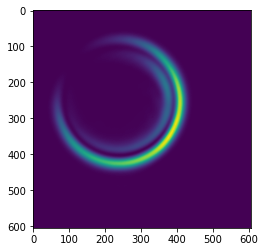

Predicted phi_CR -0.7164536714553833 rad -41.04977159104597 deg


Predicted Polarization plane -relative to the image plane w axis- is -0.35822683572769165 rad -20.524885795522984 deg


In [19]:
print("Referencia sin nada\n")
%matplotlib inline
image_full_path = "/home/oiangu/Desktop/Conical_Refraction_Polarimeter/LAB/EXPERIMENTAL/Fotos_Turpin/Day2/laser_gaussian_thesis/All_Taken_Photos/sin_los_dos_solo_tubo.png"
im = cv2.imread(image_full_path, cv2.IMREAD_ANYDEPTH)

im = np.asarray((compute_raw_to_centered_iX(torch.from_numpy(im).unsqueeze(0).to(device))).to('cpu').squeeze(0))
plt.imshow(im)
plt.show()

model.eval()
embedding = torch.Tensor(umap_embedder.transform(np.expand_dims(im.flatten(),0))) # [1, embedding_dims]
predictions = model(embedding.to(device).unsqueeze(0))[0]
ref=predictions[0].item()
print(f"Predicted phi_CR {ref} rad {ref*180/np.pi} deg")
print(f"\n\nPredicted Polarization plane -relative to the image plane w axis- is {ref/2} rad {ref*180/np.pi/2} deg")

Referencia sin nada



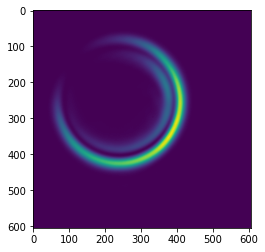

Predicted phi_CR -0.6822558045387268 rad -39.09037814837148 deg


Predicted Polarization plane -relative to the image plane w axis- is -0.3411279022693634 rad -19.54518907418574 deg


In [21]:
print("Referencia sin nada\n")
%matplotlib inline
image_full_path = "/home/oiangu/Desktop/Conical_Refraction_Polarimeter/LAB/EXPERIMENTAL/Fotos_Turpin/Day2/laser_gaussian_thesis/All_Taken_Photos/antes_de_la_estandar.png"
im = cv2.imread(image_full_path, cv2.IMREAD_ANYDEPTH)

im = np.asarray((compute_raw_to_centered_iX(torch.from_numpy(im).unsqueeze(0).to(device))).to('cpu').squeeze(0))
plt.imshow(im)
plt.show()

model.eval()
embedding = torch.Tensor(umap_embedder.transform(np.expand_dims(im.flatten(),0))) # [1, embedding_dims]
predictions = model(embedding.to(device).unsqueeze(0))[0]
ref2=predictions[0].item()
print(f"Predicted phi_CR {ref2} rad {ref2*180/np.pi} deg")
print(f"\n\nPredicted Polarization plane -relative to the image plane w axis- is {ref2/2} rad {ref2*180/np.pi/2} deg")

Sin el negativo



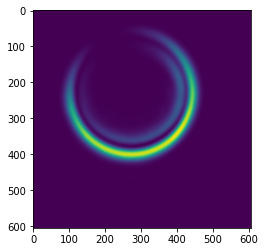

Predicted phi_CR -0.9957439303398132 rad -57.05192468423994 deg


Predicted Polarization plane -relative to the image plane w axis- is -0.4978719651699066 rad -28.52596234211997 deg


In [22]:
print("Sin el negativo\n")
%matplotlib inline

image_full_path = "/home/oiangu/Desktop/Conical_Refraction_Polarimeter/LAB/EXPERIMENTAL/Fotos_Turpin/Day2/laser_gaussian_thesis/All_Taken_Photos/sin_el_negativo.png"
im = cv2.imread(image_full_path, cv2.IMREAD_ANYDEPTH)

im = np.asarray((compute_raw_to_centered_iX(torch.from_numpy(im).unsqueeze(0).to(device))).to('cpu').squeeze(0))
plt.imshow(im)
plt.show()

model.eval()
embedding = torch.Tensor(umap_embedder.transform(np.expand_dims(im.flatten(),0))) # [1, embedding_dims]
predictions = model(embedding.to(device).unsqueeze(0))[0]
pos=predictions[0].item()
print(f"Predicted phi_CR {pos} rad {pos*180/np.pi} deg")
print(f"\n\nPredicted Polarization plane -relative to the image plane w axis- is {pos/2} rad {pos*180/np.pi/2} deg")

Sin el positivo



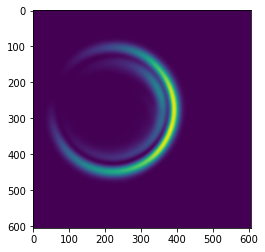

Predicted phi_CR -0.2874451279640198 rad -16.469392673936213 deg


Predicted Polarization plane -relative to the image plane w axis- is -0.1437225639820099 rad -8.234696336968106 deg


In [23]:
print("Sin el positivo\n")
%matplotlib inline

image_full_path = "/home/oiangu/Desktop/Conical_Refraction_Polarimeter/LAB/EXPERIMENTAL/Fotos_Turpin/Day2/laser_gaussian_thesis/All_Taken_Photos/sin_el_positivo.png"
im = cv2.imread(image_full_path, cv2.IMREAD_ANYDEPTH)

im = np.asarray((compute_raw_to_centered_iX(torch.from_numpy(im).unsqueeze(0).to(device))).to('cpu').squeeze(0))
plt.imshow(im)
plt.show()

model.eval()
embedding = torch.Tensor(umap_embedder.transform(np.expand_dims(im.flatten(),0))) # [1, embedding_dims]
predictions = model(embedding.to(device).unsqueeze(0))[0]
neg = predictions[0].item()
print(f"Predicted phi_CR {neg} rad {neg*180/np.pi} deg")
print(f"\n\nPredicted Polarization plane -relative to the image plane w axis- is {neg/2} rad {neg*180/np.pi/2} deg")

Con ambos



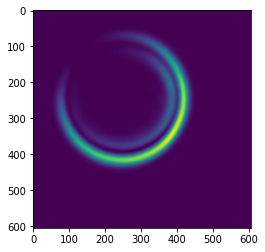

Predicted phi_CR -0.7735697627067566 rad -44.32228256203374 deg


Predicted Polarization plane -relative to the image plane w axis- is -0.3867848813533783 rad -22.16114128101687 deg


In [24]:
print("Con ambos\n")
%matplotlib inline

image_full_path = "/home/oiangu/Desktop/Conical_Refraction_Polarimeter/LAB/EXPERIMENTAL/Fotos_Turpin/Day2/laser_gaussian_thesis/All_Taken_Photos/con_los_dos.png"
im = cv2.imread(image_full_path, cv2.IMREAD_ANYDEPTH)

im = np.asarray((compute_raw_to_centered_iX(torch.from_numpy(im).unsqueeze(0).to(device))).to('cpu').squeeze(0))
plt.imshow(im)
plt.show()

model.eval()
embedding = torch.Tensor(umap_embedder.transform(np.expand_dims(im.flatten(),0))) # [1, embedding_dims]
predictions = model(embedding.to(device).unsqueeze(0))[0]
both=predictions[0].item()
print(f"Predicted phi_CR {both} rad {both*180/np.pi} deg")
print(f"\n\nPredicted Polarization plane -relative to the image plane w axis- is {both/2} rad {both*180/np.pi/2} deg")


Ref Ort



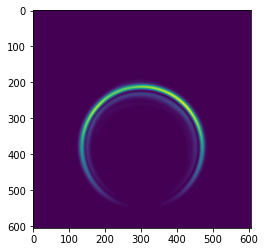

Predicted phi_CR 1.416640043258667 rad 81.16749556795199 deg


Predicted Polarization plane -relative to the image plane w axis- is 0.7083200216293335 rad 40.583747783975994 deg


In [25]:
print("Ref Ort\n")
%matplotlib inline

image_full_path = "/home/oiangu/Desktop/Conical_Refraction_Polarimeter/LAB/EXPERIMENTAL/Fotos_Turpin/Day3/Reference/Reference__100.png"
im = cv2.imread(image_full_path, cv2.IMREAD_ANYDEPTH)

im = np.asarray((compute_raw_to_centered_iX(torch.from_numpy(im).unsqueeze(0).to(device))).to('cpu').squeeze(0))
plt.imshow(im)
plt.show()

model.eval()
embedding = torch.Tensor(umap_embedder.transform(np.expand_dims(im.flatten(),0))) # [1, embedding_dims]
predictions = model(embedding.to(device).unsqueeze(0))[0]
ref_ort=predictions[0].item()
print(f"Predicted phi_CR {ref_ort} rad {ref_ort*180/np.pi} deg")
print(f"\n\nPredicted Polarization plane -relative to the image plane w axis- is {ref_ort/2} rad {ref_ort*180/np.pi/2} deg")


Ort



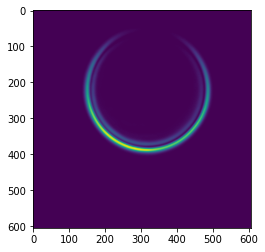

Predicted phi_CR 1.416640043258667 rad -91.98804517562627 deg


Predicted Polarization plane -relative to the image plane w axis- is -0.8027471303939819 rad -45.994022587813134 deg


In [26]:
print("Ort\n")
%matplotlib inline

image_full_path = "/home/oiangu/Desktop/Conical_Refraction_Polarimeter/LAB/EXPERIMENTAL/Fotos_Turpin/Day3/Problem/90__100.png"
im = cv2.imread(image_full_path, cv2.IMREAD_ANYDEPTH)

im = np.asarray((compute_raw_to_centered_iX(torch.from_numpy(im).unsqueeze(0).to(device))).to('cpu').squeeze(0))
plt.imshow(im)
plt.show()

model.eval()
embedding = torch.Tensor(umap_embedder.transform(np.expand_dims(im.flatten(),0))) # [1, embedding_dims]
predictions = model(embedding.to(device).unsqueeze(0))[0]
ort=predictions[0].item()
print(f"Predicted phi_CR {ref_ort} rad {ort*180/np.pi} deg")
print(f"\n\nPredicted Polarization plane -relative to the image plane w axis- is {ort/2} rad {ort*180/np.pi/2} deg")


In [28]:
print(f"Positivo-Ref deberian ser {9.45} deg son {-(pos-ref)*180/np.pi/2} deg")
print(f"Negativo-Ref deberian ser {13.85} deg son {(neg-ref)*180/np.pi/2} deg")
print(f"Ambos-Ref deberian ser {4.4} deg son {-(both-ref)*180/np.pi/2} deg\n")

print(f"Positivo-Ref2 deberian ser {9.45} deg son {-(pos-ref2)*180/np.pi/2} deg")
print(f"Negativo-Ref2 deberian ser {13.85} deg son {(neg-ref2)*180/np.pi/2} deg")
print(f"Ambos-Ref2 deberian ser {4.4} deg son {-(both-ref2)*180/np.pi/2} deg\n")

print(f"Ref2-Ref deberian ser {0} deg son {(ref2-ref)*180/np.pi/2} deg\n")

print(f"El de noventa deberian ser {90} deg son {(ref_ort-ort)*180/np.pi/2} deg")

Positivo-Ref deberian ser 9.45 deg son 8.00107654659699 deg
Negativo-Ref deberian ser 13.85 deg son 12.290189458554876 deg
Ambos-Ref deberian ser 4.4 deg son 1.636255485493887 deg

Positivo-Ref2 deberian ser 9.45 deg son 8.98077326793423 deg
Negativo-Ref2 deberian ser 13.85 deg son 11.310492737217634 deg
Ambos-Ref2 deberian ser 4.4 deg son 2.6159522068311287 deg

Ref2-Ref deberian ser 0 deg son 0.9796967213372415 deg

El de noventa deberian ser 90 deg son 86.57777037178913 deg


In [21]:
from time import time
nimss=[1,2,3,4,5,10,20,40,60]
times=[]
for nims in nimss:
    t0=time()
    images=np.zeros((nims, (2*X+1)**2), dtype=np.float32)
    for i in range(nims):
        images[i,:] = training_data[i][0].flatten()
    a = torch.Tensor(umap_embedder.transform(images))
    t1=time()
    times.append(t1-t0)
    print(nimss, times)

[1, 2, 3, 4, 5, 10, 20, 40, 60] [3.1489973068237305]
[1, 2, 3, 4, 5, 10, 20, 40, 60] [3.1489973068237305, 4.43294358253479]
[1, 2, 3, 4, 5, 10, 20, 40, 60] [3.1489973068237305, 4.43294358253479, 5.951560735702515]
[1, 2, 3, 4, 5, 10, 20, 40, 60] [3.1489973068237305, 4.43294358253479, 5.951560735702515, 6.71141505241394]
[1, 2, 3, 4, 5, 10, 20, 40, 60] [3.1489973068237305, 4.43294358253479, 5.951560735702515, 6.71141505241394, 8.350321531295776]
[1, 2, 3, 4, 5, 10, 20, 40, 60] [3.1489973068237305, 4.43294358253479, 5.951560735702515, 6.71141505241394, 8.350321531295776, 15.662988424301147]
[1, 2, 3, 4, 5, 10, 20, 40, 60] [3.1489973068237305, 4.43294358253479, 5.951560735702515, 6.71141505241394, 8.350321531295776, 15.662988424301147, 27.167689085006714]
[1, 2, 3, 4, 5, 10, 20, 40, 60] [3.1489973068237305, 4.43294358253479, 5.951560735702515, 6.71141505241394, 8.350321531295776, 15.662988424301147, 27.167689085006714, 52.14728355407715]
[1, 2, 3, 4, 5, 10, 20, 40, 60] [3.1489973068237305

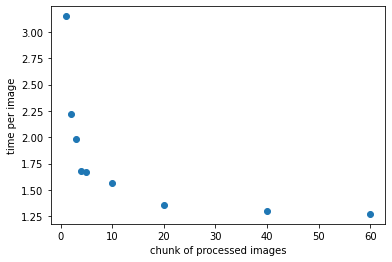

In [26]:
plt.plot(nimss, [time/nims for time, nims in zip(times, nimss)], 'o')
plt.ylabel("time per image")
plt.xlabel("chunk of processed images")
plt.title("Sin usar dataloader")
plt.show()

In [35]:
from time import time
nimss=[1,2,3,4,5,10,20,40,60]
times=[]
for nims in nimss:
    train_dataloader = DataLoader(training_data, batch_size=nims, shuffle=True, num_workers=2,
                              pin_memory=True, drop_last=False, persistent_workers=False)
    t0=time()
    images, labs = next(iter(train_dataloader))
    t1=time()
    times.append(t1-t0)
    print(nimss, times)

[1, 2, 3, 4, 5, 10, 20, 40, 60] [7.3262975215911865]
[1, 2, 3, 4, 5, 10, 20, 40, 60] [7.3262975215911865, 17.49277925491333]
[1, 2, 3, 4, 5, 10, 20, 40, 60] [7.3262975215911865, 17.49277925491333, 16.2593035697937]
[1, 2, 3, 4, 5, 10, 20, 40, 60] [7.3262975215911865, 17.49277925491333, 16.2593035697937, 23.728442668914795]
[1, 2, 3, 4, 5, 10, 20, 40, 60] [7.3262975215911865, 17.49277925491333, 16.2593035697937, 23.728442668914795, 31.327791213989258]
[1, 2, 3, 4, 5, 10, 20, 40, 60] [7.3262975215911865, 17.49277925491333, 16.2593035697937, 23.728442668914795, 31.327791213989258, 41.47978091239929]
[1, 2, 3, 4, 5, 10, 20, 40, 60] [7.3262975215911865, 17.49277925491333, 16.2593035697937, 23.728442668914795, 31.327791213989258, 41.47978091239929, 84.40457129478455]
[1, 2, 3, 4, 5, 10, 20, 40, 60] [7.3262975215911865, 17.49277925491333, 16.2593035697937, 23.728442668914795, 31.327791213989258, 41.47978091239929, 84.40457129478455, 166.68002605438232]
[1, 2, 3, 4, 5, 10, 20, 40, 60] [7.32629

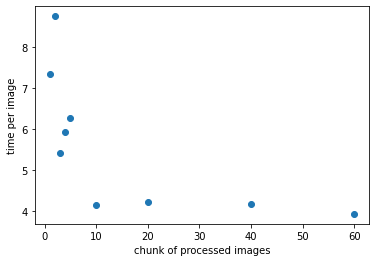

In [36]:
plt.plot(nimss, [time/nims for time, nims in zip(times, nimss)], 'o')
plt.ylabel("time per image")
plt.xlabel("chunk of processed images")
plt.title("Workers 2")
plt.show()

In [37]:
from time import time
nimss=[1,2,3,4,5,10,20,40,60]
times=[]
for nims in nimss:
    train_dataloader = DataLoader(training_data, batch_size=nims, shuffle=True, num_workers=5,
                              pin_memory=True, drop_last=False, persistent_workers=False)
    t0=time()
    images, labs = next(iter(train_dataloader))
    t1=time()
    times.append(t1-t0)
    print(nimss, times)

[1, 2, 3, 4, 5, 10, 20, 40, 60] [8.490159511566162]
[1, 2, 3, 4, 5, 10, 20, 40, 60] [8.490159511566162, 13.74122667312622]
[1, 2, 3, 4, 5, 10, 20, 40, 60] [8.490159511566162, 13.74122667312622, 24.181958198547363]
[1, 2, 3, 4, 5, 10, 20, 40, 60] [8.490159511566162, 13.74122667312622, 24.181958198547363, 39.40571355819702]
[1, 2, 3, 4, 5, 10, 20, 40, 60] [8.490159511566162, 13.74122667312622, 24.181958198547363, 39.40571355819702, 31.851186752319336]
[1, 2, 3, 4, 5, 10, 20, 40, 60] [8.490159511566162, 13.74122667312622, 24.181958198547363, 39.40571355819702, 31.851186752319336, 72.05476903915405]
[1, 2, 3, 4, 5, 10, 20, 40, 60] [8.490159511566162, 13.74122667312622, 24.181958198547363, 39.40571355819702, 31.851186752319336, 72.05476903915405, 105.09947872161865]
[1, 2, 3, 4, 5, 10, 20, 40, 60] [8.490159511566162, 13.74122667312622, 24.181958198547363, 39.40571355819702, 31.851186752319336, 72.05476903915405, 105.09947872161865, 179.39525055885315]
[1, 2, 3, 4, 5, 10, 20, 40, 60] [8.4901

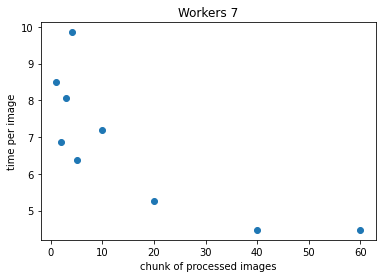

In [38]:
plt.plot(nimss, [time/nims for time, nims in zip(times, nimss)], 'o')
plt.ylabel("time per image")
plt.xlabel("chunk of processed images")
plt.title("Workers 7")
plt.show()